# Advanced Lane Finding Project 

By Pablo Sauras Perez

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## 1. Compute the camera calibration using chessboard images
This code is was available in 'examples/example.ipynb'

In [132]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

Determine object points and image points

In [133]:
# chessboard
ny = 6
nx = 9

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'output_images/calibration_corners_found'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow(write_name,img)
        cv2.waitKey(50)
        
cv2.destroyAllWindows()

### Calibrate, Calculate Distortion Coefficients and test undistorsion on an image
This code is from 'CarND-Camera-Calibration'

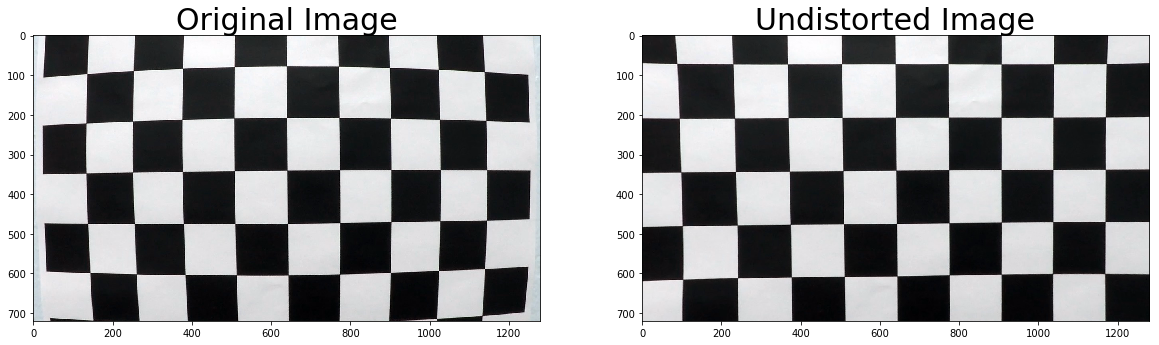

In [134]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Undistorsion
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undistorded_calibration.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#I apply mtx and dist to each new frame
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undis_calibr.jpg')

# Pipeline (single images)

## 2. Apply a distortion correction to raw images

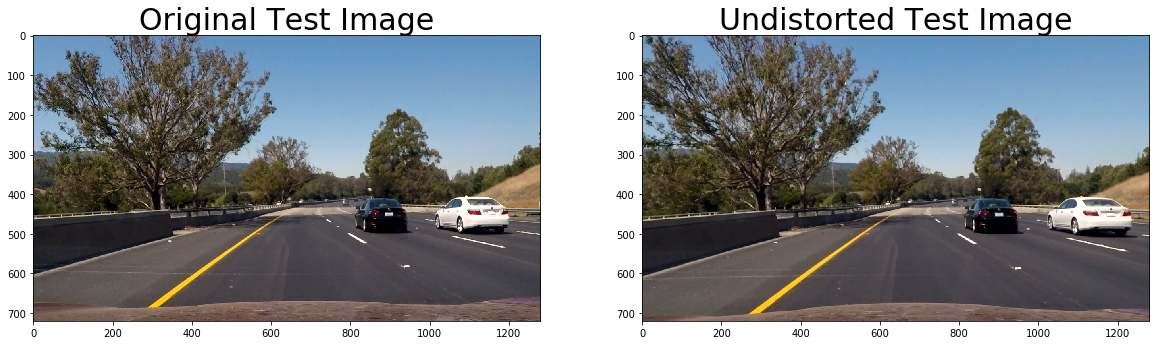

In [224]:
# Test undistortion on an image
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Test Image', fontsize=30)
plt.savefig('output_images/undistorded_test6.jpg')

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

This is the Thresholding step. Here I want to use various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.
Other combinations of gradients, color channels may be possible and may be able to handle the challenges videos.

In [136]:
# Edit this function to create your own pipeline.
def pipeline_threshold(img, v_thresh = (220, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Convert to HSV color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
        
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1

    # Threshold color channel V
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((sxbinary == 1) | (v_binary == 1))] = 1
    color_binary = combined_binary
    
    
    return color_binary

Apply threshold pipeline and show one of the test results

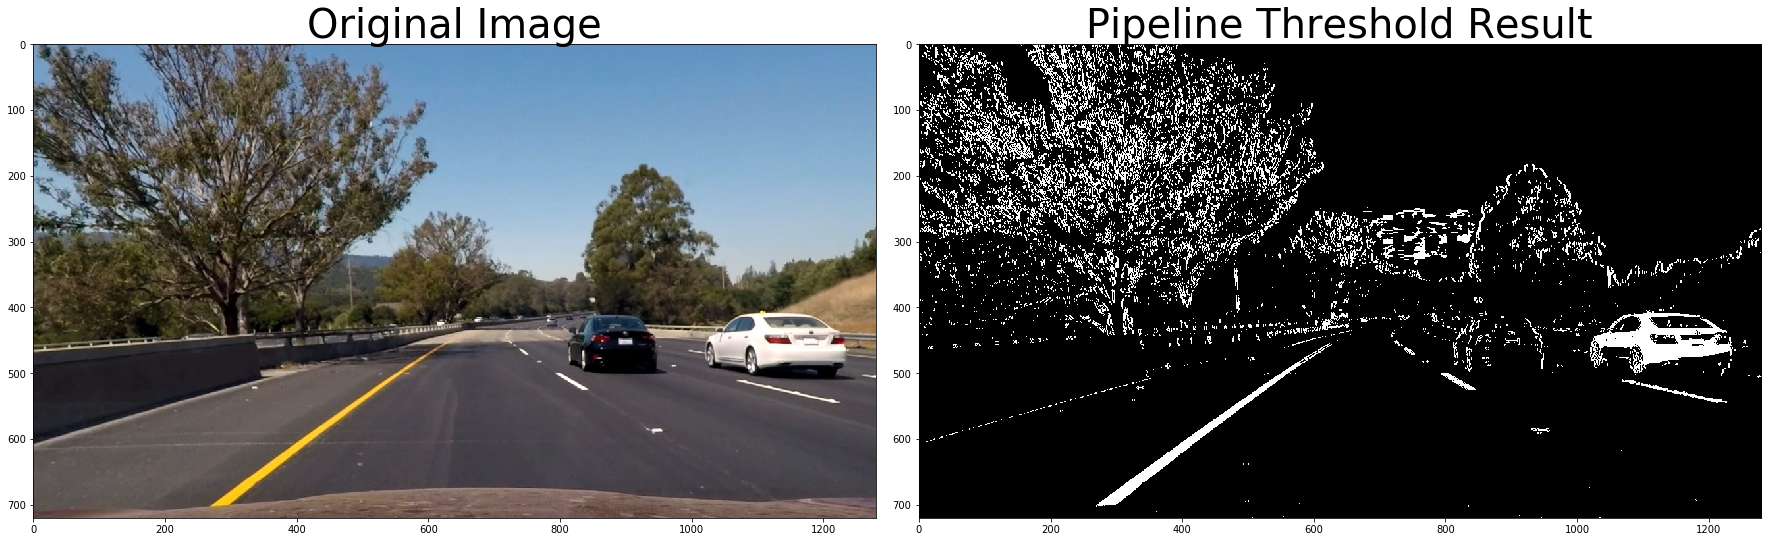

In [225]:
image = dst
undst = dst
color_binary = pipeline_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary, cmap = 'gray')
ax2.set_title('Pipeline Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/binary_test6.jpg')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

I already have mtx --> Calibration Matrix
 and dist --> Distortion Coeficients
from the camera calibration of step 1... so I use them

In [140]:
def corners_unwarp(img, mtx, dist):

    # Undistort using mtx and dist   
    undst = cv2.undistort(img, mtx, dist, None, mtx)  
    img_size =(undst.shape[1], undst.shape[0])
    
    #top-right
    #bottom-right
    #bottom-left
    #top-left
    
    #source points (trapezoid)  
    src = np.float32(
    [[580, 460],
     [195, 720],
     [1127, 720],
     [705, 460]])
    
   
    #destination points (a rectangle)        
    dst = np.float32(
    [[200, 0],
     [200, 720],
     [950, 720], 
     [950, 0]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #calculate the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)
 
    return warped, M, Minv, src, dst

Apply it perspective transform function

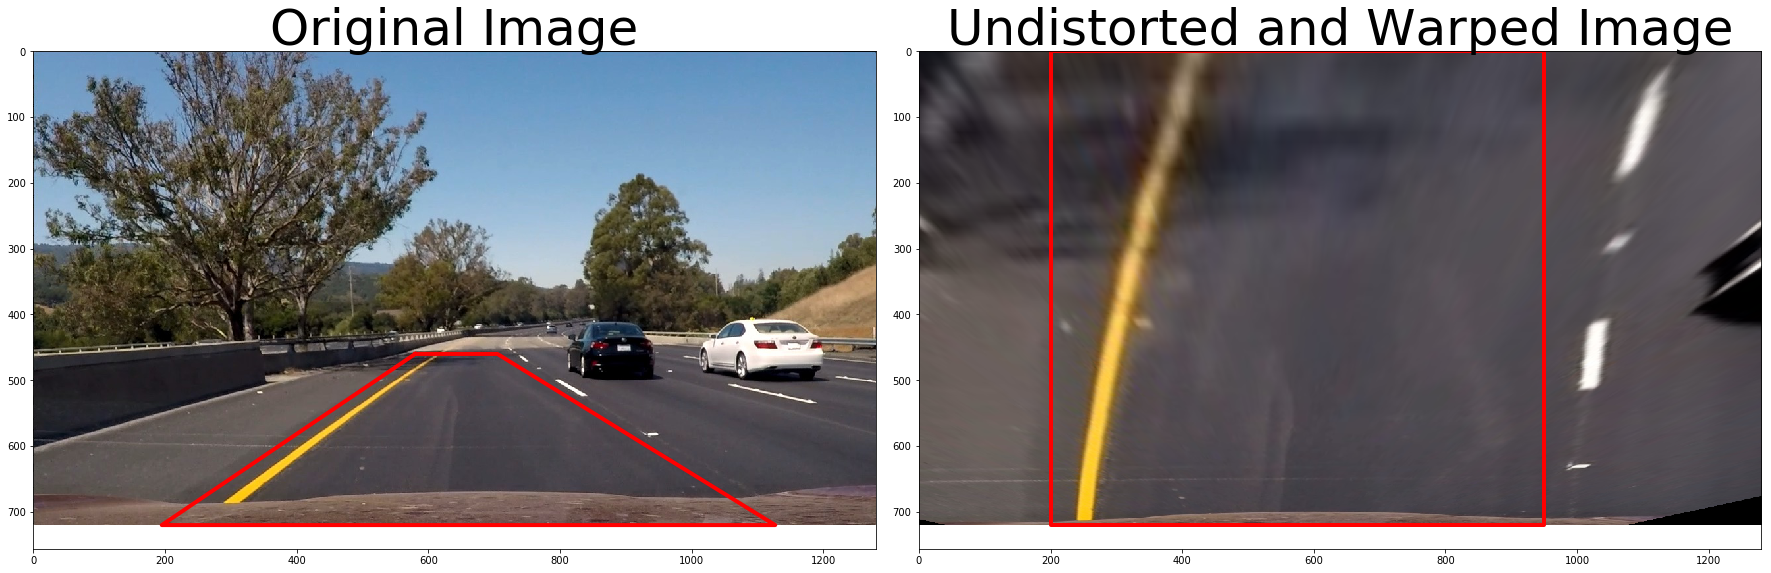

In [226]:
# Test on an image where lines are straight
img = cv2.imread('test_images/test6.jpg')

top_down, perspective_M, perspective_Minv, src, dst = corners_unwarp(img, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/color_warp_test6.jpg')

Now I apply perspective transform to rectify binary image

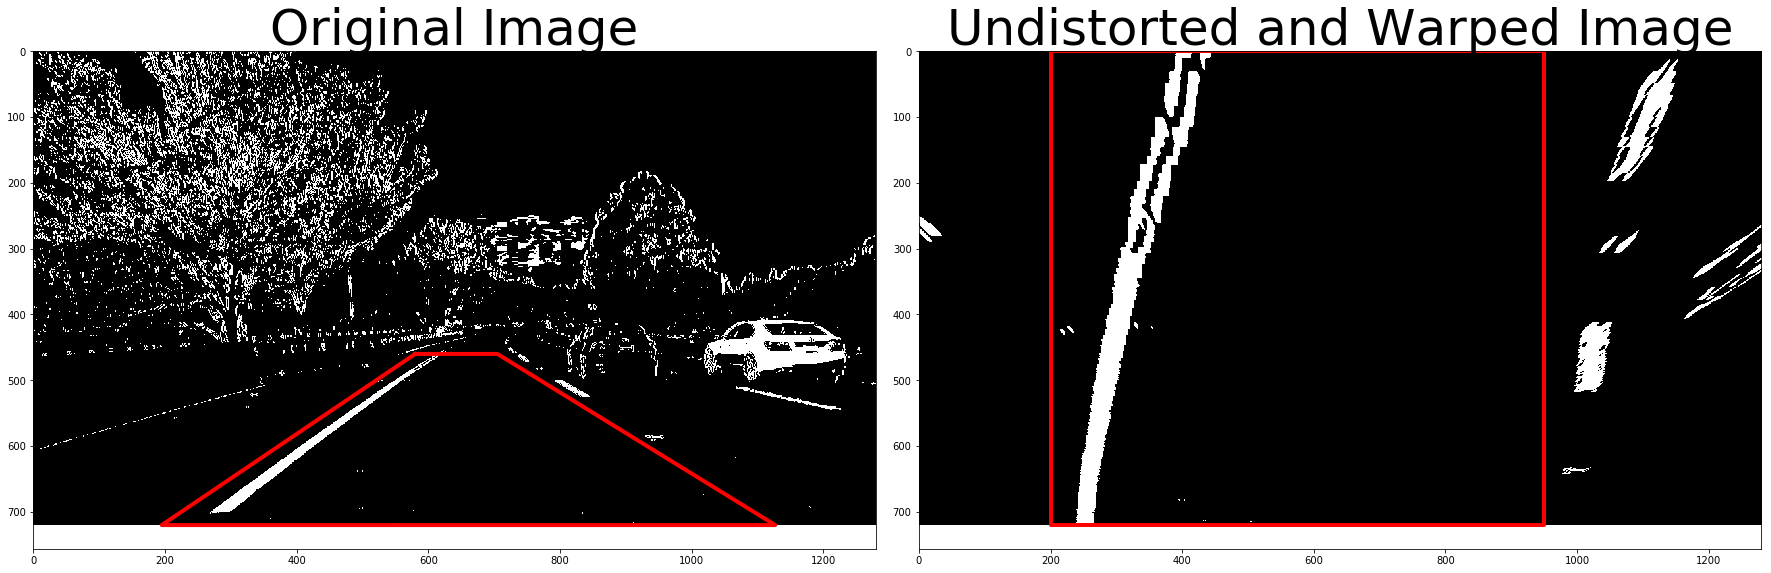

In [227]:
binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.savefig('output_images/warped_binary_test6.jpg')

## 5. Detect lane pixels and fit to find the lane boundary.

In [143]:
#Function to implement sliding window
def lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix):
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx

Apply the slidding window function

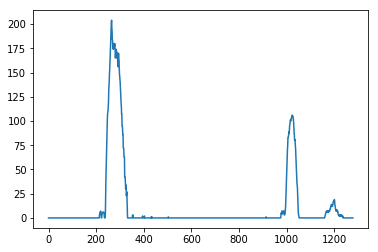

In [228]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 75

# Set minimum number of pixels found to recenter window
minpix = 50

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/histogram_test6.jpg')

#Call the function
left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)

### Visualization
Visualization of the slidding window results

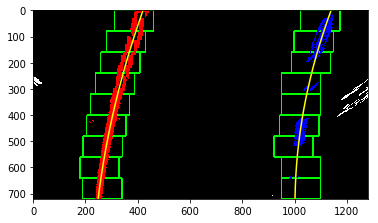

In [229]:
# Generate x and y values for plotting
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/lane_lines_test6.jpg')

## 6. Determine the curvature of the lane and vehicle position with respect to center

First I do Radius in Pixels

In [147]:
#Calculate radius of curvature
def rad_cur_px(ploty, y_eval, left_fit, right_fit):
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('Left Radius: ', left_curverad)
    print('Right Radius: ', right_curverad)
    
    return left_curverad, right_curverad

Call the function

In [230]:
y_eval = np.max(ploty)
left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

Left Radius:  3179.98941516
Right Radius:  2021.4548991


Now we have to convert this to the real world space. 
Assume (as indicated in the lesson) hat if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [220]:
#Radius of curvature in meters
def rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix):


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Left curvature: ', left_curverad, 'm')
    print('Right curvature: ', right_curverad, 'm')

    R_avg = (left_curverad + right_curverad)/2

    curv_str = "Radius of Curvature: %im" % abs(R_avg)
    print(curv_str)
    
    return curv_str, left_fit_cr, right_fit_cr

Call the function

In [231]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/750 # meters per pixel in x dimension
curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)

Left curvature:  1094.78751722 m
Right curvature:  711.19673865 m
Radius of Curvature: 902m


## Offset calculation
Calculate what is the possition of the vehicle with respect to the center of the lane

In [178]:
#Lateral offset calculation
def lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    
    #Calculate distance at the bottom of the image
    left_fit_cr_eval = left_fit_cr[0]*y_eval*ym_per_pix**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_fit_cr_eval = right_fit_cr[0]*y_eval*ym_per_pix**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]

    image_center = (binary_warped.shape[1]/2)*xm_per_pix #Convert to m
    lane_center = (right_fit_cr_eval + left_fit_cr_eval)/2 #Already in m

    offset = image_center - lane_center

    #Depending on offset sign, the car will be at the left or right of the center
    if offset > 0:
        offset_str = "Vehicle is %.2fm left of center" % abs(offset)
        print(offset_str)
    elif offset < 0:
        offset_str = "Vehicle is %.2fm right of center" % abs(offset)
        print(offset_str)
    else:
        offset_str = "Vehicle is at center"
        print(offset_str)   
        
    return offset_str

Call the function

In [232]:
offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)

Vehicle is 0.59m left of center


## 7. Warp the detected lane boundaries back onto the original image.

In [180]:
#Function to warp back the lane lines and draw them
def warp_back_boundary(image, undst, binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, curv_str, offset_str):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)  
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.8, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
    result = cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
    
    return result

Call the function

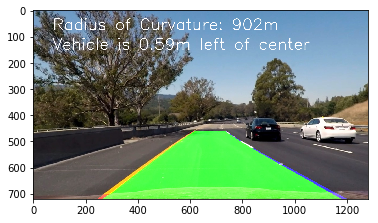

In [233]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
lane_boundary = warp_back_boundary(img, undst, binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, curv_str, offset_str)

plt.imshow(lane_boundary)
plt.savefig('output_images/result_test6.jpg')

## Pipeline (Video)

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Process Function. Every frame of the video goes to this function (which has the pipeline steps)

In [234]:
#Image
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
def process_image(image):
    
    # 1. Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    img = image

    #2. Calculate distortion coefficients
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #3. Color / Gradient thresholding
    color_binary = pipeline_threshold(undst)
    
    #4. Unwrap  
    binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)
    
    #5. Detect lane pixels to find lane boundary
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    #6. Slidding Window
    nwindows = 9
    margin = 75
    minpix = 50

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)
    

    #7. Determine Rad Curvature
    # In pixels
    y_eval = np.max(ploty)
    left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

    #In meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    #8. Calculate lateral offset
    offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)
    
    #9. Waro back lane lines
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    result = warp_back_boundary(img, undst, binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, curv_str, offset_str)
    
    return result

Now I apply the previous function to the video frames

In [238]:
output_clip = "output_images/project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")

clip_result = clip.fl_image(process_image)

%time clip_result.write_videofile(output_clip, audio=False)

Left Radius:  2017.48864564
Right Radius:  2326.19953007
Left curvature:  605.746436523 m
Right curvature:  698.342065807 m
Radius of Curvature: 652m
Vehicle is 0.67m right of center
[MoviePy] >>>> Building video output_images/project_video_result.mp4
[MoviePy] Writing video output_images/project_video_result.mp4


  0%|          | 1/1261 [00:00<03:16,  6.41it/s]

Left Radius:  2017.48864564
Right Radius:  2326.19953007
Left curvature:  605.746436523 m
Right curvature:  698.342065807 m
Radius of Curvature: 652m
Vehicle is 0.67m right of center


  0%|          | 2/1261 [00:00<03:12,  6.54it/s]

Left Radius:  2039.21308828
Right Radius:  2412.51940969
Left curvature:  612.316277988 m
Right curvature:  723.531112384 m
Radius of Curvature: 667m
Vehicle is 0.66m right of center


  0%|          | 3/1261 [00:00<03:08,  6.68it/s]

Left Radius:  1862.21172326
Right Radius:  1553.99938393
Left curvature:  558.821939597 m
Right curvature:  466.186370564 m
Radius of Curvature: 512m
Vehicle is 0.85m right of center


  0%|          | 4/1261 [00:00<03:04,  6.82it/s]

Left Radius:  1701.17252496
Right Radius:  1679.70597213
Left curvature:  509.89942996 m
Right curvature:  504.407070827 m
Radius of Curvature: 507m
Vehicle is 0.86m right of center


  0%|          | 5/1261 [00:00<02:56,  7.13it/s]

Left Radius:  1666.52192504
Right Radius:  1787.32361255
Left curvature:  499.450411091 m
Right curvature:  536.447195193 m
Radius of Curvature: 517m
Vehicle is 0.85m right of center


  0%|          | 6/1261 [00:00<02:50,  7.34it/s]

Left Radius:  1811.65852661
Right Radius:  2116.92650031
Left curvature:  543.879588819 m
Right curvature:  633.360777515 m
Radius of Curvature: 588m
Vehicle is 0.76m right of center


  1%|          | 7/1261 [00:00<02:46,  7.53it/s]

Left Radius:  1840.624463
Right Radius:  2393.97466409
Left curvature:  552.733817483 m
Right curvature:  714.574096514 m
Radius of Curvature: 633m
Vehicle is 0.72m right of center


  1%|          | 8/1261 [00:01<02:45,  7.56it/s]

Left Radius:  1934.24380251
Right Radius:  19708.4041353
Left curvature:  580.781124511 m
Right curvature:  5518.98276128 m
Radius of Curvature: 3049m
Vehicle is 0.51m right of center


  1%|          | 9/1261 [00:01<02:43,  7.65it/s]

Left Radius:  1920.00017853
Right Radius:  111377.445971
Left curvature:  576.435172359 m
Right curvature:  30634.3460182 m
Radius of Curvature: 15605m
Vehicle is 0.48m right of center


  1%|          | 10/1261 [00:01<02:50,  7.32it/s]

Left Radius:  2030.45054334
Right Radius:  70898.2540234
Left curvature:  608.991130488 m
Right curvature:  19543.6968016 m
Radius of Curvature: 10076m
Vehicle is 0.45m right of center


  1%|          | 11/1261 [00:01<03:01,  6.89it/s]

Left Radius:  2114.27182566
Right Radius:  3682.97653235
Left curvature:  633.464155804 m
Right curvature:  1079.4103469 m
Radius of Curvature: 856m
Vehicle is 0.60m right of center
Left Radius:  2309.3599374
Right Radius:  5531.19314505
Left curvature:  689.780188936 m
Right curvature:  1615.87301349 m
Radius of Curvature: 1152m
Vehicle is 0.51m right of center


  1%|          | 13/1261 [00:01<03:17,  6.33it/s]

Left Radius:  2438.96942602
Right Radius:  5265.93793486
Left curvature:  727.305772965 m
Right curvature:  1536.79421402 m
Radius of Curvature: 1132m
Vehicle is 0.50m right of center


  1%|          | 14/1261 [00:02<03:12,  6.49it/s]

Left Radius:  2408.01639177
Right Radius:  5080.88492486
Left curvature:  717.976586402 m
Right curvature:  1482.62058703 m
Radius of Curvature: 1100m
Vehicle is 0.50m right of center


  1%|          | 15/1261 [00:02<03:02,  6.81it/s]

Left Radius:  2595.59627317
Right Radius:  2940.06451687
Left curvature:  772.965692305 m
Right curvature:  866.729453051 m
Radius of Curvature: 819m
Vehicle is 0.56m right of center


  1%|▏         | 16/1261 [00:02<02:51,  7.25it/s]

Left Radius:  2327.49157085
Right Radius:  2127.77432233
Left curvature:  695.542195329 m
Right curvature:  631.541163415 m
Radius of Curvature: 663m
Vehicle is 0.67m right of center


  1%|▏         | 17/1261 [00:02<02:41,  7.72it/s]

Left Radius:  2718.24949936
Right Radius:  2471.33422406
Left curvature:  808.914586054 m
Right curvature:  729.302202732 m
Radius of Curvature: 769m
Vehicle is 0.58m right of center


  1%|▏         | 18/1261 [00:02<02:41,  7.72it/s]

Left Radius:  2593.08154259
Right Radius:  2830.96480631
Left curvature:  772.653222931 m
Right curvature:  829.036617688 m
Radius of Curvature: 800m
Vehicle is 0.55m right of center


  2%|▏         | 19/1261 [00:02<02:46,  7.44it/s]

Left Radius:  2756.05499481
Right Radius:  2968.41505512
Left curvature:  819.122491801 m
Right curvature:  872.660804351 m
Radius of Curvature: 845m
Vehicle is 0.52m right of center


  2%|▏         | 20/1261 [00:02<02:40,  7.74it/s]

Left Radius:  2998.56703851
Right Radius:  3476.71938514
Left curvature:  889.024680691 m
Right curvature:  1019.8293597 m
Radius of Curvature: 954m
Vehicle is 0.46m right of center


  2%|▏         | 21/1261 [00:02<02:36,  7.90it/s]

Left Radius:  3333.33838315
Right Radius:  4975.15491148
Left curvature:  983.941821742 m
Right curvature:  1446.14550128 m
Radius of Curvature: 1215m
Vehicle is 0.39m right of center


  2%|▏         | 22/1261 [00:03<02:42,  7.61it/s]

Left Radius:  3402.06292268
Right Radius:  8607.82948571
Left curvature:  1002.69624988 m
Right curvature:  2472.04906288 m
Radius of Curvature: 1737m
Vehicle is 0.33m right of center
Left Radius:  3733.78903751
Right Radius:  6521.99274892
Left curvature:  1097.49842734 m
Right curvature:  1899.31988636 m
Radius of Curvature: 1498m
Vehicle is 0.32m right of center


  2%|▏         | 23/1261 [00:03<02:57,  6.97it/s]

Left Radius:  3231.22079838
Right Radius:  3092.41141165
Left curvature:  956.186577789 m
Right curvature:  919.447560249 m
Radius of Curvature: 937m
Vehicle is 0.44m right of center


  2%|▏         | 25/1261 [00:03<02:57,  6.95it/s]

Left Radius:  3000.28345102
Right Radius:  2226.34458504
Left curvature:  891.784612595 m
Right curvature:  666.495797258 m
Radius of Curvature: 779m
Vehicle is 0.52m right of center


  2%|▏         | 26/1261 [00:03<02:49,  7.27it/s]

Left Radius:  3065.55078121
Right Radius:  2408.04641955
Left curvature:  910.571357801 m
Right curvature:  721.457774422 m
Radius of Curvature: 816m
Vehicle is 0.49m right of center


  2%|▏         | 27/1261 [00:03<02:43,  7.56it/s]

Left Radius:  2705.90979996
Right Radius:  3211.91935838
Left curvature:  807.749576168 m
Right curvature:  956.499053925 m
Radius of Curvature: 882m
Vehicle is 0.45m right of center


  2%|▏         | 28/1261 [00:03<02:37,  7.85it/s]

Left Radius:  2798.74887373
Right Radius:  3004.642321
Left curvature:  835.122903083 m
Right curvature:  899.772859402 m
Radius of Curvature: 867m
Vehicle is 0.44m right of center


  2%|▏         | 29/1261 [00:04<02:41,  7.64it/s]

Left Radius:  2540.10034862
Right Radius:  2854.59351423
Left curvature:  760.192600053 m
Right curvature:  854.546330383 m
Radius of Curvature: 807m
Vehicle is 0.48m right of center


  2%|▏         | 30/1261 [00:04<02:36,  7.88it/s]

Left Radius:  2375.74208155
Right Radius:  1715.46442549
Left curvature:  712.144701069 m
Right curvature:  515.154167143 m
Radius of Curvature: 613m
Vehicle is 0.66m right of center


  2%|▏         | 31/1261 [00:04<02:31,  8.14it/s]

Left Radius:  2090.15271476
Right Radius:  1816.09810746
Left curvature:  627.498098072 m
Right curvature:  544.766864797 m
Radius of Curvature: 586m
Vehicle is 0.68m right of center


  3%|▎         | 32/1261 [00:04<02:28,  8.29it/s]

Left Radius:  1867.82333277
Right Radius:  2078.82824749
Left curvature:  560.817514114 m
Right curvature:  620.573284814 m
Radius of Curvature: 590m
Vehicle is 0.67m right of center


  3%|▎         | 33/1261 [00:04<02:32,  8.05it/s]

Left Radius:  1940.16338663
Right Radius:  2909.81162814
Left curvature:  582.62890369 m
Right curvature:  860.359993646 m
Radius of Curvature: 721m
Vehicle is 0.59m right of center


  3%|▎         | 34/1261 [00:04<02:27,  8.33it/s]

Left Radius:  1839.12385381
Right Radius:  20096.0601891
Left curvature:  552.199162808 m
Right curvature:  5560.6365563 m
Radius of Curvature: 3056m
Vehicle is 0.46m right of center


  3%|▎         | 35/1261 [00:04<02:23,  8.53it/s]

Left Radius:  1780.0688738
Right Radius:  8177.73938225
Left curvature:  534.360216498 m
Right curvature:  2311.91357752 m
Radius of Curvature: 1423m
Vehicle is 0.51m right of center


  3%|▎         | 36/1261 [00:04<02:30,  8.12it/s]

Left Radius:  1794.31084089
Right Radius:  2388.51475539
Left curvature:  538.705849212 m
Right curvature:  708.70786573 m
Radius of Curvature: 623m
Vehicle is 0.67m right of center


  3%|▎         | 37/1261 [00:04<02:37,  7.78it/s]

Left Radius:  1702.68518767
Right Radius:  2701.34558484
Left curvature:  511.018020469 m
Right curvature:  796.639407051 m
Radius of Curvature: 653m
Vehicle is 0.66m right of center


  3%|▎         | 38/1261 [00:05<02:40,  7.63it/s]

Left Radius:  1595.21476232
Right Radius:  2920.77727709
Left curvature:  478.415005834 m
Right curvature:  856.559956732 m
Radius of Curvature: 667m
Vehicle is 0.68m right of center


  3%|▎         | 39/1261 [00:05<02:39,  7.67it/s]

Left Radius:  1502.08675949
Right Radius:  1732.90747847
Left curvature:  450.066473481 m
Right curvature:  517.66340319 m
Radius of Curvature: 483m
Vehicle is 0.85m right of center


  3%|▎         | 40/1261 [00:05<02:32,  7.99it/s]

Left Radius:  1487.48051916
Right Radius:  1514.46475379
Left curvature:  445.736818062 m
Right curvature:  454.044147976 m
Radius of Curvature: 449m
Vehicle is 0.91m right of center


  3%|▎         | 41/1261 [00:05<02:28,  8.20it/s]

Left Radius:  1471.79516351
Right Radius:  1758.72093296
Left curvature:  441.097740813 m
Right curvature:  525.030216141 m
Radius of Curvature: 483m
Vehicle is 0.86m right of center


  3%|▎         | 42/1261 [00:05<02:25,  8.39it/s]

Left Radius:  1446.50605668
Right Radius:  2068.60995906
Left curvature:  433.648146742 m
Right curvature:  615.143412108 m
Radius of Curvature: 524m
Vehicle is 0.81m right of center


  3%|▎         | 43/1261 [00:05<02:28,  8.21it/s]

Left Radius:  1440.95717836
Right Radius:  1594.77503762
Left curvature:  432.261814979 m
Right curvature:  477.405390893 m
Radius of Curvature: 454m
Vehicle is 0.93m right of center


  3%|▎         | 44/1261 [00:05<02:39,  7.64it/s]

Left Radius:  1565.79524442
Right Radius:  1729.50825501
Left curvature:  470.194667686 m
Right curvature:  517.813457464 m
Radius of Curvature: 494m
Vehicle is 0.85m right of center


  4%|▎         | 45/1261 [00:05<02:35,  7.80it/s]

Left Radius:  1622.27790535
Right Radius:  2049.24659384
Left curvature:  487.124692311 m
Right curvature:  611.07524472 m
Radius of Curvature: 549m
Vehicle is 0.79m right of center


  4%|▎         | 46/1261 [00:06<02:35,  7.81it/s]

Left Radius:  1647.19543273
Right Radius:  3600.35893706
Left curvature:  494.475473073 m
Right curvature:  1046.54940088 m
Radius of Curvature: 770m
Vehicle is 0.67m right of center


  4%|▎         | 47/1261 [00:06<02:42,  7.48it/s]

Left Radius:  1781.20409493
Right Radius:  5094.10594013
Left curvature:  534.139069193 m
Right curvature:  1458.1282415 m
Radius of Curvature: 996m
Vehicle is 0.59m right of center


  4%|▍         | 48/1261 [00:06<02:41,  7.50it/s]

Left Radius:  1791.28785412
Right Radius:  5198.02534437
Left curvature:  536.766668187 m
Right curvature:  1485.86546329 m
Radius of Curvature: 1011m
Vehicle is 0.59m right of center


  4%|▍         | 49/1261 [00:06<02:41,  7.51it/s]

Left Radius:  1935.26853973
Right Radius:  5456.30372895
Left curvature:  578.223909087 m
Right curvature:  1573.57829347 m
Radius of Curvature: 1075m
Vehicle is 0.54m right of center


  4%|▍         | 50/1261 [00:06<02:43,  7.42it/s]

Left Radius:  2071.02841119
Right Radius:  2000.85359057
Left curvature:  617.17365099 m
Right curvature:  598.022576531 m
Radius of Curvature: 607m
Vehicle is 0.70m right of center


  4%|▍         | 51/1261 [00:06<02:41,  7.47it/s]

Left Radius:  2188.93690812
Right Radius:  2742.54872338
Left curvature:  650.778582801 m
Right curvature:  809.808914329 m
Radius of Curvature: 730m
Vehicle is 0.61m right of center


  4%|▍         | 52/1261 [00:06<02:51,  7.04it/s]

Left Radius:  2385.92272108
Right Radius:  2820.51546215
Left curvature:  707.576949333 m
Right curvature:  829.482339554 m
Radius of Curvature: 768m
Vehicle is 0.57m right of center


  4%|▍         | 53/1261 [00:07<02:54,  6.91it/s]

Left Radius:  2499.01658683
Right Radius:  2044.40865201
Left curvature:  740.355045531 m
Right curvature:  608.076906901 m
Radius of Curvature: 674m
Vehicle is 0.64m right of center


  4%|▍         | 54/1261 [00:07<02:48,  7.17it/s]

Left Radius:  2538.79107406
Right Radius:  1858.76083314
Left curvature:  751.950516406 m
Right curvature:  553.750008681 m
Radius of Curvature: 652m
Vehicle is 0.66m right of center


  4%|▍         | 55/1261 [00:07<02:52,  7.00it/s]

Left Radius:  2776.59886726
Right Radius:  1986.6554022
Left curvature:  819.315603933 m
Right curvature:  591.400508743 m
Radius of Curvature: 705m
Vehicle is 0.61m right of center


  4%|▍         | 56/1261 [00:07<02:50,  7.07it/s]

Left Radius:  3060.60976549
Right Radius:  1798.03549509
Left curvature:  900.498231899 m
Right curvature:  536.570194634 m
Radius of Curvature: 718m
Vehicle is 0.63m right of center


  5%|▍         | 57/1261 [00:07<02:44,  7.30it/s]

Left Radius:  3339.78334317
Right Radius:  1938.99557401
Left curvature:  980.364128414 m
Right curvature:  577.340383113 m
Radius of Curvature: 778m
Vehicle is 0.57m right of center


  5%|▍         | 58/1261 [00:07<02:50,  7.05it/s]

Left Radius:  3356.91276407
Right Radius:  2922.45053329
Left curvature:  985.994176296 m
Right curvature:  853.644950607 m
Radius of Curvature: 919m
Vehicle is 0.47m right of center


  5%|▍         | 59/1261 [00:07<02:46,  7.20it/s]

Left Radius:  3038.05094454
Right Radius:  7908.37098936
Left curvature:  898.208188507 m
Right curvature:  2163.95258457 m
Radius of Curvature: 1531m
Vehicle is 0.38m right of center


  5%|▍         | 60/1261 [00:08<02:51,  7.00it/s]

Left Radius:  3042.64696412
Right Radius:  2787.48037152
Left curvature:  901.830499487 m
Right curvature:  804.533455272 m
Radius of Curvature: 853m
Vehicle is 0.48m right of center


  5%|▍         | 61/1261 [00:08<02:51,  7.02it/s]

Left Radius:  2650.24310352
Right Radius:  4089.79866403
Left curvature:  789.390968599 m
Right curvature:  1155.07204184 m
Radius of Curvature: 972m
Vehicle is 0.43m right of center


  5%|▍         | 62/1261 [00:08<02:47,  7.15it/s]

Left Radius:  2417.53603124
Right Radius:  3252.9848188
Left curvature:  722.536987031 m
Right curvature:  928.552478569 m
Radius of Curvature: 825m
Vehicle is 0.48m right of center


  5%|▍         | 63/1261 [00:08<02:46,  7.20it/s]

Left Radius:  2330.81931425
Right Radius:  2873.86339458
Left curvature:  697.394253361 m
Right curvature:  831.360654754 m
Radius of Curvature: 764m
Vehicle is 0.51m right of center


  5%|▌         | 64/1261 [00:08<02:46,  7.18it/s]

Left Radius:  2262.822658
Right Radius:  2137.58031177
Left curvature:  677.948664006 m
Right curvature:  627.514872409 m
Radius of Curvature: 652m
Vehicle is 0.58m right of center


  5%|▌         | 65/1261 [00:08<02:48,  7.09it/s]

Left Radius:  2107.16871741
Right Radius:  2345.70284897
Left curvature:  632.258806836 m
Right curvature:  688.547549326 m
Radius of Curvature: 660m
Vehicle is 0.56m right of center


  5%|▌         | 66/1261 [00:08<02:50,  7.01it/s]

Left Radius:  2020.47045821
Right Radius:  2551.0835328
Left curvature:  606.635256251 m
Right curvature:  745.156811249 m
Radius of Curvature: 675m
Vehicle is 0.54m right of center


  5%|▌         | 67/1261 [00:09<02:49,  7.05it/s]

Left Radius:  2021.87820335
Right Radius:  2334.38407164
Left curvature:  607.086395356 m
Right curvature:  686.256484793 m
Radius of Curvature: 646m
Vehicle is 0.56m right of center


  5%|▌         | 68/1261 [00:09<02:55,  6.80it/s]

Left Radius:  2145.3116926
Right Radius:  2599.44606505
Left curvature:  643.781923655 m
Right curvature:  763.646576308 m
Radius of Curvature: 703m
Vehicle is 0.50m right of center


  5%|▌         | 69/1261 [00:09<02:54,  6.83it/s]

Left Radius:  2136.76399757
Right Radius:  2959.58209176
Left curvature:  641.334054144 m
Right curvature:  865.856018333 m
Radius of Curvature: 753m
Vehicle is 0.46m right of center


  6%|▌         | 70/1261 [00:09<02:49,  7.01it/s]

Left Radius:  2201.53844396
Right Radius:  3889.42731755
Left curvature:  660.458942843 m
Right curvature:  1132.2161901 m
Radius of Curvature: 896m
Vehicle is 0.39m right of center


  6%|▌         | 71/1261 [00:09<02:50,  6.96it/s]

Left Radius:  2303.45210048
Right Radius:  5545.17645325
Left curvature:  690.651504069 m
Right curvature:  1580.98533661 m
Radius of Curvature: 1135m
Vehicle is 0.35m right of center


  6%|▌         | 72/1261 [00:09<02:50,  6.97it/s]

Left Radius:  2499.98395166
Right Radius:  3108.83181167
Left curvature:  748.454866175 m
Right curvature:  913.462572701 m
Radius of Curvature: 830m
Vehicle is 0.39m right of center


  6%|▌         | 73/1261 [00:09<02:51,  6.91it/s]

Left Radius:  2798.46159778
Right Radius:  2093.30884948
Left curvature:  835.56414894 m
Right curvature:  625.592235473 m
Radius of Curvature: 730m
Vehicle is 0.45m right of center
Left Radius:  3055.23673587
Right Radius:  2803.84923039
Left curvature:  910.303011213 m
Right curvature:  829.709224658 m
Radius of Curvature: 870m
Vehicle is 0.36m right of center


  6%|▌         | 75/1261 [00:10<02:56,  6.72it/s]

Left Radius:  3551.76620749
Right Radius:  3066.78428924
Left curvature:  1053.84080959 m
Right curvature:  908.174366209 m
Radius of Curvature: 981m
Vehicle is 0.30m right of center


  6%|▌         | 76/1261 [00:10<03:02,  6.50it/s]

Left Radius:  3743.88119551
Right Radius:  2533.41551149
Left curvature:  1110.0462933 m
Right curvature:  754.203925247 m
Radius of Curvature: 932m
Vehicle is 0.33m right of center
Left Radius:  4630.35754837
Right Radius:  2636.32910613
Left curvature:  1363.75281757 m
Right curvature:  787.643263829 m
Radius of Curvature: 1075m
Vehicle is 0.28m right of center


  6%|▌         | 78/1261 [00:10<03:09,  6.23it/s]

Left Radius:  5429.96603569
Right Radius:  1733.72359192
Left curvature:  1594.36629064 m
Right curvature:  520.604362145 m
Radius of Curvature: 1057m
Vehicle is 0.39m right of center


  6%|▋         | 79/1261 [00:10<03:05,  6.37it/s]

Left Radius:  5848.49528037
Right Radius:  1595.06724042
Left curvature:  1716.40116416 m
Right curvature:  478.637501047 m
Radius of Curvature: 1097m
Vehicle is 0.41m right of center


  6%|▋         | 80/1261 [00:11<03:04,  6.41it/s]

Left Radius:  5440.88565168
Right Radius:  1656.75032829
Left curvature:  1601.40504253 m
Right curvature:  497.364103743 m
Radius of Curvature: 1049m
Vehicle is 0.39m right of center


  6%|▋         | 81/1261 [00:11<03:01,  6.50it/s]

Left Radius:  5592.6367209
Right Radius:  1815.88656929
Left curvature:  1648.88393591 m
Right curvature:  545.191661174 m
Radius of Curvature: 1097m
Vehicle is 0.35m right of center


  7%|▋         | 82/1261 [00:11<02:58,  6.61it/s]

Left Radius:  5251.08771932
Right Radius:  1916.95596766
Left curvature:  1551.49033464 m
Right curvature:  575.384777534 m
Radius of Curvature: 1063m
Vehicle is 0.33m right of center


  7%|▋         | 83/1261 [00:11<02:58,  6.59it/s]

Left Radius:  4791.78903195
Right Radius:  2391.74101265
Left curvature:  1419.96067515 m
Right curvature:  715.071058767 m
Radius of Curvature: 1067m
Vehicle is 0.27m right of center


  7%|▋         | 84/1261 [00:11<02:56,  6.69it/s]

Left Radius:  5007.20260841
Right Radius:  3789.12684527
Left curvature:  1481.45240616 m
Right curvature:  1121.59527421 m
Radius of Curvature: 1301m
Vehicle is 0.18m right of center


  7%|▋         | 85/1261 [00:11<02:46,  7.06it/s]

Left Radius:  4178.55047521
Right Radius:  7770.87198485
Left curvature:  1242.18370264 m
Right curvature:  2258.98170166 m
Radius of Curvature: 1750m
Vehicle is 0.12m right of center


  7%|▋         | 86/1261 [00:11<02:39,  7.36it/s]

Left Radius:  3738.21234464
Right Radius:  13122.5960736
Left curvature:  1115.13461399 m
Right curvature:  3787.20714468 m
Radius of Curvature: 2451m
Vehicle is 0.10m right of center


  7%|▋         | 87/1261 [00:12<02:41,  7.29it/s]

Left Radius:  3165.19486693
Right Radius:  2318.39680764
Left curvature:  948.61755351 m
Right curvature:  693.409364924 m
Radius of Curvature: 821m
Vehicle is 0.34m right of center


  7%|▋         | 88/1261 [00:12<02:48,  6.97it/s]

Left Radius:  2753.20867177
Right Radius:  5170.85293415
Left curvature:  826.583804247 m
Right curvature:  1505.98552329 m
Radius of Curvature: 1166m
Vehicle is 0.22m right of center


  7%|▋         | 89/1261 [00:12<02:48,  6.97it/s]

Left Radius:  2451.41198798
Right Radius:  2468.80504426
Left curvature:  736.110450663 m
Right curvature:  734.369967251 m
Radius of Curvature: 735m
Vehicle is 0.38m right of center


  7%|▋         | 90/1261 [00:12<02:47,  6.97it/s]

Left Radius:  2067.69496247
Right Radius:  1914.74084101
Left curvature:  619.448574628 m
Right curvature:  571.933119573 m
Radius of Curvature: 595m
Vehicle is 0.51m right of center


  7%|▋         | 91/1261 [00:12<02:55,  6.65it/s]

Left Radius:  2087.16640327
Right Radius:  1954.12808967
Left curvature:  625.581075937 m
Right curvature:  584.310753832 m
Radius of Curvature: 604m
Vehicle is 0.50m right of center


  7%|▋         | 92/1261 [00:12<02:57,  6.60it/s]

Left Radius:  2064.01960135
Right Radius:  2288.44230485
Left curvature:  618.699735309 m
Right curvature:  682.433020826 m
Radius of Curvature: 650m
Vehicle is 0.45m right of center


  7%|▋         | 93/1261 [00:12<02:46,  7.03it/s]

Left Radius:  1972.51942156
Right Radius:  2263.61144721
Left curvature:  590.686536299 m
Right curvature:  674.121118013 m
Radius of Curvature: 632m
Vehicle is 0.48m right of center


  7%|▋         | 94/1261 [00:13<02:48,  6.94it/s]

Left Radius:  1978.03400604
Right Radius:  2536.41551415
Left curvature:  592.533151236 m
Right curvature:  753.070434854 m
Radius of Curvature: 672m
Vehicle is 0.45m right of center


  8%|▊         | 95/1261 [00:13<02:55,  6.64it/s]

Left Radius:  2016.94851856
Right Radius:  2643.53969981
Left curvature:  604.547353029 m
Right curvature:  786.470347043 m
Radius of Curvature: 695m
Vehicle is 0.42m right of center


  8%|▊         | 96/1261 [00:13<02:57,  6.56it/s]

Left Radius:  2059.22896384
Right Radius:  4040.03253072
Left curvature:  617.576730057 m
Right curvature:  1182.402478 m
Radius of Curvature: 899m
Vehicle is 0.35m right of center


  8%|▊         | 97/1261 [00:13<02:56,  6.60it/s]

Left Radius:  2078.90452011
Right Radius:  3867.7461962
Left curvature:  623.682784963 m
Right curvature:  1136.01091389 m
Radius of Curvature: 879m
Vehicle is 0.35m right of center


  8%|▊         | 98/1261 [00:13<02:53,  6.69it/s]

Left Radius:  2136.80491953
Right Radius:  3037.08846162
Left curvature:  641.468149012 m
Right curvature:  903.40843593 m
Radius of Curvature: 772m
Vehicle is 0.38m right of center


  8%|▊         | 99/1261 [00:13<02:56,  6.59it/s]

Left Radius:  2187.57360154
Right Radius:  2453.29166742
Left curvature:  656.794370503 m
Right curvature:  733.424422744 m
Radius of Curvature: 695m
Vehicle is 0.42m right of center


  8%|▊         | 100/1261 [00:14<03:02,  6.37it/s]

Left Radius:  2278.29340336
Right Radius:  2492.68167187
Left curvature:  684.160958224 m
Right curvature:  745.862951828 m
Radius of Curvature: 715m
Vehicle is 0.41m right of center


  8%|▊         | 101/1261 [00:14<03:00,  6.42it/s]

Left Radius:  2246.16832452
Right Radius:  2487.57021935
Left curvature:  674.498728576 m
Right curvature:  744.192714065 m
Radius of Curvature: 709m
Vehicle is 0.42m right of center


  8%|▊         | 102/1261 [00:14<02:58,  6.51it/s]

Left Radius:  2285.1410374
Right Radius:  1879.17901221
Left curvature:  686.216076457 m
Right curvature:  564.183781535 m
Radius of Curvature: 625m
Vehicle is 0.50m right of center


  8%|▊         | 103/1261 [00:14<02:55,  6.59it/s]

Left Radius:  2201.99644914
Right Radius:  1575.47572972
Left curvature:  661.183363843 m
Right curvature:  472.850632641 m
Radius of Curvature: 567m
Vehicle is 0.58m right of center


  8%|▊         | 104/1261 [00:14<02:47,  6.90it/s]

Left Radius:  2191.67841135
Right Radius:  1673.7548327
Left curvature:  658.069658514 m
Right curvature:  502.614964626 m
Radius of Curvature: 580m
Vehicle is 0.57m right of center


  8%|▊         | 105/1261 [00:14<02:53,  6.67it/s]

Left Radius:  2269.34971354
Right Radius:  1806.15089154
Left curvature:  681.486342185 m
Right curvature:  542.353263522 m
Radius of Curvature: 611m
Vehicle is 0.54m right of center


  8%|▊         | 106/1261 [00:14<02:56,  6.55it/s]

Left Radius:  2266.2626939
Right Radius:  2082.75598195
Left curvature:  680.556728766 m
Right curvature:  625.443955575 m
Radius of Curvature: 653m
Vehicle is 0.49m right of center


  8%|▊         | 107/1261 [00:15<02:57,  6.51it/s]

Left Radius:  2300.75491185
Right Radius:  1976.16478959
Left curvature:  690.868909425 m
Right curvature:  593.364110178 m
Radius of Curvature: 642m
Vehicle is 0.51m right of center


  9%|▊         | 108/1261 [00:15<02:48,  6.83it/s]

Left Radius:  2129.08182862
Right Radius:  2199.59231846
Left curvature:  639.313954853 m
Right curvature:  660.13316049 m
Radius of Curvature: 649m
Vehicle is 0.52m right of center


  9%|▊         | 109/1261 [00:15<02:48,  6.85it/s]

Left Radius:  2133.60150291
Right Radius:  3965.62921223
Left curvature:  640.669151098 m
Right curvature:  1173.28248592 m
Radius of Curvature: 906m
Vehicle is 0.41m right of center


  9%|▊         | 110/1261 [00:15<02:46,  6.93it/s]

Left Radius:  2129.89265185
Right Radius:  6094.07001139
Left curvature:  639.561190418 m
Right curvature:  1783.7582078 m
Radius of Curvature: 1211m
Vehicle is 0.37m right of center


  9%|▉         | 111/1261 [00:15<02:46,  6.92it/s]

Left Radius:  2050.91447737
Right Radius:  5844.32083177
Left curvature:  615.693332255 m
Right curvature:  1714.05439628 m
Radius of Curvature: 1164m
Vehicle is 0.38m right of center


  9%|▉         | 112/1261 [00:15<02:42,  7.06it/s]

Left Radius:  2103.11907044
Right Radius:  3172.74849502
Left curvature:  631.532208198 m
Right curvature:  948.920104286 m
Radius of Curvature: 790m
Vehicle is 0.45m right of center


  9%|▉         | 113/1261 [00:15<02:44,  6.97it/s]

Left Radius:  2077.65486288
Right Radius:  2266.49893238
Left curvature:  623.821257859 m
Right curvature:  680.159274688 m
Radius of Curvature: 651m
Vehicle is 0.54m right of center


  9%|▉         | 114/1261 [00:16<02:53,  6.61it/s]

Left Radius:  1979.77517297
Right Radius:  2468.55818481
Left curvature:  594.212225323 m
Right curvature:  739.686653031 m
Radius of Curvature: 666m
Vehicle is 0.54m right of center


  9%|▉         | 115/1261 [00:16<02:52,  6.65it/s]

Left Radius:  1824.58790698
Right Radius:  1751.79168198
Left curvature:  546.965582099 m
Right curvature:  526.059944089 m
Radius of Curvature: 536m
Vehicle is 0.68m right of center


  9%|▉         | 116/1261 [00:16<02:50,  6.70it/s]

Left Radius:  1829.02427103
Right Radius:  1415.71621101
Left curvature:  548.337330723 m
Right curvature:  424.373938753 m
Radius of Curvature: 486m
Vehicle is 0.78m right of center


  9%|▉         | 117/1261 [00:16<02:45,  6.91it/s]

Left Radius:  1770.04710436
Right Radius:  1564.74143388
Left curvature:  530.42728797 m
Right curvature:  469.804178054 m
Radius of Curvature: 500m
Vehicle is 0.75m right of center


  9%|▉         | 118/1261 [00:16<02:47,  6.84it/s]

Left Radius:  1787.23422078
Right Radius:  1586.1676201
Left curvature:  535.856568692 m
Right curvature:  476.313026659 m
Radius of Curvature: 506m
Vehicle is 0.75m right of center


  9%|▉         | 119/1261 [00:16<02:51,  6.65it/s]

Left Radius:  1771.00475105
Right Radius:  1587.29637634
Left curvature:  531.053938004 m
Right curvature:  476.665572254 m
Radius of Curvature: 503m
Vehicle is 0.76m right of center


 10%|▉         | 120/1261 [00:16<02:46,  6.87it/s]

Left Radius:  1733.11394568
Right Radius:  1774.02719703
Left curvature:  519.489583026 m
Right curvature:  531.8824626 m
Radius of Curvature: 525m
Vehicle is 0.73m right of center


 10%|▉         | 121/1261 [00:17<02:45,  6.88it/s]

Left Radius:  1733.39617162
Right Radius:  1895.49722064
Left curvature:  519.81969496 m
Right curvature:  568.122048042 m
Radius of Curvature: 543m
Vehicle is 0.72m right of center


 10%|▉         | 122/1261 [00:17<02:50,  6.68it/s]

Left Radius:  1708.59686703
Right Radius:  2257.11345615
Left curvature:  512.387726721 m
Right curvature:  670.236963421 m
Radius of Curvature: 591m
Vehicle is 0.69m right of center


 10%|▉         | 123/1261 [00:17<02:52,  6.60it/s]

Left Radius:  1698.9419983
Right Radius:  1647.39440045
Left curvature:  509.391658529 m
Right curvature:  494.017550361 m
Radius of Curvature: 501m
Vehicle is 0.78m right of center


 10%|▉         | 124/1261 [00:17<02:43,  6.94it/s]

Left Radius:  1713.56256557
Right Radius:  1825.91627744
Left curvature:  513.984244712 m
Right curvature:  546.119826037 m
Radius of Curvature: 530m
Vehicle is 0.75m right of center


 10%|▉         | 125/1261 [00:17<02:38,  7.17it/s]

Left Radius:  1709.03675587
Right Radius:  1977.30452492
Left curvature:  512.70436506 m
Right curvature:  588.563138015 m
Radius of Curvature: 550m
Vehicle is 0.74m right of center


 10%|▉         | 126/1261 [00:17<02:42,  6.99it/s]

Left Radius:  1816.44285193
Right Radius:  2563.99020839
Left curvature:  545.414407691 m
Right curvature:  759.079449615 m
Radius of Curvature: 652m
Vehicle is 0.65m right of center


 10%|█         | 127/1261 [00:17<02:40,  7.05it/s]

Left Radius:  1748.23223666
Right Radius:  1391.27130515
Left curvature:  524.817346763 m
Right curvature:  417.798874619 m
Radius of Curvature: 471m
Vehicle is 0.87m right of center


 10%|█         | 128/1261 [00:18<02:40,  7.07it/s]

Left Radius:  1833.3432544
Right Radius:  1501.62186226
Left curvature:  550.544355645 m
Right curvature:  450.847539105 m
Radius of Curvature: 500m
Vehicle is 0.82m right of center


 10%|█         | 129/1261 [00:18<02:47,  6.77it/s]

Left Radius:  1730.26260109
Right Radius:  1809.67200188
Left curvature:  519.456361989 m
Right curvature:  540.000561465 m
Radius of Curvature: 529m
Vehicle is 0.78m right of center
Left Radius:  1862.27598452
Right Radius:  1645.67585216
Left curvature:  559.238351945 m
Right curvature:  492.554349111 m
Radius of Curvature: 525m
Vehicle is 0.79m right of center


 10%|█         | 130/1261 [00:18<03:03,  6.17it/s]

Left Radius:  1918.99913725
Right Radius:  1692.85702403
Left curvature:  576.218362144 m
Right curvature:  505.974467709 m
Radius of Curvature: 541m
Vehicle is 0.77m right of center


 10%|█         | 131/1261 [00:18<03:13,  5.85it/s]

Left Radius:  1906.70221712
Right Radius:  1898.22198997
Left curvature:  572.535494966 m
Right curvature:  564.457089668 m
Radius of Curvature: 568m
Vehicle is 0.74m right of center


 10%|█         | 132/1261 [00:18<03:18,  5.68it/s]

Left Radius:  1989.60634814
Right Radius:  2063.16424301
Left curvature:  597.253674686 m
Right curvature:  613.803486959 m
Radius of Curvature: 605m
Vehicle is 0.69m right of center


 11%|█         | 133/1261 [00:19<03:19,  5.65it/s]

Left Radius:  1946.69185052
Right Radius:  2567.28873355
Left curvature:  584.426002494 m
Right curvature:  749.171721771 m
Radius of Curvature: 666m
Vehicle is 0.68m right of center


 11%|█         | 135/1261 [00:19<03:14,  5.80it/s]

Left Radius:  2091.64198754
Right Radius:  1846.28982364
Left curvature:  627.48644245 m
Right curvature:  550.770094107 m
Radius of Curvature: 589m
Vehicle is 0.73m right of center


 11%|█         | 136/1261 [00:19<02:57,  6.32it/s]

Left Radius:  2064.82680605
Right Radius:  2403.54702149
Left curvature:  619.372983722 m
Right curvature:  710.058107717 m
Radius of Curvature: 664m
Vehicle is 0.67m right of center


 11%|█         | 137/1261 [00:19<02:44,  6.83it/s]

Left Radius:  2300.65212149
Right Radius:  2745.77074989
Left curvature:  689.114706943 m
Right curvature:  809.91097484 m
Radius of Curvature: 749m
Vehicle is 0.60m right of center


 11%|█         | 138/1261 [00:19<02:46,  6.74it/s]

Left Radius:  2422.85134682
Right Radius:  3522.62616272
Left curvature:  724.927428338 m
Right curvature:  1034.13858721 m
Radius of Curvature: 879m
Vehicle is 0.53m right of center


 11%|█         | 139/1261 [00:19<02:39,  7.04it/s]

Left Radius:  2408.29397503
Right Radius:  5306.01038009
Left curvature:  720.849685414 m
Right curvature:  1536.37655503 m
Radius of Curvature: 1128m
Vehicle is 0.47m right of center


 11%|█         | 140/1261 [00:20<02:42,  6.88it/s]

Left Radius:  2401.41843849
Right Radius:  4575.43280653
Left curvature:  718.991948885 m
Right curvature:  1343.64844541 m
Radius of Curvature: 1031m
Vehicle is 0.47m right of center


 11%|█         | 141/1261 [00:20<02:42,  6.90it/s]

Left Radius:  2384.02461221
Right Radius:  2186.52813715
Left curvature:  714.171825398 m
Right curvature:  653.66548967 m
Radius of Curvature: 683m
Vehicle is 0.62m right of center


 11%|█▏        | 142/1261 [00:20<02:48,  6.62it/s]

Left Radius:  2363.21301783
Right Radius:  1953.8815865
Left curvature:  708.233479032 m
Right curvature:  585.363497606 m
Radius of Curvature: 646m
Vehicle is 0.66m right of center


 11%|█▏        | 143/1261 [00:20<02:45,  6.75it/s]

Left Radius:  2452.36541478
Right Radius:  2237.00874041
Left curvature:  734.781406248 m
Right curvature:  666.494862732 m
Radius of Curvature: 700m
Vehicle is 0.61m right of center


 11%|█▏        | 144/1261 [00:20<02:41,  6.93it/s]

Left Radius:  2506.88605363
Right Radius:  2383.58531159
Left curvature:  751.064743202 m
Right curvature:  709.436167966 m
Radius of Curvature: 730m
Vehicle is 0.57m right of center


 11%|█▏        | 145/1261 [00:20<02:36,  7.11it/s]

Left Radius:  2621.430291
Right Radius:  2728.55823976
Left curvature:  785.024872606 m
Right curvature:  809.897166507 m
Radius of Curvature: 797m
Vehicle is 0.52m right of center


 12%|█▏        | 146/1261 [00:20<02:34,  7.24it/s]

Left Radius:  2617.51595018
Right Radius:  3737.84708505
Left curvature:  784.25932352 m
Right curvature:  1096.09469906 m
Radius of Curvature: 940m
Vehicle is 0.46m right of center


 12%|█▏        | 147/1261 [00:21<02:36,  7.11it/s]

Left Radius:  2725.62095096
Right Radius:  5071.4115153
Left curvature:  816.122127636 m
Right curvature:  1472.83596439 m
Radius of Curvature: 1144m
Vehicle is 0.42m right of center


 12%|█▏        | 148/1261 [00:21<02:48,  6.62it/s]

Left Radius:  2457.20914524
Right Radius:  2240.50194338
Left curvature:  737.30980254 m
Right curvature:  666.217308737 m
Radius of Curvature: 701m
Vehicle is 0.59m right of center
Left Radius:  2730.36010765
Right Radius:  2410.01234727
Left curvature:  818.468652241 m
Right curvature:  714.601623175 m
Radius of Curvature: 766m
Vehicle is 0.55m right of center


 12%|█▏        | 149/1261 [00:21<03:03,  6.06it/s]

Left Radius:  2694.95037023
Right Radius:  2659.4251044
Left curvature:  807.748745775 m
Right curvature:  788.980106591 m
Radius of Curvature: 798m
Vehicle is 0.52m right of center


 12%|█▏        | 151/1261 [00:21<02:52,  6.44it/s]

Left Radius:  2747.92731181
Right Radius:  1848.01642934
Left curvature:  823.349811529 m
Right curvature:  554.430137301 m
Radius of Curvature: 688m
Vehicle is 0.61m right of center


 12%|█▏        | 152/1261 [00:21<02:53,  6.40it/s]

Left Radius:  2768.11114906
Right Radius:  1623.37572197
Left curvature:  829.278833027 m
Right curvature:  487.482593086 m
Radius of Curvature: 658m
Vehicle is 0.65m right of center


 12%|█▏        | 153/1261 [00:22<02:47,  6.63it/s]

Left Radius:  2504.98444158
Right Radius:  1467.96334307
Left curvature:  751.579430723 m
Right curvature:  440.816733846 m
Radius of Curvature: 596m
Vehicle is 0.72m right of center


 12%|█▏        | 154/1261 [00:22<02:52,  6.40it/s]

Left Radius:  2732.39324172
Right Radius:  1596.83565134
Left curvature:  818.572111907 m
Right curvature:  479.528477473 m
Radius of Curvature: 649m
Vehicle is 0.67m right of center


 12%|█▏        | 155/1261 [00:22<02:57,  6.24it/s]

Left Radius:  2695.66033032
Right Radius:  1840.45925959
Left curvature:  807.282037394 m
Right curvature:  552.298224993 m
Radius of Curvature: 679m
Vehicle is 0.61m right of center


 12%|█▏        | 156/1261 [00:22<02:51,  6.44it/s]

Left Radius:  2668.39519645
Right Radius:  1875.74205102
Left curvature:  799.167189625 m
Right curvature:  562.643297282 m
Radius of Curvature: 680m
Vehicle is 0.61m right of center


 12%|█▏        | 157/1261 [00:22<02:45,  6.69it/s]

Left Radius:  2536.86831689
Right Radius:  2077.6547444
Left curvature:  760.242539592 m
Right curvature:  621.878083211 m
Radius of Curvature: 691m
Vehicle is 0.58m right of center


 13%|█▎        | 158/1261 [00:22<02:43,  6.76it/s]

Left Radius:  2308.73021792
Right Radius:  2540.92408969
Left curvature:  692.83039333 m
Right curvature:  755.013180058 m
Radius of Curvature: 723m
Vehicle is 0.54m right of center


 13%|█▎        | 159/1261 [00:22<02:39,  6.93it/s]

Left Radius:  2305.27797397
Right Radius:  6514.95581989
Left curvature:  691.716303428 m
Right curvature:  1851.05571555 m
Radius of Curvature: 1271m
Vehicle is 0.42m right of center


 13%|█▎        | 160/1261 [00:23<02:37,  6.99it/s]

Left Radius:  2162.06237829
Right Radius:  5411.05883373
Left curvature:  649.075537546 m
Right curvature:  1542.78869785 m
Radius of Curvature: 1095m
Vehicle is 0.45m right of center
Left Radius:  2206.61373962
Right Radius:  4458.31337395
Left curvature:  662.093486768 m
Right curvature:  1292.20992057 m
Radius of Curvature: 977m
Vehicle is 0.46m right of center


 13%|█▎        | 162/1261 [00:23<02:50,  6.43it/s]

Left Radius:  2155.97006517
Right Radius:  3771.88447439
Left curvature:  646.907128112 m
Right curvature:  1103.85703596 m
Radius of Curvature: 875m
Vehicle is 0.48m right of center


 13%|█▎        | 163/1261 [00:23<02:46,  6.58it/s]

Left Radius:  2302.80341714
Right Radius:  5774.91168747
Left curvature:  690.19041956 m
Right curvature:  1674.75063511 m
Radius of Curvature: 1182m
Vehicle is 0.39m right of center


 13%|█▎        | 164/1261 [00:23<02:39,  6.89it/s]

Left Radius:  2142.38148497
Right Radius:  5778.40794757
Left curvature:  642.682508656 m
Right curvature:  1665.62143699 m
Radius of Curvature: 1154m
Vehicle is 0.42m right of center


 13%|█▎        | 165/1261 [00:23<02:32,  7.21it/s]

Left Radius:  2001.39102876
Right Radius:  2221.26911123
Left curvature:  600.922840099 m
Right curvature:  659.103503395 m
Radius of Curvature: 630m
Vehicle is 0.60m right of center


 13%|█▎        | 166/1261 [00:23<02:41,  6.77it/s]

Left Radius:  2013.21527446
Right Radius:  2368.09853508
Left curvature:  604.333879928 m
Right curvature:  701.774389427 m
Radius of Curvature: 653m
Vehicle is 0.58m right of center


 13%|█▎        | 167/1261 [00:24<02:45,  6.61it/s]

Left Radius:  2084.00518888
Right Radius:  2326.61898186
Left curvature:  625.41236304 m
Right curvature:  686.981512175 m
Radius of Curvature: 656m
Vehicle is 0.57m right of center


 13%|█▎        | 168/1261 [00:24<02:43,  6.70it/s]

Left Radius:  2308.33090107
Right Radius:  2390.04433185
Left curvature:  691.168800392 m
Right curvature:  709.478909015 m
Radius of Curvature: 700m
Vehicle is 0.53m right of center


 13%|█▎        | 169/1261 [00:24<02:42,  6.72it/s]

Left Radius:  2415.95193876
Right Radius:  2262.01491895
Left curvature:  722.177955184 m
Right curvature:  673.382548164 m
Radius of Curvature: 697m
Vehicle is 0.53m right of center


 13%|█▎        | 170/1261 [00:24<02:38,  6.90it/s]

Left Radius:  2549.91530743
Right Radius:  2441.18817075
Left curvature:  760.738304509 m
Right curvature:  728.242950227 m
Radius of Curvature: 744m
Vehicle is 0.48m right of center


 14%|█▎        | 171/1261 [00:24<02:36,  6.97it/s]

Left Radius:  2794.22170935
Right Radius:  2644.41567624
Left curvature:  831.377179684 m
Right curvature:  787.79366939 m
Radius of Curvature: 809m
Vehicle is 0.43m right of center


 14%|█▎        | 172/1261 [00:24<02:29,  7.27it/s]

Left Radius:  2795.12500206
Right Radius:  2625.06963186
Left curvature:  831.753738656 m
Right curvature:  781.487911135 m
Radius of Curvature: 806m
Vehicle is 0.43m right of center


 14%|█▎        | 173/1261 [00:24<02:25,  7.49it/s]

Left Radius:  2817.61318016
Right Radius:  2036.6631179
Left curvature:  838.872768088 m
Right curvature:  610.077302649 m
Radius of Curvature: 724m
Vehicle is 0.48m right of center


 14%|█▍        | 174/1261 [00:25<02:31,  7.17it/s]

Left Radius:  2571.41006224
Right Radius:  1355.50933108
Left curvature:  767.948638864 m
Right curvature:  406.340379 m
Radius of Curvature: 587m
Vehicle is 0.64m right of center


 14%|█▍        | 175/1261 [00:25<02:33,  7.06it/s]

Left Radius:  2459.13863688
Right Radius:  1235.0619322
Left curvature:  735.362275176 m
Right curvature:  370.269465451 m
Radius of Curvature: 552m
Vehicle is 0.71m right of center


 14%|█▍        | 176/1261 [00:25<02:31,  7.17it/s]

Left Radius:  2378.38473286
Right Radius:  976.177124726
Left curvature:  711.980573564 m
Right curvature:  288.98874082 m
Radius of Curvature: 500m
Vehicle is 0.87m right of center


 14%|█▍        | 177/1261 [00:25<02:28,  7.30it/s]

Left Radius:  2518.66945937
Right Radius:  1046.31663384
Left curvature:  752.770433678 m
Right curvature:  310.292213143 m
Radius of Curvature: 531m
Vehicle is 0.80m right of center


 14%|█▍        | 178/1261 [00:25<02:38,  6.83it/s]

Left Radius:  2462.72601029
Right Radius:  1064.41683781
Left curvature:  736.716772415 m
Right curvature:  316.666347315 m
Radius of Curvature: 526m
Vehicle is 0.81m right of center


 14%|█▍        | 179/1261 [00:25<02:40,  6.75it/s]

Left Radius:  2397.27901451
Right Radius:  1220.31805273
Left curvature:  717.781247841 m
Right curvature:  365.724854705 m
Radius of Curvature: 541m
Vehicle is 0.74m right of center


 14%|█▍        | 180/1261 [00:25<02:40,  6.72it/s]

Left Radius:  2345.22263904
Right Radius:  1262.26255488
Left curvature:  702.40301945 m
Right curvature:  378.375632881 m
Radius of Curvature: 540m
Vehicle is 0.74m right of center


 14%|█▍        | 181/1261 [00:26<02:35,  6.95it/s]

Left Radius:  2097.96083144
Right Radius:  1216.69951494
Left curvature:  629.683497838 m
Right curvature:  365.101893184 m
Radius of Curvature: 497m
Vehicle is 0.80m right of center


 14%|█▍        | 182/1261 [00:26<02:36,  6.90it/s]

Left Radius:  2001.97310809
Right Radius:  1304.21549431
Left curvature:  601.122742006 m
Right curvature:  391.534245324 m
Radius of Curvature: 496m
Vehicle is 0.78m right of center


 15%|█▍        | 183/1261 [00:26<02:33,  7.04it/s]

Left Radius:  1793.60839695
Right Radius:  1424.275593
Left curvature:  538.374666861 m
Right curvature:  427.493460952 m
Radius of Curvature: 482m
Vehicle is 0.77m right of center


 15%|█▍        | 184/1261 [00:26<02:31,  7.10it/s]

Left Radius:  1691.36131878
Right Radius:  2066.28849813
Left curvature:  507.077583197 m
Right curvature:  603.310814622 m
Radius of Curvature: 555m
Vehicle is 0.71m right of center


 15%|█▍        | 185/1261 [00:26<02:29,  7.18it/s]

Left Radius:  1604.54431961
Right Radius:  1709.57138651
Left curvature:  480.220603604 m
Right curvature:  505.194333109 m
Radius of Curvature: 492m
Vehicle is 0.78m right of center


 15%|█▍        | 186/1261 [00:26<02:33,  6.98it/s]

Left Radius:  1474.80380627
Right Radius:  1917.17832343
Left curvature:  439.449845173 m
Right curvature:  555.234531563 m
Radius of Curvature: 497m
Vehicle is 0.79m right of center


 15%|█▍        | 187/1261 [00:26<02:28,  7.22it/s]

Left Radius:  1445.15622608
Right Radius:  1350.56638645
Left curvature:  430.43292113 m
Right curvature:  401.688740497 m
Radius of Curvature: 416m
Vehicle is 0.93m right of center


 15%|█▍        | 188/1261 [00:27<02:30,  7.11it/s]

Left Radius:  1381.99601359
Right Radius:  1745.85510023
Left curvature:  410.808430714 m
Right curvature:  508.449855615 m
Radius of Curvature: 459m
Vehicle is 0.86m right of center


 15%|█▍        | 189/1261 [00:27<02:27,  7.27it/s]

Left Radius:  1348.75040383
Right Radius:  2052.06500927
Left curvature:  400.305098346 m
Right curvature:  591.770984054 m
Radius of Curvature: 496m
Vehicle is 0.81m right of center


 15%|█▌        | 190/1261 [00:27<02:35,  6.88it/s]

Left Radius:  1403.99178026
Right Radius:  1500.57933872
Left curvature:  418.289273309 m
Right curvature:  441.869427328 m
Radius of Curvature: 430m
Vehicle is 0.91m right of center


 15%|█▌        | 191/1261 [00:27<02:41,  6.63it/s]

Left Radius:  1385.39360086
Right Radius:  1584.85698907
Left curvature:  412.824757772 m
Right curvature:  464.589998762 m
Radius of Curvature: 438m
Vehicle is 0.90m right of center


 15%|█▌        | 192/1261 [00:27<02:43,  6.55it/s]

Left Radius:  1459.24589936
Right Radius:  1756.01555545
Left curvature:  436.579206345 m
Right curvature:  514.382738321 m
Radius of Curvature: 475m
Vehicle is 0.84m right of center


 15%|█▌        | 193/1261 [00:27<02:40,  6.65it/s]

Left Radius:  1524.14787215
Right Radius:  1848.3363759
Left curvature:  456.807325543 m
Right curvature:  538.68078519 m
Radius of Curvature: 497m
Vehicle is 0.81m right of center


 15%|█▌        | 194/1261 [00:28<02:42,  6.59it/s]

Left Radius:  1604.93461365
Right Radius:  1569.52931595
Left curvature:  481.59859832 m
Right curvature:  463.795255782 m
Radius of Curvature: 472m
Vehicle is 0.84m right of center


 15%|█▌        | 195/1261 [00:28<02:47,  6.38it/s]

Left Radius:  1644.70981182
Right Radius:  1776.52583529
Left curvature:  493.731181884 m
Right curvature:  520.442600356 m
Radius of Curvature: 507m
Vehicle is 0.79m right of center


 16%|█▌        | 196/1261 [00:28<02:44,  6.46it/s]

Left Radius:  1861.90112013
Right Radius:  2757.73772304
Left curvature:  558.921455814 m
Right curvature:  795.97000026 m
Radius of Curvature: 677m
Vehicle is 0.63m right of center


 16%|█▌        | 197/1261 [00:28<02:45,  6.43it/s]

Left Radius:  2008.25033784
Right Radius:  4182.9501074
Left curvature:  601.92217312 m
Right curvature:  1201.66919925 m
Radius of Curvature: 901m
Vehicle is 0.52m right of center


 16%|█▌        | 198/1261 [00:28<02:52,  6.18it/s]

Left Radius:  2248.27013837
Right Radius:  7736.98132097
Left curvature:  671.411768728 m
Right curvature:  2214.76666997 m
Radius of Curvature: 1443m
Vehicle is 0.40m right of center


 16%|█▌        | 199/1261 [00:28<02:49,  6.26it/s]

Left Radius:  2384.66783714
Right Radius:  5470.70504496
Left curvature:  709.84597451 m
Right curvature:  1604.5941893 m
Radius of Curvature: 1157m
Vehicle is 0.40m right of center


 16%|█▌        | 200/1261 [00:28<02:46,  6.37it/s]

Left Radius:  2517.73345729
Right Radius:  3503.67178297
Left curvature:  748.561147372 m
Right curvature:  1038.67901966 m
Radius of Curvature: 893m
Vehicle is 0.44m right of center


 16%|█▌        | 201/1261 [00:29<02:44,  6.45it/s]

Left Radius:  2634.85172131
Right Radius:  2647.32826173
Left curvature:  782.081523768 m
Right curvature:  791.319434037 m
Radius of Curvature: 786m
Vehicle is 0.47m right of center


 16%|█▌        | 202/1261 [00:29<02:49,  6.27it/s]

Left Radius:  2551.24213309
Right Radius:  3034.1866846
Left curvature:  759.606785803 m
Right curvature:  900.522258954 m
Radius of Curvature: 830m
Vehicle is 0.44m right of center


 16%|█▌        | 203/1261 [00:29<02:54,  6.06it/s]

Left Radius:  2329.68738264
Right Radius:  2259.09186612
Left curvature:  696.336740763 m
Right curvature:  674.314685193 m
Radius of Curvature: 685m
Vehicle is 0.53m right of center


 16%|█▌        | 204/1261 [00:29<02:52,  6.13it/s]

Left Radius:  2376.06964484
Right Radius:  1655.96540787
Left curvature:  709.576902813 m
Right curvature:  496.895559179 m
Radius of Curvature: 603m
Vehicle is 0.63m right of center


 16%|█▋        | 205/1261 [00:29<02:44,  6.40it/s]

Left Radius:  2219.02070267
Right Radius:  1989.27728177
Left curvature:  664.30685546 m
Right curvature:  593.434920687 m
Radius of Curvature: 628m
Vehicle is 0.58m right of center


 16%|█▋        | 206/1261 [00:29<02:48,  6.28it/s]

Left Radius:  2112.37853761
Right Radius:  1785.02793599
Left curvature:  633.051819557 m
Right curvature:  533.069284708 m
Radius of Curvature: 583m
Vehicle is 0.64m right of center


 16%|█▋        | 207/1261 [00:30<02:51,  6.14it/s]

Left Radius:  1928.88627542
Right Radius:  1861.11063645
Left curvature:  579.03001503 m
Right curvature:  552.418978697 m
Radius of Curvature: 565m
Vehicle is 0.65m right of center


 16%|█▋        | 208/1261 [00:30<02:46,  6.34it/s]

Left Radius:  1841.18994302
Right Radius:  2340.8829455
Left curvature:  552.879059768 m
Right curvature:  678.156081129 m
Radius of Curvature: 615m
Vehicle is 0.63m right of center


 17%|█▋        | 209/1261 [00:30<02:42,  6.46it/s]

Left Radius:  1908.20320654
Right Radius:  2918.17199641
Left curvature:  572.840617686 m
Right curvature:  836.710901133 m
Radius of Curvature: 704m
Vehicle is 0.57m right of center


 17%|█▋        | 210/1261 [00:30<02:45,  6.35it/s]

Left Radius:  1981.78149055
Right Radius:  2833.88416134
Left curvature:  594.561737778 m
Right curvature:  823.69668826 m
Radius of Curvature: 709m
Vehicle is 0.55m right of center


 17%|█▋        | 211/1261 [00:30<02:46,  6.30it/s]

Left Radius:  2029.16624219
Right Radius:  2016.73256849
Left curvature:  608.24712631 m
Right curvature:  601.34417901 m
Radius of Curvature: 604m
Vehicle is 0.61m right of center


 17%|█▋        | 212/1261 [00:30<02:43,  6.43it/s]

Left Radius:  1941.38052498
Right Radius:  2093.00607626
Left curvature:  582.37006198 m
Right curvature:  621.415928154 m
Radius of Curvature: 601m
Vehicle is 0.62m right of center


 17%|█▋        | 213/1261 [00:31<02:41,  6.49it/s]

Left Radius:  1883.23492472
Right Radius:  2640.1667452
Left curvature:  565.113433979 m
Right curvature:  776.723345048 m
Radius of Curvature: 670m
Vehicle is 0.57m right of center


 17%|█▋        | 214/1261 [00:31<02:42,  6.45it/s]

Left Radius:  1768.09780767
Right Radius:  2321.18393805
Left curvature:  530.874580941 m
Right curvature:  685.237101472 m
Radius of Curvature: 608m
Vehicle is 0.62m right of center


 17%|█▋        | 215/1261 [00:31<02:42,  6.42it/s]

Left Radius:  1686.7788634
Right Radius:  1718.83036886
Left curvature:  506.539009595 m
Right curvature:  512.740754475 m
Radius of Curvature: 509m
Vehicle is 0.72m right of center


 17%|█▋        | 216/1261 [00:31<02:38,  6.58it/s]

Left Radius:  1704.12170447
Right Radius:  1748.02047994
Left curvature:  511.701784682 m
Right curvature:  520.860074307 m
Radius of Curvature: 516m
Vehicle is 0.70m right of center


 17%|█▋        | 217/1261 [00:31<02:32,  6.86it/s]

Left Radius:  1716.50307331
Right Radius:  2469.89124268
Left curvature:  515.347263251 m
Right curvature:  726.4002808 m
Radius of Curvature: 620m
Vehicle is 0.58m right of center


 17%|█▋        | 218/1261 [00:31<02:28,  7.01it/s]

Left Radius:  1783.72226478
Right Radius:  2003.68608826
Left curvature:  535.126857374 m
Right curvature:  595.09767723 m
Radius of Curvature: 565m
Vehicle is 0.63m right of center


 17%|█▋        | 219/1261 [00:31<02:29,  6.99it/s]

Left Radius:  1808.7898142
Right Radius:  2268.6797686
Left curvature:  542.561548779 m
Right curvature:  668.820906627 m
Radius of Curvature: 605m
Vehicle is 0.57m right of center


 17%|█▋        | 220/1261 [00:32<02:27,  7.04it/s]

Left Radius:  1910.78849064
Right Radius:  3112.81711996
Left curvature:  572.215632708 m
Right curvature:  908.708880362 m
Radius of Curvature: 740m
Vehicle is 0.48m right of center


 18%|█▊        | 221/1261 [00:32<02:26,  7.08it/s]

Left Radius:  2060.53117419
Right Radius:  11225.9793379
Left curvature:  615.433378862 m
Right curvature:  3104.25125498 m
Radius of Curvature: 1859m
Vehicle is 0.34m right of center


 18%|█▊        | 222/1261 [00:32<02:30,  6.92it/s]

Left Radius:  2148.73701746
Right Radius:  11784.0737131
Left curvature:  640.833736699 m
Right curvature:  3268.86844792 m
Radius of Curvature: 1954m
Vehicle is 0.31m right of center


 18%|█▊        | 223/1261 [00:32<02:25,  7.14it/s]

Left Radius:  2225.16547135
Right Radius:  4549.66891329
Left curvature:  662.803182305 m
Right curvature:  1310.10957088 m
Radius of Curvature: 986m
Vehicle is 0.37m right of center


 18%|█▊        | 224/1261 [00:32<02:20,  7.37it/s]

Left Radius:  2172.27932637
Right Radius:  3678.65439274
Left curvature:  648.100615452 m
Right curvature:  1061.146916 m
Radius of Curvature: 854m
Vehicle is 0.40m right of center


 18%|█▊        | 225/1261 [00:32<02:25,  7.12it/s]

Left Radius:  2269.1380782
Right Radius:  3964.34375059
Left curvature:  675.923873487 m
Right curvature:  1145.05080934 m
Radius of Curvature: 910m
Vehicle is 0.37m right of center


 18%|█▊        | 226/1261 [00:32<02:25,  7.14it/s]

Left Radius:  2139.56568991
Right Radius:  2397.51122266
Left curvature:  639.110600609 m
Right curvature:  706.088630256 m
Radius of Curvature: 672m
Vehicle is 0.48m right of center


 18%|█▊        | 227/1261 [00:33<02:26,  7.06it/s]

Left Radius:  2285.32433157
Right Radius:  2093.31453943
Left curvature:  681.346581692 m
Right curvature:  620.61468016 m
Radius of Curvature: 650m
Vehicle is 0.49m right of center


 18%|█▊        | 228/1261 [00:33<02:22,  7.23it/s]

Left Radius:  2438.98629147
Right Radius:  2258.51062572
Left curvature:  725.401961075 m
Right curvature:  669.145473245 m
Radius of Curvature: 697m
Vehicle is 0.44m right of center


 18%|█▊        | 229/1261 [00:33<02:34,  6.70it/s]

Left Radius:  2546.86019428
Right Radius:  2609.21471529
Left curvature:  756.590059574 m
Right curvature:  770.577710805 m
Radius of Curvature: 763m
Vehicle is 0.38m right of center
Left Radius:  2686.12548259
Right Radius:  2410.06809748
Left curvature:  795.694259939 m
Right curvature:  716.064646019 m
Radius of Curvature: 755m
Vehicle is 0.37m right of center


 18%|█▊        | 231/1261 [00:33<02:44,  6.27it/s]

Left Radius:  2760.00196692
Right Radius:  2206.76689013
Left curvature:  817.327181852 m
Right curvature:  656.694988505 m
Radius of Curvature: 737m
Vehicle is 0.38m right of center


 18%|█▊        | 232/1261 [00:33<02:41,  6.36it/s]

Left Radius:  2772.17097955
Right Radius:  2447.58919179
Left curvature:  819.941382716 m
Right curvature:  728.331538373 m
Radius of Curvature: 774m
Vehicle is 0.34m right of center


 18%|█▊        | 233/1261 [00:33<02:31,  6.79it/s]

Left Radius:  3002.51985747
Right Radius:  2535.90415698
Left curvature:  886.215009054 m
Right curvature:  755.099428694 m
Radius of Curvature: 820m
Vehicle is 0.30m right of center


 19%|█▊        | 234/1261 [00:34<02:32,  6.73it/s]

Left Radius:  3048.5850766
Right Radius:  2459.4856836
Left curvature:  900.070723725 m
Right curvature:  730.913107019 m
Radius of Curvature: 815m
Vehicle is 0.30m right of center


 19%|█▊        | 235/1261 [00:34<02:34,  6.63it/s]

Left Radius:  3159.79578357
Right Radius:  1990.74198553
Left curvature:  932.620008783 m
Right curvature:  595.320302899 m
Radius of Curvature: 763m
Vehicle is 0.34m right of center


 19%|█▊        | 236/1261 [00:34<02:36,  6.57it/s]

Left Radius:  2760.53862223
Right Radius:  2208.75893469
Left curvature:  820.174267565 m
Right curvature:  654.239756393 m
Radius of Curvature: 737m
Vehicle is 0.35m right of center


 19%|█▉        | 237/1261 [00:34<02:44,  6.22it/s]

Left Radius:  2684.1723258
Right Radius:  1967.49422228
Left curvature:  798.236162933 m
Right curvature:  585.967037836 m
Radius of Curvature: 692m
Vehicle is 0.38m right of center


 19%|█▉        | 238/1261 [00:34<02:40,  6.37it/s]

Left Radius:  2673.02104231
Right Radius:  1445.62346269
Left curvature:  795.948735763 m
Right curvature:  433.76528664 m
Radius of Curvature: 614m
Vehicle is 0.49m right of center


 19%|█▉        | 239/1261 [00:34<02:32,  6.69it/s]

Left Radius:  2446.32858237
Right Radius:  1658.71544213
Left curvature:  730.724528618 m
Right curvature:  495.455526667 m
Radius of Curvature: 613m
Vehicle is 0.45m right of center


 19%|█▉        | 240/1261 [00:34<02:29,  6.84it/s]

Left Radius:  2417.52804795
Right Radius:  1865.78843542
Left curvature:  722.600321535 m
Right curvature:  555.497882404 m
Radius of Curvature: 639m
Vehicle is 0.41m right of center


 19%|█▉        | 241/1261 [00:35<02:31,  6.74it/s]

Left Radius:  2344.75902815
Right Radius:  1698.87057954
Left curvature:  701.175229526 m
Right curvature:  507.298732611 m
Radius of Curvature: 604m
Vehicle is 0.45m right of center
Left Radius:  2510.95336605
Right Radius:  1572.5586635
Left curvature:  749.818782106 m
Right curvature:  471.252675737 m
Radius of Curvature: 610m
Vehicle is 0.46m right of center


 19%|█▉        | 242/1261 [00:35<02:39,  6.38it/s]

Left Radius:  2218.79060704
Right Radius:  1497.94564963
Left curvature:  664.880727049 m
Right curvature:  448.515452934 m
Radius of Curvature: 556m
Vehicle is 0.52m right of center


 19%|█▉        | 244/1261 [00:35<02:42,  6.24it/s]

Left Radius:  2283.61613609
Right Radius:  1604.87976686
Left curvature:  683.910415578 m
Right curvature:  480.711371554 m
Radius of Curvature: 582m
Vehicle is 0.47m right of center


 19%|█▉        | 245/1261 [00:35<02:34,  6.56it/s]

Left Radius:  2172.56910171
Right Radius:  1786.8246237
Left curvature:  651.602429898 m
Right curvature:  529.725925842 m
Radius of Curvature: 590m
Vehicle is 0.45m right of center


 20%|█▉        | 246/1261 [00:35<02:30,  6.73it/s]

Left Radius:  2117.71281497
Right Radius:  1565.34051881
Left curvature:  635.458596851 m
Right curvature:  467.822746053 m
Radius of Curvature: 551m
Vehicle is 0.49m right of center


 20%|█▉        | 247/1261 [00:36<02:31,  6.71it/s]

Left Radius:  2094.60706268
Right Radius:  1634.63462911
Left curvature:  628.55991647 m
Right curvature:  488.444604406 m
Radius of Curvature: 558m
Vehicle is 0.47m right of center


 20%|█▉        | 248/1261 [00:36<02:31,  6.67it/s]

Left Radius:  1999.56309263
Right Radius:  1644.78633226
Left curvature:  600.37100204 m
Right curvature:  488.668753736 m
Radius of Curvature: 544m
Vehicle is 0.50m right of center
Left Radius:  2124.80953111
Right Radius:  1313.43823264
Left curvature:  637.633829756 m
Right curvature:  394.242243637 m
Radius of Curvature: 515m
Vehicle is 0.56m right of center


 20%|█▉        | 249/1261 [00:36<02:38,  6.39it/s]

Left Radius:  2089.68388966
Right Radius:  1383.13223762
Left curvature:  627.23796877 m
Right curvature:  414.701085223 m
Radius of Curvature: 520m
Vehicle is 0.55m right of center


 20%|█▉        | 251/1261 [00:36<02:38,  6.36it/s]

Left Radius:  2167.37230041
Right Radius:  1663.90031987
Left curvature:  650.328084438 m
Right curvature:  496.840271948 m
Radius of Curvature: 573m
Vehicle is 0.46m right of center


 20%|█▉        | 252/1261 [00:36<02:34,  6.53it/s]

Left Radius:  2320.77444283
Right Radius:  1812.12542259
Left curvature:  695.764395284 m
Right curvature:  540.274361146 m
Radius of Curvature: 618m
Vehicle is 0.40m right of center


 20%|██        | 253/1261 [00:37<02:27,  6.82it/s]

Left Radius:  2283.11970178
Right Radius:  1759.54193334
Left curvature:  684.702407637 m
Right curvature:  525.150164994 m
Radius of Curvature: 604m
Vehicle is 0.42m right of center


 20%|██        | 254/1261 [00:37<02:28,  6.77it/s]

Left Radius:  2482.22661376
Right Radius:  1830.68978788
Left curvature:  743.507406781 m
Right curvature:  547.144566105 m
Radius of Curvature: 645m
Vehicle is 0.38m right of center


 20%|██        | 255/1261 [00:37<02:27,  6.81it/s]

Left Radius:  2357.84489368
Right Radius:  1898.98105782
Left curvature:  707.242043105 m
Right curvature:  566.228639678 m
Radius of Curvature: 636m
Vehicle is 0.38m right of center


 20%|██        | 256/1261 [00:37<02:23,  7.01it/s]

Left Radius:  2411.61835034
Right Radius:  2117.73945901
Left curvature:  723.342519363 m
Right curvature:  630.781398019 m
Radius of Curvature: 677m
Vehicle is 0.33m right of center


 20%|██        | 257/1261 [00:37<02:23,  7.00it/s]

Left Radius:  2345.55308332
Right Radius:  1997.04157754
Left curvature:  704.000820983 m
Right curvature:  594.61299845 m
Radius of Curvature: 649m
Vehicle is 0.37m right of center


 20%|██        | 258/1261 [00:37<02:24,  6.96it/s]

Left Radius:  2476.98250262
Right Radius:  1862.81693705
Left curvature:  743.459051717 m
Right curvature:  556.455875051 m
Radius of Curvature: 649m
Vehicle is 0.36m right of center


 21%|██        | 259/1261 [00:37<02:21,  7.06it/s]

Left Radius:  2543.90118053
Right Radius:  1845.4895377
Left curvature:  763.39864067 m
Right curvature:  552.684024752 m
Radius of Curvature: 658m
Vehicle is 0.36m right of center


 21%|██        | 260/1261 [00:37<02:21,  7.07it/s]

Left Radius:  2455.75485429
Right Radius:  1819.47088498
Left curvature:  737.311553555 m
Right curvature:  544.293898782 m
Radius of Curvature: 640m
Vehicle is 0.38m right of center


 21%|██        | 261/1261 [00:38<02:20,  7.11it/s]

Left Radius:  2668.25669608
Right Radius:  2186.34235753
Left curvature:  800.601653205 m
Right curvature:  653.410371477 m
Radius of Curvature: 727m
Vehicle is 0.31m right of center


 21%|██        | 262/1261 [00:38<02:23,  6.96it/s]

Left Radius:  2554.27784134
Right Radius:  1278.3615049
Left curvature:  766.887108172 m
Right curvature:  382.343686903 m
Radius of Curvature: 574m
Vehicle is 0.52m right of center
Left Radius:  2655.29091027
Right Radius:  1332.14114904
Left curvature:  797.143183512 m
Right curvature:  398.977638737 m
Radius of Curvature: 598m
Vehicle is 0.50m right of center


 21%|██        | 263/1261 [00:38<02:40,  6.21it/s]

Left Radius:  2475.54761415
Right Radius:  1498.47350781
Left curvature:  743.405090854 m
Right curvature:  449.759712685 m
Radius of Curvature: 596m
Vehicle is 0.47m right of center


 21%|██        | 265/1261 [00:38<02:45,  6.03it/s]

Left Radius:  2648.94055124
Right Radius:  1673.06567465
Left curvature:  795.334364064 m
Right curvature:  502.418698213 m
Radius of Curvature: 648m
Vehicle is 0.41m right of center
Left Radius:  2712.33736851
Right Radius:  1760.70919509
Left curvature:  814.19638925 m
Right curvature:  528.736866477 m
Radius of Curvature: 671m
Vehicle is 0.38m right of center


 21%|██        | 266/1261 [00:39<02:54,  5.71it/s]

Left Radius:  2492.58675051
Right Radius:  1902.5938451
Left curvature:  748.523917396 m
Right curvature:  571.038473739 m
Radius of Curvature: 659m
Vehicle is 0.38m right of center


 21%|██        | 267/1261 [00:39<02:59,  5.55it/s]

Left Radius:  2501.12267511
Right Radius:  2164.20614926
Left curvature:  751.0878904 m
Right curvature:  649.177586036 m
Radius of Curvature: 700m
Vehicle is 0.34m right of center


 21%|██▏       | 270/1261 [00:39<02:57,  5.58it/s]

Left Radius:  2629.21813383
Right Radius:  2396.06687534
Left curvature:  789.491683779 m
Right curvature:  718.545897823 m
Radius of Curvature: 754m
Vehicle is 0.30m right of center
Left Radius:  2525.40464994
Right Radius:  3945.84422994
Left curvature:  758.376636418 m
Right curvature:  1165.10399054 m
Radius of Curvature: 961m
Vehicle is 0.23m right of center


 21%|██▏       | 271/1261 [00:39<02:51,  5.78it/s]

Left Radius:  2609.56073318
Right Radius:  1775.80484867
Left curvature:  783.647944331 m
Right curvature:  533.20327208 m
Radius of Curvature: 658m
Vehicle is 0.39m right of center
Left Radius:  2375.02059947
Right Radius:  2593.04549088
Left curvature:  712.730667415 m
Right curvature:  771.383564776 m
Radius of Curvature: 742m
Vehicle is 0.33m right of center


 22%|██▏       | 274/1261 [00:40<02:56,  5.60it/s]

Left Radius:  2471.62942848
Right Radius:  1996.65748654
Left curvature:  741.884894994 m
Right curvature:  598.484100254 m
Radius of Curvature: 670m
Vehicle is 0.38m right of center
Left Radius:  2281.40179743
Right Radius:  1581.91688067
Left curvature:  683.669496391 m
Right curvature:  474.949543919 m
Radius of Curvature: 579m
Vehicle is 0.50m right of center


 22%|██▏       | 276/1261 [00:40<02:46,  5.92it/s]

Left Radius:  2362.26293795
Right Radius:  1850.59650435
Left curvature:  708.355616889 m
Right curvature:  554.966615823 m
Radius of Curvature: 631m
Vehicle is 0.43m right of center
Left Radius:  2504.06064974
Right Radius:  1823.00828441
Left curvature:  751.4958474 m
Right curvature:  547.11552338 m
Radius of Curvature: 649m
Vehicle is 0.43m right of center


 22%|██▏       | 277/1261 [00:41<03:00,  5.47it/s]

Left Radius:  2574.76733492
Right Radius:  2072.38781097
Left curvature:  772.96086797 m
Right curvature:  621.451147912 m
Radius of Curvature: 697m
Vehicle is 0.38m right of center
Left Radius:  2670.13818613
Right Radius:  2160.52206486
Left curvature:  801.768878767 m
Right curvature:  648.266648131 m
Radius of Curvature: 725m
Vehicle is 0.36m right of center


 22%|██▏       | 279/1261 [00:41<03:02,  5.38it/s]

Left Radius:  2676.349913
Right Radius:  2698.67086045
Left curvature:  803.467744039 m
Right curvature:  806.277513057 m
Radius of Curvature: 804m
Vehicle is 0.30m right of center


 22%|██▏       | 280/1261 [00:41<03:13,  5.08it/s]

Left Radius:  2725.5352007
Right Radius:  2764.65783711
Left curvature:  818.243258353 m
Right curvature:  826.114174651 m
Radius of Curvature: 822m
Vehicle is 0.29m right of center
Left Radius:  2875.44808768
Right Radius:  3310.53157987
Left curvature:  863.424900236 m
Right curvature:  984.16131604 m
Radius of Curvature: 923m
Vehicle is 0.26m right of center


 22%|██▏       | 283/1261 [00:42<02:51,  5.70it/s]

Left Radius:  3160.45899021
Right Radius:  2379.3609793
Left curvature:  949.068321812 m
Right curvature:  713.114900408 m
Radius of Curvature: 831m
Vehicle is 0.30m right of center
Left Radius:  3327.05867085
Right Radius:  3250.89846915
Left curvature:  999.099927928 m
Right curvature:  969.287707797 m
Radius of Curvature: 984m
Vehicle is 0.24m right of center


 23%|██▎       | 285/1261 [00:42<02:34,  6.30it/s]

Left Radius:  3313.54465471
Right Radius:  4463.13104422
Left curvature:  995.057544041 m
Right curvature:  1321.27640842 m
Radius of Curvature: 1158m
Vehicle is 0.20m right of center
Left Radius:  3574.2761187
Right Radius:  3823.83241204
Left curvature:  1073.2487961 m
Right curvature:  1141.98191206 m
Radius of Curvature: 1107m
Vehicle is 0.20m right of center


 23%|██▎       | 287/1261 [00:42<02:22,  6.84it/s]

Left Radius:  3648.64447556
Right Radius:  4591.42677292
Left curvature:  1095.50787662 m
Right curvature:  1370.06542256 m
Radius of Curvature: 1232m
Vehicle is 0.18m right of center
Left Radius:  3749.70970896
Right Radius:  2573.4903845
Left curvature:  1125.96383601 m
Right curvature:  772.78706694 m
Radius of Curvature: 949m
Vehicle is 0.28m right of center


 23%|██▎       | 289/1261 [00:42<02:24,  6.73it/s]

Left Radius:  3854.91032184
Right Radius:  2436.29567245
Left curvature:  1157.5081679 m
Right curvature:  731.524389434 m
Radius of Curvature: 944m
Vehicle is 0.30m right of center
Left Radius:  4520.12242179
Right Radius:  2473.47328891
Left curvature:  1357.16580431 m
Right curvature:  742.743182296 m
Radius of Curvature: 1049m
Vehicle is 0.27m right of center


 23%|██▎       | 291/1261 [00:43<02:31,  6.41it/s]

Left Radius:  4495.62843214
Right Radius:  2657.99678986
Left curvature:  1349.84171351 m
Right curvature:  798.154754803 m
Radius of Curvature: 1073m
Vehicle is 0.26m right of center
Left Radius:  4870.87541893
Right Radius:  3101.19421996
Left curvature:  1462.68706771 m
Right curvature:  929.608204598 m
Radius of Curvature: 1196m
Vehicle is 0.22m right of center


 23%|██▎       | 293/1261 [00:43<02:24,  6.70it/s]

Left Radius:  4096.70986565
Right Radius:  3502.23793058
Left curvature:  1230.05490149 m
Right curvature:  1048.32774624 m
Radius of Curvature: 1139m
Vehicle is 0.22m right of center
Left Radius:  4240.94647391
Right Radius:  5843.27451433
Left curvature:  1273.480618 m
Right curvature:  1732.42095168 m
Radius of Curvature: 1502m
Vehicle is 0.16m right of center


 23%|██▎       | 295/1261 [00:43<02:21,  6.82it/s]

Left Radius:  4808.54163075
Right Radius:  3343.07930978
Left curvature:  1443.9977554 m
Right curvature:  1000.85107273 m
Radius of Curvature: 1222m
Vehicle is 0.21m right of center
Left Radius:  4546.25047589
Right Radius:  2956.33125619
Left curvature:  1365.23549218 m
Right curvature:  887.062735386 m
Radius of Curvature: 1126m
Vehicle is 0.25m right of center


 24%|██▎       | 297/1261 [00:44<02:13,  7.21it/s]

Left Radius:  4545.61270184
Right Radius:  3114.7195599
Left curvature:  1364.98972878 m
Right curvature:  933.181392205 m
Radius of Curvature: 1149m
Vehicle is 0.24m right of center
Left Radius:  4866.00690916
Right Radius:  3339.00962766
Left curvature:  1461.2515853 m
Right curvature:  1000.28120641 m
Radius of Curvature: 1230m
Vehicle is 0.22m right of center


 24%|██▎       | 299/1261 [00:44<02:11,  7.29it/s]

Left Radius:  4727.60550974
Right Radius:  2184.42963325
Left curvature:  1419.68526003 m
Right curvature:  655.771066131 m
Radius of Curvature: 1037m
Vehicle is 0.32m right of center
Left Radius:  4518.43846678
Right Radius:  2140.626464
Left curvature:  1356.88766815 m
Right curvature:  642.513131492 m
Radius of Curvature: 999m
Vehicle is 0.33m right of center


 24%|██▍       | 301/1261 [00:44<02:16,  7.01it/s]

Left Radius:  4927.87149629
Right Radius:  1801.97640915
Left curvature:  1479.55852721 m
Right curvature:  539.665846707 m
Radius of Curvature: 1009m
Vehicle is 0.39m right of center
Left Radius:  5212.47500835
Right Radius:  2494.46905616
Left curvature:  1564.76222273 m
Right curvature:  749.011601438 m
Radius of Curvature: 1156m
Vehicle is 0.28m right of center


 24%|██▍       | 303/1261 [00:45<02:29,  6.40it/s]

Left Radius:  5516.92857926
Right Radius:  2546.34046448
Left curvature:  1655.00040668 m
Right curvature:  764.656494866 m
Radius of Curvature: 1209m
Vehicle is 0.26m right of center
Left Radius:  5794.10071286
Right Radius:  3291.4519743
Left curvature:  1737.95460537 m
Right curvature:  987.342627575 m
Radius of Curvature: 1362m
Vehicle is 0.19m right of center


 24%|██▍       | 305/1261 [00:45<02:21,  6.77it/s]

Left Radius:  6202.21537613
Right Radius:  4329.81443656
Left curvature:  1860.22406989 m
Right curvature:  1294.670243 m
Radius of Curvature: 1577m
Vehicle is 0.14m right of center
Left Radius:  6791.2813617
Right Radius:  10456.508008
Left curvature:  2035.23625354 m
Right curvature:  2974.93593226 m
Radius of Curvature: 2505m
Vehicle is 0.04m left of center


 24%|██▍       | 307/1261 [00:45<02:24,  6.59it/s]

Left Radius:  6556.79938327
Right Radius:  20554.7138083
Left curvature:  1967.44273329 m
Right curvature:  5889.24585307 m
Radius of Curvature: 3928m
Vehicle is 0.02m left of center
Left Radius:  6333.08562784
Right Radius:  28400.0464475
Left curvature:  1899.55951197 m
Right curvature:  8244.81916317 m
Radius of Curvature: 5072m
Vehicle is 0.01m left of center


 25%|██▍       | 309/1261 [00:45<02:18,  6.89it/s]

Left Radius:  7370.60247377
Right Radius:  11564.7856045
Left curvature:  2212.37762226 m
Right curvature:  3304.01069995 m
Radius of Curvature: 2758m
Vehicle is 0.06m left of center
Left Radius:  7288.05635128
Right Radius:  11525.4594272
Left curvature:  2187.82078383 m
Right curvature:  3318.84342445 m
Radius of Curvature: 2753m
Vehicle is 0.07m left of center


 25%|██▍       | 311/1261 [00:46<02:26,  6.47it/s]

Left Radius:  8247.41231971
Right Radius:  9850.66659193
Left curvature:  2476.07616169 m
Right curvature:  2913.53730709 m
Radius of Curvature: 2694m
Vehicle is 0.04m right of center
Left Radius:  7096.65087988
Right Radius:  5941.95825676
Left curvature:  2131.1034442 m
Right curvature:  1765.35083042 m
Radius of Curvature: 1948m
Vehicle is 0.09m right of center


 25%|██▍       | 313/1261 [00:46<02:13,  7.10it/s]

Left Radius:  9883.04147709
Right Radius:  8075.09510837
Left curvature:  2967.70796684 m
Right curvature:  2394.71144824 m
Radius of Curvature: 2681m
Vehicle is 0.03m right of center
Left Radius:  12527.5342999
Right Radius:  18060.0798252
Left curvature:  3762.01335372 m
Right curvature:  5307.14296968 m
Radius of Curvature: 4534m
Vehicle is 0.03m left of center


 25%|██▍       | 315/1261 [00:46<02:16,  6.95it/s]

Left Radius:  16416.2482737
Right Radius:  21960.7681362
Left curvature:  4929.58175787 m
Right curvature:  6481.66803257 m
Radius of Curvature: 5705m
Vehicle is 0.05m left of center
Left Radius:  22956.3887829
Right Radius:  76977.1216349
Left curvature:  6892.92312526 m
Right curvature:  22723.5341734 m
Radius of Curvature: 14808m
Vehicle is 0.09m left of center


 25%|██▌       | 316/1261 [00:46<02:23,  6.60it/s]

Left Radius:  29666.0730975
Right Radius:  15673.1639648
Left curvature:  8906.60974952 m
Right curvature:  4663.87825599 m
Radius of Curvature: 6785m
Vehicle is 0.07m left of center
Left Radius:  34570.890404
Right Radius:  17226.0168507
Left curvature:  10377.3034325 m
Right curvature:  5078.5892095 m
Radius of Curvature: 7727m
Vehicle is 0.14m left of center


 25%|██▌       | 318/1261 [00:47<02:34,  6.10it/s]

Left Radius:  129827.239272
Right Radius:  6640.23411585
Left curvature:  38975.5224348 m
Right curvature:  1989.82143962 m
Radius of Curvature: 20482m
Vehicle is 0.05m left of center


 25%|██▌       | 319/1261 [00:47<02:44,  5.71it/s]

Left Radius:  62506.7258789
Right Radius:  627891.263474
Left curvature:  18761.6862874 m
Right curvature:  186549.955657 m
Radius of Curvature: 102655m
Vehicle is 0.14m left of center
Left Radius:  37540.1690095
Right Radius:  4075.34004225
Left curvature:  11271.3002948 m
Right curvature:  1223.76221478 m
Radius of Curvature: 6247m
Vehicle is 0.00m right of center


 26%|██▌       | 322/1261 [00:48<02:41,  5.81it/s]

Left Radius:  36645.0163886
Right Radius:  3121.05951699
Left curvature:  11000.5745509 m
Right curvature:  936.008816175 m
Radius of Curvature: 5968m
Vehicle is 0.05m right of center
Left Radius:  17726.7240328
Right Radius:  2676.61402023
Left curvature:  5319.0947041 m
Right curvature:  801.145363254 m
Radius of Curvature: 3060m
Vehicle is 0.07m right of center


 26%|██▌       | 324/1261 [00:48<02:30,  6.22it/s]

Left Radius:  16303.5684502
Right Radius:  3046.42600718
Left curvature:  4892.72322919 m
Right curvature:  913.674546306 m
Radius of Curvature: 2903m
Vehicle is 0.04m right of center
Left Radius:  19238.8923019
Right Radius:  3065.83426767
Left curvature:  5771.32988206 m
Right curvature:  917.967363965 m
Radius of Curvature: 3344m
Vehicle is 0.05m right of center


 26%|██▌       | 325/1261 [00:48<02:31,  6.19it/s]

Left Radius:  13062.8978173
Right Radius:  4187.50173378
Left curvature:  3918.07030976 m
Right curvature:  1257.29103367 m
Radius of Curvature: 2587m
Vehicle is 0.02m left of center
Left Radius:  12662.5669755
Right Radius:  5045.53205635
Left curvature:  3798.82294623 m
Right curvature:  1515.17388664 m
Radius of Curvature: 2656m
Vehicle is 0.05m left of center


 26%|██▌       | 328/1261 [00:49<02:31,  6.16it/s]

Left Radius:  13031.0988359
Right Radius:  5777.75541175
Left curvature:  3908.86729962 m
Right curvature:  1735.0616762 m
Radius of Curvature: 2821m
Vehicle is 0.07m left of center
Left Radius:  16478.4122625
Right Radius:  6581.81985544
Left curvature:  4945.12775549 m
Right curvature:  1976.42544746 m
Radius of Curvature: 3460m
Vehicle is 0.07m left of center


 26%|██▌       | 330/1261 [00:49<02:22,  6.53it/s]

Left Radius:  19541.0043083
Right Radius:  266722.257925
Left curvature:  5861.54855402 m
Right curvature:  79724.9792932 m
Radius of Curvature: 42793m
Vehicle is 0.13m left of center
Left Radius:  47743.4465237
Right Radius:  5413.79036952
Left curvature:  14335.4883324 m
Right curvature:  1625.70142635 m
Radius of Curvature: 7980m
Vehicle is 0.02m left of center


 26%|██▋       | 332/1261 [00:49<02:24,  6.43it/s]

Left Radius:  55057.9145007
Right Radius:  48777.7563514
Left curvature:  16533.8313926 m
Right curvature:  14563.4308392 m
Radius of Curvature: 15548m
Vehicle is 0.11m left of center
Left Radius:  163128.237323
Right Radius:  9478.85863291
Left curvature:  48962.5115042 m
Right curvature:  2835.23623271 m
Radius of Curvature: 25898m
Vehicle is 0.06m left of center


 26%|██▋       | 334/1261 [00:49<02:26,  6.33it/s]

Left Radius:  33580.0291406
Right Radius:  3553.23593841
Left curvature:  10066.1743082 m
Right curvature:  1067.03210084 m
Radius of Curvature: 5566m
Vehicle is 0.07m right of center
Left Radius:  39877.5539676
Right Radius:  4259.06379658
Left curvature:  11959.2791259 m
Right curvature:  1278.79468523 m
Radius of Curvature: 6619m
Vehicle is 0.04m right of center


 27%|██▋       | 336/1261 [00:50<02:22,  6.49it/s]

Left Radius:  27367.3489255
Right Radius:  6327.82189314
Left curvature:  8203.6242407 m
Right curvature:  1896.75107565 m
Radius of Curvature: 5050m
Vehicle is 0.00m right of center
Left Radius:  23915.9833109
Right Radius:  5185.29003622
Left curvature:  7177.10722102 m
Right curvature:  1557.14391882 m
Radius of Curvature: 4367m
Vehicle is 0.03m right of center


 27%|██▋       | 338/1261 [00:50<02:28,  6.20it/s]

Left Radius:  38451.3510595
Right Radius:  6819.0000666
Left curvature:  11542.6581872 m
Right curvature:  2047.40505027 m
Radius of Curvature: 6795m
Vehicle is 0.01m left of center
Left Radius:  116588.35485
Right Radius:  10499.2121242
Left curvature:  35009.1518758 m
Right curvature:  3150.90038213 m
Radius of Curvature: 19080m
Vehicle is 0.05m left of center


 27%|██▋       | 340/1261 [00:50<02:25,  6.33it/s]

Left Radius:  118565.292464
Right Radius:  22092.6693639
Left curvature:  35604.0638472 m
Right curvature:  6622.32834716 m
Radius of Curvature: 21113m
Vehicle is 0.10m left of center
Left Radius:  41408.8588505
Right Radius:  50753.1304928
Left curvature:  12433.8617431 m
Right curvature:  15174.5520706 m
Radius of Curvature: 13804m
Vehicle is 0.13m left of center


 27%|██▋       | 342/1261 [00:51<02:29,  6.16it/s]

Left Radius:  28452.3954266
Right Radius:  11070.9616671
Left curvature:  8543.9175528 m
Right curvature:  3276.68821801 m
Radius of Curvature: 5910m
Vehicle is 0.19m left of center
Left Radius:  13166.8300571
Right Radius:  29890.6699251
Left curvature:  3953.87862048 m
Right curvature:  8928.74616711 m
Radius of Curvature: 6441m
Vehicle is 0.15m left of center


 27%|██▋       | 344/1261 [00:51<02:20,  6.54it/s]

Left Radius:  12926.3133922
Right Radius:  9375.7723038
Left curvature:  3881.64829469 m
Right curvature:  2770.05441691 m
Radius of Curvature: 3325m
Vehicle is 0.23m left of center
Left Radius:  10211.878447
Right Radius:  9525.37448441
Left curvature:  3065.02328093 m
Right curvature:  2823.27588432 m
Radius of Curvature: 2944m
Vehicle is 0.25m left of center


 27%|██▋       | 345/1261 [00:51<02:26,  6.27it/s]

Left Radius:  10713.6889203
Right Radius:  120941.299275
Left curvature:  3215.2662145 m
Right curvature:  36189.6013473 m
Radius of Curvature: 19702m
Vehicle is 0.19m left of center
Left Radius:  10707.2370393
Right Radius:  23635.6352855
Left curvature:  3211.66947318 m
Right curvature:  7073.01964101 m
Radius of Curvature: 5142m
Vehicle is 0.21m left of center


 28%|██▊       | 348/1261 [00:52<02:36,  5.83it/s]

Left Radius:  17698.6411015
Right Radius:  5691.19239328
Left curvature:  5314.46849026 m
Right curvature:  1708.63973051 m
Radius of Curvature: 3511m
Vehicle is 0.05m left of center
Left Radius:  17084.7914084
Right Radius:  5822.78527625
Left curvature:  5128.95687442 m
Right curvature:  1747.37691994 m
Radius of Curvature: 3438m
Vehicle is 0.05m left of center


 28%|██▊       | 349/1261 [00:52<02:39,  5.73it/s]

Left Radius:  49078.6589807
Right Radius:  7154.11218228
Left curvature:  14738.2396216 m
Right curvature:  2148.38056322 m
Radius of Curvature: 8443m
Vehicle is 0.04m left of center
Left Radius:  57517.211149
Right Radius:  8832.94597052
Left curvature:  17272.3464448 m
Right curvature:  2652.41587325 m
Radius of Curvature: 9962m
Vehicle is 0.06m left of center


 28%|██▊       | 351/1261 [00:52<02:40,  5.67it/s]

Left Radius:  41704.2061793
Right Radius:  11574.7616651
Left curvature:  12520.0433201 m
Right curvature:  3475.68029106 m
Radius of Curvature: 7997m
Vehicle is 0.05m left of center
Left Radius:  23306.5215069
Right Radius:  37960.8438721
Left curvature:  6994.48366269 m
Right curvature:  11392.1931609 m
Radius of Curvature: 9193m
Vehicle is 0.08m left of center


 28%|██▊       | 354/1261 [00:53<02:32,  5.94it/s]

Left Radius:  12664.0098244
Right Radius:  30255.7405672
Left curvature:  3799.30558233 m
Right curvature:  9073.81153128 m
Radius of Curvature: 6436m
Vehicle is 0.09m left of center
Left Radius:  10547.8485191
Right Radius:  6206.27045437
Left curvature:  3162.02626086 m
Right curvature:  1838.06201834 m
Radius of Curvature: 2500m
Vehicle is 0.15m left of center


 28%|██▊       | 356/1261 [00:53<02:21,  6.38it/s]

Left Radius:  7176.25596528
Right Radius:  252181.416719
Left curvature:  2148.32050596 m
Right curvature:  75676.7688913 m
Radius of Curvature: 38912m
Vehicle is 0.03m left of center
Left Radius:  6267.84947871
Right Radius:  24393.4285984
Left curvature:  1874.30124075 m
Right curvature:  7325.15691713 m
Radius of Curvature: 4599m
Vehicle is 0.01m right of center


 28%|██▊       | 358/1261 [00:53<02:22,  6.35it/s]

Left Radius:  6730.25989847
Right Radius:  97886.9338392
Left curvature:  2012.20424371 m
Right curvature:  29356.8117658 m
Radius of Curvature: 15684m
Vehicle is 0.03m left of center
Left Radius:  7348.79275702
Right Radius:  17317.2996635
Left curvature:  2200.51951863 m
Right curvature:  5200.19336108 m
Radius of Curvature: 3700m
Vehicle is 0.01m right of center


 29%|██▊       | 360/1261 [00:54<02:12,  6.79it/s]

Left Radius:  7313.60204301
Right Radius:  3158.23373653
Left curvature:  2188.16051913 m
Right curvature:  942.310405016 m
Radius of Curvature: 1565m
Vehicle is 0.18m right of center
Left Radius:  12594.8032222
Right Radius:  4492.82156053
Left curvature:  3778.17528219 m
Right curvature:  1346.0935801 m
Radius of Curvature: 2562m
Vehicle is 0.09m right of center


 29%|██▊       | 362/1261 [00:54<02:09,  6.95it/s]

Left Radius:  17719.7412992
Right Radius:  5242.13413967
Left curvature:  5319.7557624 m
Right curvature:  1572.25897115 m
Radius of Curvature: 3446m
Vehicle is 0.06m right of center
Left Radius:  20306.808469
Right Radius:  7472.77640129
Left curvature:  6095.88903243 m
Right curvature:  2243.96141235 m
Radius of Curvature: 4169m
Vehicle is 0.05m left of center


 29%|██▉       | 364/1261 [00:54<02:10,  6.87it/s]

Left Radius:  10586.6498883
Right Radius:  11532.8968659
Left curvature:  3173.32480493 m
Right curvature:  3463.29640619 m
Radius of Curvature: 3318m
Vehicle is 0.11m left of center
Left Radius:  5938.55259674
Right Radius:  11599.1013088
Left curvature:  1778.28176705 m
Right curvature:  3481.13713075 m
Radius of Curvature: 2629m
Vehicle is 0.16m left of center


 29%|██▉       | 366/1261 [00:55<02:18,  6.48it/s]

Left Radius:  5127.79200694
Right Radius:  16877.145845
Left curvature:  1532.214973 m
Right curvature:  5025.99835507 m
Radius of Curvature: 3279m
Vehicle is 0.25m left of center
Left Radius:  4003.30845238
Right Radius:  45596.5692885
Left curvature:  1193.09361632 m
Right curvature:  13614.3953453 m
Radius of Curvature: 7403m
Vehicle is 0.27m left of center


 29%|██▉       | 368/1261 [00:55<02:13,  6.69it/s]

Left Radius:  3585.64196464
Right Radius:  159585.840658
Left curvature:  1065.93443829 m
Right curvature:  47808.3090145 m
Radius of Curvature: 24437m
Vehicle is 0.28m left of center
Left Radius:  3411.48958785
Right Radius:  10694.3549494
Left curvature:  1011.91077146 m
Right curvature:  3188.61019631 m
Radius of Curvature: 2100m
Vehicle is 0.35m left of center


 29%|██▉       | 370/1261 [00:55<02:14,  6.62it/s]

Left Radius:  3506.53083986
Right Radius:  8954.74457186
Left curvature:  1044.65844335 m
Right curvature:  2688.98467125 m
Radius of Curvature: 1866m
Vehicle is 0.23m left of center
Left Radius:  3421.95554193
Right Radius:  5062.77561292
Left curvature:  1018.43846711 m
Right curvature:  1518.40592975 m
Radius of Curvature: 1268m
Vehicle is 0.18m left of center


 30%|██▉       | 372/1261 [00:55<02:09,  6.86it/s]

Left Radius:  3547.49927664
Right Radius:  5456.70604056
Left curvature:  1058.55281158 m
Right curvature:  1638.10657086 m
Radius of Curvature: 1348m
Vehicle is 0.19m left of center
Left Radius:  3969.30749894
Right Radius:  8330.80809234
Left curvature:  1186.00416212 m
Right curvature:  2501.63839768 m
Radius of Curvature: 1843m
Vehicle is 0.22m left of center


 30%|██▉       | 374/1261 [00:56<02:09,  6.86it/s]

Left Radius:  4534.63214682
Right Radius:  7586.53852836
Left curvature:  1357.30341236 m
Right curvature:  2277.71421808 m
Radius of Curvature: 1817m
Vehicle is 0.20m left of center
Left Radius:  5201.84142732
Right Radius:  19885.0629799
Left curvature:  1560.43496391 m
Right curvature:  5968.62943197 m
Radius of Curvature: 3764m
Vehicle is 0.25m left of center


 30%|██▉       | 376/1261 [00:56<02:03,  7.19it/s]

Left Radius:  7215.00327113
Right Radius:  48059.287752
Left curvature:  2166.65716216 m
Right curvature:  14394.8945343 m
Radius of Curvature: 8280m
Vehicle is 0.27m left of center
Left Radius:  15559.4433334
Right Radius:  127105.580065
Left curvature:  4662.46097343 m
Right curvature:  38012.9179657 m
Radius of Curvature: 21337m
Vehicle is 0.22m left of center


 30%|██▉       | 378/1261 [00:56<02:11,  6.74it/s]

Left Radius:  20251.0845639
Right Radius:  8591.3153608
Left curvature:  6064.53531029 m
Right curvature:  2544.57686052 m
Radius of Curvature: 4304m
Vehicle is 0.27m left of center
Left Radius:  956838.372046
Right Radius:  12036.4126444
Left curvature:  285634.942443 m
Right curvature:  3576.43322444 m
Radius of Curvature: 144605m
Vehicle is 0.22m left of center


 30%|███       | 380/1261 [00:57<02:07,  6.92it/s]

Left Radius:  32878.2081107
Right Radius:  10051.8967237
Left curvature:  9807.56432742 m
Right curvature:  2991.83095213 m
Radius of Curvature: 6399m
Vehicle is 0.21m left of center
Left Radius:  19840.181533
Right Radius:  19921.0746074
Left curvature:  5918.98753144 m
Right curvature:  5960.93201867 m
Radius of Curvature: 5939m
Vehicle is 0.16m left of center


 30%|███       | 382/1261 [00:57<02:08,  6.83it/s]

Left Radius:  12861.9078881
Right Radius:  165590.667458
Left curvature:  3833.46454972 m
Right curvature:  49679.1596271 m
Radius of Curvature: 26756m
Vehicle is 0.12m left of center
Left Radius:  12136.8081685
Right Radius:  12464.4238623
Left curvature:  3619.5621067 m
Right curvature:  3742.75107252 m
Radius of Curvature: 3681m
Vehicle is 0.06m left of center


 30%|███       | 384/1261 [00:57<02:04,  7.07it/s]

Left Radius:  9970.07991805
Right Radius:  4332.34946918
Left curvature:  2968.70789405 m
Right curvature:  1296.70820382 m
Radius of Curvature: 2132m
Vehicle is 0.06m right of center
Left Radius:  9922.80185356
Right Radius:  6019.69746548
Left curvature:  2954.67422738 m
Right curvature:  1806.60661652 m
Radius of Curvature: 2380m
Vehicle is 0.02m right of center


 31%|███       | 386/1261 [00:57<02:06,  6.90it/s]

Left Radius:  15207.2720906
Right Radius:  8589.24003047
Left curvature:  4544.47362053 m
Right curvature:  2579.29698237 m
Radius of Curvature: 3561m
Vehicle is 0.03m left of center
Left Radius:  27096.3463876
Right Radius:  13418.4386927
Left curvature:  8118.36933511 m
Right curvature:  4029.48672202 m
Radius of Curvature: 6073m
Vehicle is 0.07m left of center


 31%|███       | 388/1261 [00:58<01:59,  7.28it/s]

Left Radius:  18037.931392
Right Radius:  11677.4492124
Left curvature:  5407.83510635 m
Right curvature:  3506.34703211 m
Radius of Curvature: 4457m
Vehicle is 0.05m left of center
Left Radius:  23848.2920337
Right Radius:  57878.5732751
Left curvature:  7152.67828293 m
Right curvature:  17373.6852302 m
Radius of Curvature: 12263m
Vehicle is 0.10m left of center


 31%|███       | 390/1261 [00:58<02:03,  7.03it/s]

Left Radius:  44529.252497
Right Radius:  31155.2879798
Left curvature:  13367.9203709 m
Right curvature:  9340.79553129 m
Radius of Curvature: 11354m
Vehicle is 0.14m left of center
Left Radius:  46199.5964537
Right Radius:  5172.80710472
Left curvature:  13872.8996078 m
Right curvature:  1531.82106981 m
Radius of Curvature: 7702m
Vehicle is 0.23m left of center


 31%|███       | 392/1261 [00:58<02:05,  6.94it/s]

Left Radius:  81033.3410997
Right Radius:  5488.13121378
Left curvature:  24334.2883933 m
Right curvature:  1629.94682879 m
Radius of Curvature: 12982m
Vehicle is 0.24m left of center
Left Radius:  57565.2488983
Right Radius:  4493.1256419
Left curvature:  17285.8566164 m
Right curvature:  1330.41025403 m
Radius of Curvature: 9308m
Vehicle is 0.27m left of center


 31%|███       | 394/1261 [00:59<02:09,  6.69it/s]

Left Radius:  20278.5717331
Right Radius:  72014.5761641
Left curvature:  6089.17104773 m
Right curvature:  21594.3686501 m
Radius of Curvature: 13841m
Vehicle is 0.12m left of center
Left Radius:  20724.1484243
Right Radius:  26509.045475
Left curvature:  6223.46751006 m
Right curvature:  7946.79641993 m
Radius of Curvature: 7085m
Vehicle is 0.14m left of center


 31%|███▏      | 396/1261 [00:59<02:04,  6.97it/s]

Left Radius:  15022.6231446
Right Radius:  30348.7044296
Left curvature:  4510.93859767 m
Right curvature:  9095.13761841 m
Radius of Curvature: 6803m
Vehicle is 0.14m left of center
Left Radius:  10924.1791347
Right Radius:  42332.5956441
Left curvature:  3279.75114617 m
Right curvature:  12696.4510694 m
Radius of Curvature: 7988m
Vehicle is 0.12m left of center


 32%|███▏      | 398/1261 [00:59<02:04,  6.91it/s]

Left Radius:  10342.2096211
Right Radius:  15297.0004864
Left curvature:  3105.4724831 m
Right curvature:  4593.68978408 m
Radius of Curvature: 3849m
Vehicle is 0.06m left of center
Left Radius:  12046.3211813
Right Radius:  10044.9050076
Left curvature:  3617.50893443 m
Right curvature:  3016.18288058 m
Radius of Curvature: 3316m
Vehicle is 0.04m left of center


 32%|███▏      | 400/1261 [00:59<02:02,  7.00it/s]

Left Radius:  13033.7010307
Right Radius:  14754.7123179
Left curvature:  3913.95640705 m
Right curvature:  4430.79185941 m
Radius of Curvature: 4172m
Vehicle is 0.07m left of center
Left Radius:  11836.2110941
Right Radius:  189284.811865
Left curvature:  3554.4154144 m
Right curvature:  56817.005747 m
Radius of Curvature: 30185m
Vehicle is 0.11m left of center


 32%|███▏      | 402/1261 [01:00<02:04,  6.89it/s]

Left Radius:  10678.9367509
Right Radius:  25848.0197421
Left curvature:  3206.88610236 m
Right curvature:  7753.34488559 m
Radius of Curvature: 5480m
Vehicle is 0.14m left of center
Left Radius:  11881.1731561
Right Radius:  5484.40374923
Left curvature:  3567.81278827 m
Right curvature:  1629.57470824 m
Radius of Curvature: 2598m
Vehicle is 0.23m left of center


 32%|███▏      | 404/1261 [01:00<01:56,  7.33it/s]

Left Radius:  19869.9987157
Right Radius:  5505.55995484
Left curvature:  5965.48695699 m
Right curvature:  1635.83060291 m
Radius of Curvature: 3800m
Vehicle is 0.26m left of center
Left Radius:  34846.8079015
Right Radius:  4090.5729383
Left curvature:  10453.6688568 m
Right curvature:  1212.05710698 m
Radius of Curvature: 5832m
Vehicle is 0.32m left of center


 32%|███▏      | 406/1261 [01:00<02:01,  7.03it/s]

Left Radius:  85779.3460662
Right Radius:  64267.5970999
Left curvature:  25733.5101569 m
Right curvature:  19293.253131 m
Radius of Curvature: 22513m
Vehicle is 0.20m left of center
Left Radius:  81258.0940297
Right Radius:  21527.4305842
Left curvature:  24346.4437046 m
Right curvature:  6460.83709389 m
Radius of Curvature: 15403m
Vehicle is 0.24m left of center


 32%|███▏      | 408/1261 [01:01<01:57,  7.23it/s]

Left Radius:  1284854.71712
Right Radius:  14472.8189716
Left curvature:  385127.696278 m
Right curvature:  4342.31853784 m
Radius of Curvature: 194735m
Vehicle is 0.25m left of center
Left Radius:  38311.8855874
Right Radius:  9090.82938198
Left curvature:  11473.675674 m
Right curvature:  2724.62862204 m
Radius of Curvature: 7099m
Vehicle is 0.30m left of center


 33%|███▎      | 410/1261 [01:01<02:07,  6.67it/s]

Left Radius:  23734.0879909
Right Radius:  93932.2759203
Left curvature:  7101.33712391 m
Right curvature:  28207.8713161 m
Radius of Curvature: 17654m
Vehicle is 0.24m left of center
Left Radius:  20641.3238806
Right Radius:  6495.71372174
Left curvature:  6178.24804881 m
Right curvature:  1948.25640793 m
Radius of Curvature: 4063m
Vehicle is 0.14m left of center


 33%|███▎      | 412/1261 [01:01<02:05,  6.76it/s]

Left Radius:  17585.2143106
Right Radius:  10240.0113992
Left curvature:  5262.90764672 m
Right curvature:  3073.59162488 m
Radius of Curvature: 4168m
Vehicle is 0.20m left of center
Left Radius:  31826.7137733
Right Radius:  13189.9976565
Left curvature:  9537.2633263 m
Right curvature:  3960.52811319 m
Radius of Curvature: 6748m
Vehicle is 0.20m left of center


 33%|███▎      | 413/1261 [01:01<02:05,  6.78it/s]

Left Radius:  45995.0594136
Right Radius:  27670.3863365
Left curvature:  13790.743152 m
Right curvature:  8294.09279936 m
Radius of Curvature: 11042m
Vehicle is 0.27m left of center
Left Radius:  190114.00359
Right Radius:  5518.1971325
Left curvature:  57041.8025527 m
Right curvature:  1635.74873433 m
Radius of Curvature: 29338m
Vehicle is 0.34m left of center


 33%|███▎      | 416/1261 [01:02<02:11,  6.40it/s]

Left Radius:  55754.2555758
Right Radius:  5384.55010881
Left curvature:  16742.682952 m
Right curvature:  1592.22538978 m
Radius of Curvature: 9167m
Vehicle is 0.34m left of center
Left Radius:  23680.0601607
Right Radius:  5291.04668915
Left curvature:  7110.78278954 m
Right curvature:  1571.65646518 m
Radius of Curvature: 4341m
Vehicle is 0.33m left of center


 33%|███▎      | 418/1261 [01:02<02:00,  6.98it/s]

Left Radius:  17825.7745134
Right Radius:  83771.856195
Left curvature:  5352.93611601 m
Right curvature:  25145.5614524 m
Radius of Curvature: 15249m
Vehicle is 0.21m left of center
Left Radius:  13527.6653661
Right Radius:  33875.4348155
Left curvature:  4061.99216178 m
Right curvature:  10159.1982893 m
Radius of Curvature: 7110m
Vehicle is 0.23m left of center


 33%|███▎      | 420/1261 [01:02<02:07,  6.57it/s]

Left Radius:  11063.488581
Right Radius:  22256.7061172
Left curvature:  3321.95703765 m
Right curvature:  6675.77306993 m
Radius of Curvature: 4998m
Vehicle is 0.23m left of center
Left Radius:  8282.3244166
Right Radius:  156880.445245
Left curvature:  2485.057122 m
Right curvature:  47072.2100066 m
Radius of Curvature: 24778m
Vehicle is 0.18m left of center


 33%|███▎      | 421/1261 [01:03<02:19,  6.02it/s]

Left Radius:  8833.10319785
Right Radius:  11710.5112615
Left curvature:  2651.293945 m
Right curvature:  3516.63081533 m
Radius of Curvature: 3083m
Vehicle is 0.13m left of center
Left Radius:  9699.93053518
Right Radius:  36546.6300908
Left curvature:  2911.00381319 m
Right curvature:  10964.2961806 m
Radius of Curvature: 6937m
Vehicle is 0.18m left of center


 34%|███▎      | 424/1261 [01:03<02:14,  6.23it/s]

Left Radius:  10410.8130582
Right Radius:  25370.8880853
Left curvature:  3125.60759738 m
Right curvature:  7616.30759459 m
Radius of Curvature: 5370m
Vehicle is 0.18m left of center
Left Radius:  11811.228754
Right Radius:  50026.9989646
Left curvature:  3546.71264577 m
Right curvature:  15017.7881276 m
Radius of Curvature: 9282m
Vehicle is 0.20m left of center


 34%|███▎      | 425/1261 [01:03<02:09,  6.45it/s]

Left Radius:  11921.3327457
Right Radius:  21100.1431597
Left curvature:  3579.91207257 m
Right curvature:  6322.1044934 m
Radius of Curvature: 4951m
Vehicle is 0.25m left of center
Left Radius:  12584.627011
Right Radius:  4667.75251857
Left curvature:  3778.68495012 m
Right curvature:  1381.70982553 m
Radius of Curvature: 2580m
Vehicle is 0.35m left of center


 34%|███▍      | 428/1261 [01:04<02:15,  6.16it/s]

Left Radius:  13415.5798189
Right Radius:  6113.1438172
Left curvature:  4028.14876702 m
Right curvature:  1820.238579 m
Radius of Curvature: 2924m
Vehicle is 0.33m left of center
Left Radius:  21747.5399571
Right Radius:  6283.48439991
Left curvature:  6527.29591308 m
Right curvature:  1872.36820084 m
Radius of Curvature: 4199m
Vehicle is 0.35m left of center


 34%|███▍      | 430/1261 [01:04<02:15,  6.12it/s]

Left Radius:  20915.335124
Right Radius:  3716511.8048
Left curvature:  6278.59254078 m
Right curvature:  1115689.96778 m
Radius of Curvature: 560984m
Vehicle is 0.27m left of center
Left Radius:  39736.2546283
Right Radius:  10593.3797386
Left curvature:  11922.9740269 m
Right curvature:  3172.11449672 m
Radius of Curvature: 7547m
Vehicle is 0.35m left of center


 34%|███▍      | 432/1261 [01:04<01:58,  6.99it/s]

Left Radius:  20381.8104967
Right Radius:  14581.8227237
Left curvature:  6115.27829863 m
Right curvature:  4375.20748401 m
Radius of Curvature: 5245m
Vehicle is 0.32m left of center
Left Radius:  17429.0314031
Right Radius:  10724.7275419
Left curvature:  5230.81443251 m
Right curvature:  3216.20952016 m
Radius of Curvature: 4223m
Vehicle is 0.34m left of center


 34%|███▍      | 434/1261 [01:05<02:01,  6.81it/s]

Left Radius:  33363.3549487
Right Radius:  15657.4633428
Left curvature:  9997.23645613 m
Right curvature:  4701.62375302 m
Radius of Curvature: 7349m
Vehicle is 0.34m left of center
Left Radius:  22853.041616
Right Radius:  7580.15054893
Left curvature:  6853.50651087 m
Right curvature:  2271.26338966 m
Radius of Curvature: 4562m
Vehicle is 0.20m left of center


 35%|███▍      | 436/1261 [01:05<01:55,  7.16it/s]

Left Radius:  157215.365736
Right Radius:  6845.42195795
Left curvature:  47089.1684297 m
Right curvature:  2050.68347487 m
Radius of Curvature: 24569m
Vehicle is 0.21m left of center
Left Radius:  54648.0334288
Right Radius:  12817.3694513
Left curvature:  16370.4144072 m
Right curvature:  3847.300305 m
Radius of Curvature: 10108m
Vehicle is 0.28m left of center


 35%|███▍      | 437/1261 [01:05<02:01,  6.80it/s]

Left Radius:  18077.0731218
Right Radius:  13022.4140813
Left curvature:  5414.92093577 m
Right curvature:  3893.07568009 m
Radius of Curvature: 4653m
Vehicle is 0.40m left of center
Left Radius:  17445.9956886
Right Radius:  6656.87565803
Left curvature:  5222.24421381 m
Right curvature:  1981.7825015 m
Radius of Curvature: 3602m
Vehicle is 0.45m left of center


 35%|███▍      | 440/1261 [01:06<02:05,  6.56it/s]

Left Radius:  10779.7029658
Right Radius:  16381.8835283
Left curvature:  3228.02097242 m
Right curvature:  4919.43505191 m
Radius of Curvature: 4073m
Vehicle is 0.36m left of center
Left Radius:  7392.88214274
Right Radius:  17627.5890495
Left curvature:  2214.55286649 m
Right curvature:  5290.98246242 m
Radius of Curvature: 3752m
Vehicle is 0.39m left of center


 35%|███▌      | 442/1261 [01:06<02:04,  6.60it/s]

Left Radius:  8102.12304011
Right Radius:  163953.210757
Left curvature:  2426.36395509 m
Right curvature:  49169.0537007 m
Radius of Curvature: 25797m
Vehicle is 0.41m left of center
Left Radius:  7963.41248684
Right Radius:  17177.938272
Left curvature:  2385.34222807 m
Right curvature:  5157.68837921 m
Radius of Curvature: 3771m
Vehicle is 0.39m left of center


 35%|███▌      | 444/1261 [01:06<01:57,  6.98it/s]

Left Radius:  8039.17698145
Right Radius:  17858.5081297
Left curvature:  2402.10392785 m
Right curvature:  5360.53869056 m
Radius of Curvature: 3881m
Vehicle is 0.40m left of center
Left Radius:  7901.36486532
Right Radius:  6819.98433921
Left curvature:  2363.46585321 m
Right curvature:  2043.58480882 m
Radius of Curvature: 2203m
Vehicle is 0.34m left of center


 35%|███▌      | 446/1261 [01:06<02:03,  6.58it/s]

Left Radius:  8231.35420096
Right Radius:  4837.27766041
Left curvature:  2461.01842821 m
Right curvature:  1445.5898465 m
Radius of Curvature: 1953m
Vehicle is 0.30m left of center
Left Radius:  7873.96958864
Right Radius:  5127.49257874
Left curvature:  2356.26650899 m
Right curvature:  1534.86692691 m
Radius of Curvature: 1945m
Vehicle is 0.31m left of center


 36%|███▌      | 448/1261 [01:07<01:55,  7.02it/s]

Left Radius:  9529.53411421
Right Radius:  7313.91789082
Left curvature:  2858.73400218 m
Right curvature:  2195.52897107 m
Radius of Curvature: 2527m
Vehicle is 0.34m left of center
Left Radius:  9152.42039755
Right Radius:  9826.0883938
Left curvature:  2745.6035149 m
Right curvature:  2950.5569106 m
Radius of Curvature: 2848m
Vehicle is 0.37m left of center


 36%|███▌      | 450/1261 [01:07<02:04,  6.54it/s]

Left Radius:  10046.1858759
Right Radius:  9463.75343189
Left curvature:  3016.10204899 m
Right curvature:  2805.89524148 m
Radius of Curvature: 2910m
Vehicle is 0.47m left of center
Left Radius:  10995.9480495
Right Radius:  8377.38935331
Left curvature:  3301.76299787 m
Right curvature:  2492.1831387 m
Radius of Curvature: 2896m
Vehicle is 0.50m left of center


 36%|███▌      | 451/1261 [01:07<02:16,  5.95it/s]

Left Radius:  11815.7159
Right Radius:  6246.51568959
Left curvature:  3548.25380501 m
Right curvature:  1872.98657729 m
Radius of Curvature: 2710m
Vehicle is 0.34m left of center


 36%|███▌      | 452/1261 [01:07<02:28,  5.45it/s]

Left Radius:  14045.2233071
Right Radius:  8398.87303705
Left curvature:  4217.68885233 m
Right curvature:  2521.45238222 m
Radius of Curvature: 3369m
Vehicle is 0.35m left of center
Left Radius:  18745.1939495
Right Radius:  13090.3802729
Left curvature:  5628.64742539 m
Right curvature:  3930.93287329 m
Radius of Curvature: 4779m
Vehicle is 0.36m left of center


 36%|███▌      | 454/1261 [01:08<02:34,  5.22it/s]

Left Radius:  18263.8517559
Right Radius:  299355.39693
Left curvature:  5480.77449591 m
Right curvature:  89784.1193038 m
Radius of Curvature: 47632m
Vehicle is 0.40m left of center


 36%|███▌      | 455/1261 [01:08<02:37,  5.10it/s]

Left Radius:  27278.7976739
Right Radius:  3885.87004863
Left curvature:  8179.94791213 m
Right curvature:  1161.49229159 m
Radius of Curvature: 4670m
Vehicle is 0.23m left of center


 36%|███▌      | 456/1261 [01:08<02:40,  5.02it/s]

Left Radius:  35054.004786
Right Radius:  4524.72895777
Left curvature:  10505.2407007 m
Right curvature:  1355.40163098 m
Radius of Curvature: 5930m
Vehicle is 0.24m left of center


 36%|███▌      | 457/1261 [01:09<02:49,  4.75it/s]

Left Radius:  53125.0498642
Right Radius:  7596.44579307
Left curvature:  15919.8579518 m
Right curvature:  2280.64107483 m
Radius of Curvature: 9100m
Vehicle is 0.28m left of center


 36%|███▋      | 458/1261 [01:09<02:43,  4.91it/s]

Left Radius:  27526.9985562
Right Radius:  9864.48786049
Left curvature:  8253.31100967 m
Right curvature:  2961.96225816 m
Radius of Curvature: 5607m
Vehicle is 0.31m left of center
Left Radius:  256127.401469
Right Radius:  13017.2300404
Left curvature:  76546.8238809 m
Right curvature:  3908.68474821 m
Radius of Curvature: 40227m
Vehicle is 0.30m left of center


 36%|███▋      | 460/1261 [01:09<02:39,  5.01it/s]

Left Radius:  37908.0280827
Right Radius:  40074.2142204
Left curvature:  11323.7586173 m
Right curvature:  12029.5934754 m
Radius of Curvature: 11676m
Vehicle is 0.32m left of center


 37%|███▋      | 461/1261 [01:09<02:43,  4.88it/s]

Left Radius:  21555.279535
Right Radius:  5950.80333953
Left curvature:  6434.53969421 m
Right curvature:  1761.26789729 m
Radius of Curvature: 4097m
Vehicle is 0.40m left of center


 37%|███▋      | 462/1261 [01:10<02:44,  4.85it/s]

Left Radius:  16791.8478213
Right Radius:  3626.48192532
Left curvature:  5013.83019283 m
Right curvature:  1061.84615039 m
Radius of Curvature: 3037m
Vehicle is 0.46m left of center


 37%|███▋      | 463/1261 [01:10<02:45,  4.82it/s]

Left Radius:  14880.0728074
Right Radius:  4767.79229077
Left curvature:  4448.23898768 m
Right curvature:  1415.32180538 m
Radius of Curvature: 2931m
Vehicle is 0.42m left of center


 37%|███▋      | 464/1261 [01:10<02:43,  4.86it/s]

Left Radius:  10661.6544335
Right Radius:  31918.7208399
Left curvature:  3176.85797287 m
Right curvature:  9578.63169952 m
Radius of Curvature: 6377m
Vehicle is 0.30m left of center


 37%|███▋      | 465/1261 [01:10<02:43,  4.88it/s]

Left Radius:  8853.72146461
Right Radius:  8119.18742307
Left curvature:  2636.32396538 m
Right curvature:  2428.70483857 m
Radius of Curvature: 2532m
Vehicle is 0.35m left of center
Left Radius:  7055.71219224
Right Radius:  9997.43716882
Left curvature:  2092.61242919 m
Right curvature:  2990.79139744 m
Radius of Curvature: 2541m
Vehicle is 0.31m left of center


 37%|███▋      | 467/1261 [01:11<02:41,  4.92it/s]

Left Radius:  6537.10821947
Right Radius:  35775.7870839
Left curvature:  1940.05262917 m
Right curvature:  10736.2667446 m
Radius of Curvature: 6338m
Vehicle is 0.26m left of center


 37%|███▋      | 468/1261 [01:11<02:46,  4.76it/s]

Left Radius:  6492.62943886
Right Radius:  224572.989484
Left curvature:  1928.51277953 m
Right curvature:  67431.7710024 m
Radius of Curvature: 34680m
Vehicle is 0.23m left of center


 37%|███▋      | 469/1261 [01:11<02:48,  4.71it/s]

Left Radius:  8249.13114471
Right Radius:  99656.7132013
Left curvature:  2459.48221595 m
Right curvature:  29920.8629013 m
Radius of Curvature: 16190m
Vehicle is 0.26m left of center


 37%|███▋      | 470/1261 [01:11<02:51,  4.61it/s]

Left Radius:  7063.21296109
Right Radius:  29877.8718103
Left curvature:  2109.51407299 m
Right curvature:  8972.33387249 m
Radius of Curvature: 5540m
Vehicle is 0.27m left of center


 37%|███▋      | 472/1261 [01:12<02:37,  5.01it/s]

Left Radius:  10044.3533744
Right Radius:  12918.8792344
Left curvature:  3003.90419935 m
Right curvature:  3875.58398122 m
Radius of Curvature: 3439m
Vehicle is 0.32m left of center
Left Radius:  10265.2337738
Right Radius:  7509.89397727
Left curvature:  3073.30797021 m
Right curvature:  2251.37423938 m
Radius of Curvature: 2662m
Vehicle is 0.36m left of center


 38%|███▊      | 474/1261 [01:12<02:22,  5.51it/s]

Left Radius:  15824.6566531
Right Radius:  4308.34581206
Left curvature:  4745.98707744 m
Right curvature:  1282.98672244 m
Radius of Curvature: 3014m
Vehicle is 0.43m left of center
Left Radius:  59518.7972175
Right Radius:  3710.15944996
Left curvature:  17865.2495242 m
Right curvature:  1100.78017358 m
Radius of Curvature: 9483m
Vehicle is 0.49m left of center


 38%|███▊      | 476/1261 [01:12<02:00,  6.53it/s]

Left Radius:  54549.5549706
Right Radius:  5537.57830659
Left curvature:  16381.0961418 m
Right curvature:  1660.52043213 m
Radius of Curvature: 9020m
Vehicle is 0.44m left of center
Left Radius:  119419.557508
Right Radius:  5565.73328274
Left curvature:  35860.9379122 m
Right curvature:  1667.97123278 m
Radius of Curvature: 18764m
Vehicle is 0.45m left of center


 38%|███▊      | 478/1261 [01:12<02:04,  6.29it/s]

Left Radius:  28801.591388
Right Radius:  16339.3856885
Left curvature:  8643.44082656 m
Right curvature:  4903.55554389 m
Radius of Curvature: 6773m
Vehicle is 0.40m left of center
Left Radius:  19005.3832213
Right Radius:  33113.8008005
Left curvature:  5699.03102178 m
Right curvature:  9925.72338623 m
Radius of Curvature: 7812m
Vehicle is 0.38m left of center


 38%|███▊      | 480/1261 [01:13<01:59,  6.56it/s]

Left Radius:  22610.8896139
Right Radius:  18919.1653522
Left curvature:  6781.92383664 m
Right curvature:  5673.91184659 m
Radius of Curvature: 6227m
Vehicle is 0.39m left of center
Left Radius:  23181.6879255
Right Radius:  39037.5592667
Left curvature:  6949.74945869 m
Right curvature:  11680.5039657 m
Radius of Curvature: 9315m
Vehicle is 0.38m left of center


 38%|███▊      | 482/1261 [01:13<01:59,  6.52it/s]

Left Radius:  17395.7971646
Right Radius:  11324.2388422
Left curvature:  5214.95257545 m
Right curvature:  3372.08347645 m
Radius of Curvature: 4293m
Vehicle is 0.30m left of center
Left Radius:  19847.5346886
Right Radius:  6953.59899462
Left curvature:  5947.78520808 m
Right curvature:  2057.93371106 m
Radius of Curvature: 4002m
Vehicle is 0.26m left of center


 38%|███▊      | 484/1261 [01:13<01:51,  6.97it/s]

Left Radius:  19292.0369507
Right Radius:  7829.5745061
Left curvature:  5780.18824616 m
Right curvature:  2318.81358066 m
Radius of Curvature: 4049m
Vehicle is 0.27m left of center
Left Radius:  18392.4817733
Right Radius:  13428.8719987
Left curvature:  5516.07049033 m
Right curvature:  4002.93543182 m
Radius of Curvature: 4759m
Vehicle is 0.31m left of center


 39%|███▊      | 486/1261 [01:14<01:56,  6.65it/s]

Left Radius:  18329.5941318
Right Radius:  45799.1952821
Left curvature:  5498.45632826 m
Right curvature:  13733.7332463 m
Radius of Curvature: 9616m
Vehicle is 0.36m left of center
Left Radius:  28088.6538524
Right Radius:  6394.86143813
Left curvature:  8434.07231168 m
Right curvature:  1917.46841808 m
Radius of Curvature: 5175m
Vehicle is 0.43m left of center


 39%|███▊      | 488/1261 [01:14<01:57,  6.59it/s]

Left Radius:  37418.4663289
Right Radius:  7868.94863478
Left curvature:  11236.7080521 m
Right curvature:  2362.04481839 m
Radius of Curvature: 6799m
Vehicle is 0.41m left of center
Left Radius:  34918.6739561
Right Radius:  285936.486179
Left curvature:  10484.1312808 m
Right curvature:  85825.9973608 m
Radius of Curvature: 48155m
Vehicle is 0.34m left of center


 39%|███▉      | 489/1261 [01:14<01:57,  6.58it/s]

Left Radius:  59497.4476892
Right Radius:  8922.2810371
Left curvature:  17855.0293805 m
Right curvature:  2675.83394767 m
Radius of Curvature: 10265m
Vehicle is 0.39m left of center
Left Radius:  133627.286177
Right Radius:  11323.2943258
Left curvature:  40093.1100828 m
Right curvature:  3399.31740502 m
Radius of Curvature: 21746m
Vehicle is 0.38m left of center


 39%|███▉      | 491/1261 [01:15<02:17,  5.59it/s]

Left Radius:  3771863.63149
Right Radius:  10054.8220788
Left curvature:  1131219.35664 m
Right curvature:  3010.26036278 m
Radius of Curvature: 567114m
Vehicle is 0.25m left of center


 39%|███▉      | 492/1261 [01:15<02:22,  5.40it/s]

Left Radius:  404333.679471
Right Radius:  8074.24808895
Left curvature:  121342.535644 m
Right curvature:  2411.15404605 m
Radius of Curvature: 61876m
Vehicle is 0.23m left of center
Left Radius:  418339.448034
Right Radius:  5668.71786647
Left curvature:  125580.301832 m
Right curvature:  1691.41849388 m
Radius of Curvature: 63635m
Vehicle is 0.19m left of center


 39%|███▉      | 494/1261 [01:15<02:32,  5.02it/s]

Left Radius:  48226.4356414
Right Radius:  5195.3356143
Left curvature:  14482.4092364 m
Right curvature:  1545.45769278 m
Radius of Curvature: 8013m
Vehicle is 0.19m left of center


 39%|███▉      | 496/1261 [01:16<02:21,  5.39it/s]

Left Radius:  40610.3017207
Right Radius:  5521.46678049
Left curvature:  12194.8436435 m
Right curvature:  1641.10737655 m
Radius of Curvature: 6917m
Vehicle is 0.20m left of center
Left Radius:  644541.701341
Right Radius:  6478.20835906
Left curvature:  193551.664653 m
Right curvature:  1930.47809766 m
Radius of Curvature: 97741m
Vehicle is 0.21m left of center


 39%|███▉      | 498/1261 [01:16<02:08,  5.94it/s]

Left Radius:  111638.184118
Right Radius:  63878.36511
Left curvature:  33524.9526595 m
Right curvature:  19182.4797385 m
Radius of Curvature: 26353m
Vehicle is 0.31m left of center
Left Radius:  52064.1748827
Right Radius:  12290.8641308
Left curvature:  15634.7669893 m
Right curvature:  3685.30949282 m
Radius of Curvature: 9660m
Vehicle is 0.35m left of center


 40%|███▉      | 500/1261 [01:16<01:54,  6.63it/s]

Left Radius:  44337.3354723
Right Radius:  124938.323308
Left curvature:  13314.3629753 m
Right curvature:  37511.8415096 m
Radius of Curvature: 25413m
Vehicle is 0.32m left of center
Left Radius:  48569.9775836
Right Radius:  477640.52431
Left curvature:  14582.1820743 m
Right curvature:  143339.402078 m
Radius of Curvature: 78960m
Vehicle is 0.32m left of center


 40%|███▉      | 502/1261 [01:16<01:56,  6.54it/s]

Left Radius:  153951.477404
Right Radius:  7474.79562447
Left curvature:  46211.6348258 m
Right curvature:  2243.45553009 m
Radius of Curvature: 24227m
Vehicle is 0.38m left of center
Left Radius:  64378.7687963
Right Radius:  14545.1391844
Left curvature:  19301.648333 m
Right curvature:  4366.38341641 m
Radius of Curvature: 11834m
Vehicle is 0.34m left of center


 40%|███▉      | 504/1261 [01:17<01:53,  6.65it/s]

Left Radius:  584367.005096
Right Radius:  18950.6564528
Left curvature:  175419.07189 m
Right curvature:  5690.26539575 m
Radius of Curvature: 90554m
Vehicle is 0.32m left of center
Left Radius:  21266.177622
Right Radius:  13000.0368117
Left curvature:  6386.22181222 m
Right curvature:  3903.58545214 m
Radius of Curvature: 5144m
Vehicle is 0.31m left of center


 40%|████      | 506/1261 [01:17<01:56,  6.48it/s]

Left Radius:  31099.4349378
Right Radius:  8732.94563328
Left curvature:  9338.42498167 m
Right curvature:  2622.4979783 m
Radius of Curvature: 5980m
Vehicle is 0.34m left of center
Left Radius:  16340.53849
Right Radius:  18896.5963001
Left curvature:  4907.05078285 m
Right curvature:  5658.8159664 m
Radius of Curvature: 5282m
Vehicle is 0.21m left of center


 40%|████      | 508/1261 [01:17<01:57,  6.41it/s]

Left Radius:  13107.1219093
Right Radius:  10820.2669737
Left curvature:  3936.06843396 m
Right curvature:  3234.00676192 m
Radius of Curvature: 3585m
Vehicle is 0.17m left of center
Left Radius:  13575.7104675
Right Radius:  13911.9705807
Left curvature:  4076.7734424 m
Right curvature:  4163.69767659 m
Radius of Curvature: 4120m
Vehicle is 0.19m left of center


 40%|████      | 510/1261 [01:18<01:51,  6.76it/s]

Left Radius:  15359.1114968
Right Radius:  24098.4274527
Left curvature:  4612.08451491 m
Right curvature:  7216.7298971 m
Radius of Curvature: 5914m
Vehicle is 0.22m left of center
Left Radius:  17560.0821895
Right Radius:  23768.2204583
Left curvature:  5272.68266087 m
Right curvature:  7137.32577088 m
Radius of Curvature: 6205m
Vehicle is 0.28m left of center


 41%|████      | 512/1261 [01:18<01:46,  7.03it/s]

Left Radius:  38809.9288304
Right Radius:  8510.87279252
Left curvature:  11648.6361358 m
Right curvature:  2552.98117684 m
Radius of Curvature: 7100m
Vehicle is 0.34m left of center
Left Radius:  35744.1316559
Right Radius:  10389.2430609
Left curvature:  10729.4377014 m
Right curvature:  3117.62619154 m
Radius of Curvature: 6923m
Vehicle is 0.33m left of center


 41%|████      | 514/1261 [01:18<01:51,  6.68it/s]

Left Radius:  64160.9270249
Right Radius:  83374.0612903
Left curvature:  19264.3760343 m
Right curvature:  25037.2552156 m
Radius of Curvature: 22150m
Vehicle is 0.30m left of center
Left Radius:  29299.4908606
Right Radius:  25557.0954717
Left curvature:  8796.49591217 m
Right curvature:  7668.54540958 m
Radius of Curvature: 8232m
Vehicle is 0.26m left of center


 41%|████      | 516/1261 [01:18<01:47,  6.94it/s]

Left Radius:  40460.0372397
Right Radius:  25000.4500696
Left curvature:  12146.6802504 m
Right curvature:  7502.87915139 m
Radius of Curvature: 9824m
Vehicle is 0.26m left of center
Left Radius:  27004.0767808
Right Radius:  19918.416719
Left curvature:  8106.55847323 m
Right curvature:  5981.50609176 m
Radius of Curvature: 7044m
Vehicle is 0.32m left of center


 41%|████      | 518/1261 [01:19<01:48,  6.82it/s]

Left Radius:  112434.182599
Right Radius:  55084.0006195
Left curvature:  33695.33028 m
Right curvature:  16520.60702 m
Radius of Curvature: 25107m
Vehicle is 0.30m left of center
Left Radius:  76933.9155846
Right Radius:  4493.71266061
Left curvature:  23063.0489683 m
Right curvature:  1336.58286445 m
Radius of Curvature: 12199m
Vehicle is 0.16m left of center


 41%|████      | 520/1261 [01:19<01:42,  7.20it/s]

Left Radius:  77968.3213846
Right Radius:  4655.2555335
Left curvature:  23361.577666 m
Right curvature:  1381.1711918 m
Radius of Curvature: 12371m
Vehicle is 0.16m left of center
Left Radius:  17880.3120326
Right Radius:  5333.18232874
Left curvature:  5356.71172591 m
Right curvature:  1588.18903286 m
Radius of Curvature: 3472m
Vehicle is 0.21m left of center


 41%|████▏     | 521/1261 [01:19<01:44,  7.11it/s]

Left Radius:  13980.3812548
Right Radius:  13529.7002691
Left curvature:  4188.56767227 m
Right curvature:  4055.42763289 m
Radius of Curvature: 4121m
Vehicle is 0.29m left of center


 41%|████▏     | 523/1261 [01:20<01:57,  6.28it/s]

Left Radius:  18669.3247915
Right Radius:  203664.119794
Left curvature:  5598.13986723 m
Right curvature:  61155.5791323 m
Radius of Curvature: 33376m
Vehicle is 0.31m left of center
Left Radius:  37876.9314843
Right Radius:  6229.08740711
Left curvature:  11370.0804956 m
Right curvature:  1862.84931417 m
Radius of Curvature: 6616m
Vehicle is 0.39m left of center


 42%|████▏     | 525/1261 [01:20<01:47,  6.86it/s]

Left Radius:  114331.91922
Right Radius:  6399.95437045
Left curvature:  34333.6464485 m
Right curvature:  1915.29563018 m
Radius of Curvature: 18124m
Vehicle is 0.38m left of center
Left Radius:  52419.4628537
Right Radius:  17520.3074475
Left curvature:  15741.1026378 m
Right curvature:  5260.00400425 m
Radius of Curvature: 10500m
Vehicle is 0.34m left of center


 42%|████▏     | 527/1261 [01:20<01:50,  6.64it/s]

Left Radius:  419536.290531
Right Radius:  21754.2346911
Left curvature:  125984.778603 m
Right curvature:  6531.90997335 m
Radius of Curvature: 66258m
Vehicle is 0.32m left of center
Left Radius:  140803.843313
Right Radius:  6432.89740318
Left curvature:  42282.8851266 m
Right curvature:  1912.79713242 m
Radius of Curvature: 22097m
Vehicle is 0.19m left of center


 42%|████▏     | 529/1261 [01:20<01:42,  7.14it/s]

Left Radius:  30585.2811624
Right Radius:  7236.12359273
Left curvature:  9184.20467555 m
Right curvature:  2147.06917534 m
Radius of Curvature: 5665m
Vehicle is 0.19m left of center
Left Radius:  69312.3152697
Right Radius:  12181.301282
Left curvature:  20808.7973132 m
Right curvature:  3634.73782204 m
Radius of Curvature: 12221m
Vehicle is 0.26m left of center


 42%|████▏     | 531/1261 [01:21<01:51,  6.56it/s]

Left Radius:  20658.7739058
Right Radius:  25379.710917
Left curvature:  6202.99393242 m
Right curvature:  7607.93844353 m
Radius of Curvature: 6905m
Vehicle is 0.31m left of center
Left Radius:  58401.9756963
Right Radius:  16995.8743068
Left curvature:  17536.3317313 m
Right curvature:  5095.60008978 m
Radius of Curvature: 11315m
Vehicle is 0.27m left of center


 42%|████▏     | 533/1261 [01:21<01:53,  6.44it/s]

Left Radius:  118460.428462
Right Radius:  14066.799253
Left curvature:  35530.1650853 m
Right curvature:  4222.5559001 m
Radius of Curvature: 19876m
Vehicle is 0.26m left of center
Left Radius:  20361.3967113
Right Radius:  26152.3551949
Left curvature:  6095.61032869 m
Right curvature:  7841.50354622 m
Radius of Curvature: 6968m
Vehicle is 0.27m left of center


 42%|████▏     | 534/1261 [01:21<01:59,  6.10it/s]

Left Radius:  7654.48068089
Right Radius:  109360.414353
Left curvature:  2285.15266315 m
Right curvature:  32833.9999456 m
Radius of Curvature: 17559m
Vehicle is 0.19m left of center
Left Radius:  8349.84757998
Right Radius:  18742.6241552
Left curvature:  2498.56188771 m
Right curvature:  5625.99366949 m
Radius of Curvature: 4062m
Vehicle is 0.23m left of center


 43%|████▎     | 537/1261 [01:22<01:53,  6.37it/s]

Left Radius:  7935.16860673
Right Radius:  5877.38915972
Left curvature:  2377.94445002 m
Right curvature:  1761.42700296 m
Radius of Curvature: 2069m
Vehicle is 0.29m left of center
Left Radius:  11331.7764109
Right Radius:  12226.4944132
Left curvature:  3399.79343583 m
Right curvature:  3657.44595955 m
Radius of Curvature: 3528m
Vehicle is 0.16m left of center


 43%|████▎     | 539/1261 [01:22<01:57,  6.12it/s]

Left Radius:  11901.0165427
Right Radius:  5881.95020856
Left curvature:  3572.87854451 m
Right curvature:  1742.61161186 m
Radius of Curvature: 2657m
Vehicle is 0.11m left of center
Left Radius:  10888.9469288
Right Radius:  52183.7341466
Left curvature:  3268.0725615 m
Right curvature:  15643.5942818 m
Radius of Curvature: 9455m
Vehicle is 0.20m left of center


 43%|████▎     | 541/1261 [01:22<01:52,  6.41it/s]

Left Radius:  11849.2077365
Right Radius:  21864.8899092
Left curvature:  3555.98666987 m
Right curvature:  6545.97458242 m
Radius of Curvature: 5050m
Vehicle is 0.19m left of center
Left Radius:  8923.79399699
Right Radius:  21071.7024188
Left curvature:  2675.01998245 m
Right curvature:  6308.24583269 m
Radius of Curvature: 4491m
Vehicle is 0.17m left of center


 43%|████▎     | 542/1261 [01:23<01:54,  6.26it/s]

Left Radius:  10826.3167536
Right Radius:  774623.014463
Left curvature:  3246.77285894 m
Right curvature:  232349.785903 m
Radius of Curvature: 117798m
Vehicle is 0.21m left of center
Left Radius:  13880.5130833
Right Radius:  47769.2792685
Left curvature:  4166.20540359 m
Right curvature:  14315.4605774 m
Radius of Curvature: 9240m
Vehicle is 0.21m left of center


 43%|████▎     | 545/1261 [01:23<01:53,  6.30it/s]

Left Radius:  116974.053191
Right Radius:  360260.056345
Left curvature:  35126.8525326 m
Right curvature:  108079.490736 m
Radius of Curvature: 71603m
Vehicle is 0.27m left of center
Left Radius:  26444.9229773
Right Radius:  26137.1157619
Left curvature:  7941.17059058 m
Right curvature:  7844.60131064 m
Radius of Curvature: 7892m
Vehicle is 0.27m left of center


 43%|████▎     | 546/1261 [01:23<01:52,  6.37it/s]

Left Radius:  18471.6910761
Right Radius:  12426.8996118
Left curvature:  5546.71175834 m
Right curvature:  3731.80131125 m
Radius of Curvature: 4639m
Vehicle is 0.28m left of center
Left Radius:  11353.8235005
Right Radius:  10102.3235964
Left curvature:  3409.12378897 m
Right curvature:  3033.67289838 m
Radius of Curvature: 3221m
Vehicle is 0.28m left of center


 43%|████▎     | 548/1261 [01:24<02:08,  5.54it/s]

Left Radius:  27258.6719813
Right Radius:  7848.35536148
Left curvature:  8183.8756117 m
Right curvature:  2356.84946982 m
Radius of Curvature: 5270m
Vehicle is 0.33m left of center


 44%|████▎     | 549/1261 [01:24<02:18,  5.14it/s]

Left Radius:  18182.9778647
Right Radius:  7999.55662299
Left curvature:  5459.91537529 m
Right curvature:  2401.98261865 m
Radius of Curvature: 3930m
Vehicle is 0.32m left of center


 44%|████▎     | 550/1261 [01:24<02:27,  4.83it/s]

Left Radius:  11152.9846287
Right Radius:  7423.2611492
Left curvature:  3348.19012745 m
Right curvature:  2226.17101488 m
Radius of Curvature: 2787m
Vehicle is 0.30m left of center


 44%|████▎     | 551/1261 [01:24<02:28,  4.77it/s]

Left Radius:  7925.36232669
Right Radius:  39264.0664004
Left curvature:  2379.87921893 m
Right curvature:  11703.467983 m
Radius of Curvature: 7041m
Vehicle is 0.17m left of center


 44%|████▍     | 552/1261 [01:24<02:27,  4.81it/s]

Left Radius:  25845.267743
Right Radius:  190223.387037
Left curvature:  7752.94425013 m
Right curvature:  56683.0817185 m
Radius of Curvature: 32218m
Vehicle is 0.25m left of center


 44%|████▍     | 553/1261 [01:25<02:28,  4.78it/s]

Left Radius:  12178.7407385
Right Radius:  37323.187171
Left curvature:  3656.54485479 m
Right curvature:  11129.8083459 m
Radius of Curvature: 7393m
Vehicle is 0.23m left of center


 44%|████▍     | 554/1261 [01:25<02:27,  4.79it/s]

Left Radius:  17499.3929223
Right Radius:  55159.5494607
Left curvature:  5248.2618214 m
Right curvature:  16400.4172046 m
Radius of Curvature: 10824m
Vehicle is 0.25m left of center


 44%|████▍     | 555/1261 [01:25<02:26,  4.82it/s]

Left Radius:  18505.6134562
Right Radius:  17572.5698471
Left curvature:  5551.0959986 m
Right curvature:  5246.12599023 m
Radius of Curvature: 5398m
Vehicle is 0.27m left of center


 44%|████▍     | 556/1261 [01:25<02:33,  4.60it/s]

Left Radius:  9771.34203986
Right Radius:  10186.5431293
Left curvature:  2934.31499531 m
Right curvature:  3053.08656194 m
Radius of Curvature: 2993m
Vehicle is 0.26m left of center


 44%|████▍     | 557/1261 [01:26<02:32,  4.63it/s]

Left Radius:  9818.74054821
Right Radius:  5918.81976319
Left curvature:  2948.54187239 m
Right curvature:  1776.88627565 m
Radius of Curvature: 2362m
Vehicle is 0.32m left of center
Left Radius:  9759.36202085
Right Radius:  3837.566025
Left curvature:  2930.73358148 m
Right curvature:  1152.09274357 

 44%|████▍     | 559/1261 [01:26<02:27,  4.77it/s]

m
Radius of Curvature: 2041m
Vehicle is 0.37m left of center
Left Radius:  10005.4809878
Right Radius:  8565.713711
Left curvature:  3001.89331267 m
Right curvature:  2555.0143177 m
Radius of Curvature: 2778m
Vehicle is 0.28m left of center


 44%|████▍     | 561/1261 [01:26<02:20,  4.99it/s]

Left Radius:  15323.3798915
Right Radius:  5965.09972451
Left curvature:  4548.37188715 m
Right curvature:  1760.85503761 m
Radius of Curvature: 3154m
Vehicle is 0.32m left of center
Left Radius:  13929.5213427
Right Radius:  5253.5124208
Left curvature:  4126.34176129 m
Right curvature:  1540.98018816 m
Radius of Curvature: 2833m
Vehicle is 0.35m left of center


 45%|████▍     | 563/1261 [01:27<02:00,  5.81it/s]

Left Radius:  7665.26750573
Right Radius:  5144.06394584
Left curvature:  2271.89956941 m
Right curvature:  1497.52366982 m
Radius of Curvature: 1884m
Vehicle is 0.31m left of center
Left Radius:  7179.97384241
Right Radius:  61588.194336
Left curvature:  2150.24503724 m
Right curvature:  17973.0509474 m
Radius of Curvature: 10061m
Vehicle is 0.19m left of center


 45%|████▍     | 565/1261 [01:27<01:58,  5.88it/s]

Left Radius:  88265.1456629
Right Radius:  29583.6100765
Left curvature:  26476.0297971 m
Right curvature:  8777.13210065 m
Radius of Curvature: 17626m
Vehicle is 0.25m left of center
Left Radius:  40814.4543603
Right Radius:  7236.29269802
Left curvature:  12254.5628192 m
Right curvature:  2172.87434205 m
Radius of Curvature: 7213m
Vehicle is 0.33m left of center


 45%|████▍     | 567/1261 [01:27<01:48,  6.41it/s]

Left Radius:  30852.3631519
Right Radius:  5365.86165496
Left curvature:  9262.43555201 m
Right curvature:  1605.50875241 m
Radius of Curvature: 5433m
Vehicle is 0.36m left of center
Left Radius:  21034.0843422
Right Radius:  8160.63272367
Left curvature:  6309.22384235 m
Right curvature:  2446.95565226 m
Radius of Curvature: 4378m
Vehicle is 0.33m left of center


 45%|████▌     | 569/1261 [01:28<01:48,  6.39it/s]

Left Radius:  92928.5256055
Right Radius:  9041.36741223
Left curvature:  27902.6988468 m
Right curvature:  2712.46371036 m
Radius of Curvature: 15307m
Vehicle is 0.34m left of center
Left Radius:  49416.4083464
Right Radius:  37229.1041134
Left curvature:  14836.9631663 m
Right curvature:  11153.7793847 m
Radius of Curvature: 12995m
Vehicle is 0.27m left of center


 45%|████▌     | 571/1261 [01:28<01:45,  6.51it/s]

Left Radius:  22479.186283
Right Radius:  106539.951904
Left curvature:  6744.03195247 m
Right curvature:  31930.206004 m
Radius of Curvature: 19337m
Vehicle is 0.30m left of center
Left Radius:  70430.4907563
Right Radius:  263735.336999
Left curvature:  21139.5805947 m
Right curvature:  78590.8163906 m
Radius of Curvature: 49865m
Vehicle is 0.25m left of center


 45%|████▌     | 573/1261 [01:28<01:45,  6.53it/s]

Left Radius:  24069.8370618
Right Radius:  18488.3300665
Left curvature:  7227.13788617 m
Right curvature:  5527.79826211 m
Radius of Curvature: 6377m
Vehicle is 0.27m left of center
Left Radius:  22376.8150455
Right Radius:  141041.475493
Left curvature:  6715.92741242 m
Right curvature:  41934.2191466 m
Radius of Curvature: 24325m
Vehicle is 0.23m left of center


 46%|████▌     | 575/1261 [01:28<01:39,  6.87it/s]

Left Radius:  7112.66146084
Right Radius:  3571.68126398
Left curvature:  2135.913672 m
Right curvature:  1043.46297924 m
Radius of Curvature: 1589m
Vehicle is 0.06m right of center
Left Radius:  10297.2787833
Right Radius:  4251.53795277
Left curvature:  3092.01327838 m
Right curvature:  1248.95137828 m
Radius of Curvature: 2170m
Vehicle is 0.00m left of center


 46%|████▌     | 577/1261 [01:29<01:45,  6.46it/s]

Left Radius:  51920.6234663
Right Radius:  5031.89241807
Left curvature:  15581.8343175 m
Right curvature:  1493.35006731 m
Radius of Curvature: 8537m
Vehicle is 0.10m left of center
Left Radius:  39742.4857401
Right Radius:  11348.6003373
Left curvature:  11929.6473995 m
Right curvature:  3403.14082183 m
Radius of Curvature: 7666m
Vehicle is 0.17m left of center


 46%|████▌     | 579/1261 [01:29<01:41,  6.69it/s]

Left Radius:  2519.79971329
Right Radius:  7147.78564269
Left curvature:  752.521306842 m
Right curvature:  2142.02267941 m
Radius of Curvature: 1447m
Vehicle is 0.41m left of center
Left Radius:  5162.46818531
Right Radius:  4545.96016802
Left curvature:  1549.93252715 m
Right curvature:  1360.17618926 m
Radius of Curvature: 1455m
Vehicle is 0.22m left of center


 46%|████▌     | 581/1261 [01:29<01:43,  6.59it/s]

Left Radius:  2911.45145245
Right Radius:  5955.41812941
Left curvature:  872.489635416 m
Right curvature:  1785.93799684 m
Radius of Curvature: 1329m
Vehicle is 0.35m left of center
Left Radius:  2633.26732371
Right Radius:  5767.7649659
Left curvature:  788.797176436 m
Right curvature:  1710.1450053 m
Radius of Curvature: 1249m
Vehicle is 0.59m left of center


 46%|████▌     | 583/1261 [01:30<01:41,  6.68it/s]

Left Radius:  2561.16483386
Right Radius:  7842.01936298
Left curvature:  766.787415879 m
Right curvature:  2340.97375397 m
Radius of Curvature: 1553m
Vehicle is 0.58m left of center
Left Radius:  4401.4512182
Right Radius:  18147.8058441
Left curvature:  1320.73436133 m
Right curvature:  5435.78541342 m
Radius of Curvature: 3378m
Vehicle is 0.43m left of center


 46%|████▋     | 585/1261 [01:30<01:42,  6.61it/s]

Left Radius:  9820.38320241
Right Radius:  7400.86547808
Left curvature:  2948.39286365 m
Right curvature:  2204.70873087 m
Radius of Curvature: 2576m
Vehicle is 0.41m left of center
Left Radius:  3562.36262483
Right Radius:  10578.4627347
Left curvature:  1068.29782777 m
Right curvature:  3168.09889748 m
Radius of Curvature: 2118m
Vehicle is 0.52m left of center


 47%|████▋     | 587/1261 [01:30<01:38,  6.85it/s]

Left Radius:  4691.95656241
Right Radius:  8007.43435691
Left curvature:  1408.08083362 m
Right curvature:  2390.49183146 m
Radius of Curvature: 1899m
Vehicle is 0.48m left of center
Left Radius:  85351.1193087
Right Radius:  6069.49931243
Left curvature:  25628.4615617 m
Right curvature:  1812.07086721 m
Radius of Curvature: 13720m
Vehicle is 0.37m left of center


 47%|████▋     | 589/1261 [01:31<01:40,  6.69it/s]

Left Radius:  6010.55880603
Right Radius:  4942.19117666
Left curvature:  1804.03796535 m
Right curvature:  1468.71783876 m
Radius of Curvature: 1636m
Vehicle is 0.51m left of center
Left Radius:  12838.0671161
Right Radius:  2237.86063788
Left curvature:  3854.60429342 m
Right curvature:  636.850780241 m
Radius of Curvature: 2245m
Vehicle is 0.58m left of center


 47%|████▋     | 591/1261 [01:31<01:35,  7.01it/s]

Left Radius:  2414.56613751
Right Radius:  2735.12742833
Left curvature:  720.165759058 m
Right curvature:  802.730293023 m
Radius of Curvature: 761m
Vehicle is 0.79m left of center
Left Radius:  47430.8416833
Right Radius:  3097.82673852
Left curvature:  14230.6496064 m
Right curvature:  919.585146893 m
Radius of Curvature: 7575m
Vehicle is 0.49m left of center


 47%|████▋     | 593/1261 [01:31<01:39,  6.75it/s]

Left Radius:  11428.3755795
Right Radius:  4432.46589988
Left curvature:  3431.94409643 m
Right curvature:  1327.42105175 m
Radius of Curvature: 2379m
Vehicle is 0.37m left of center
Left Radius:  5823.1555864
Right Radius:  2731.30728651
Left curvature:  1748.69153976 m
Right curvature:  812.271826665 m
Radius of Curvature: 1280m
Vehicle is 0.41m left of center


 47%|████▋     | 595/1261 [01:31<01:38,  6.74it/s]

Left Radius:  10744.088553
Right Radius:  2624.91264065
Left curvature:  3226.28778328 m
Right curvature:  782.502160454 m
Radius of Curvature: 2004m
Vehicle is 0.50m left of center
Left Radius:  5150.13166162
Right Radius:  4478.64812699
Left curvature:  1546.54708216 m
Right curvature:  1343.72308992 m
Radius of Curvature: 1445m
Vehicle is 0.32m left of center


 47%|████▋     | 597/1261 [01:32<01:36,  6.89it/s]

Left Radius:  48430.5355817
Right Radius:  2969.15817248
Left curvature:  14503.5166807 m
Right curvature:  889.731344666 m
Radius of Curvature: 7696m
Vehicle is 0.56m left of center
Left Radius:  14122.5233017
Right Radius:  3869.16050781
Left curvature:  4217.18005515 m
Right curvature:  1161.89005511 m
Radius of Curvature: 2689m
Vehicle is 0.54m left of center


 48%|████▊     | 599/1261 [01:32<01:37,  6.77it/s]

Left Radius:  6250.10910566
Right Radius:  3047.90971185
Left curvature:  1860.22428563 m
Right curvature:  915.167511552 m
Radius of Curvature: 1387m
Vehicle is 0.67m left of center
Left Radius:  18124.0416265
Right Radius:  11627.7528177
Left curvature:  5415.32280643 m
Right curvature:  3479.71607192 m
Radius of Curvature: 4447m
Vehicle is 0.34m left of center


 48%|████▊     | 601/1261 [01:32<01:35,  6.88it/s]

Left Radius:  6820.25909358
Right Radius:  11040.2668849
Left curvature:  2030.54188917 m
Right curvature:  3303.64093378 m
Radius of Curvature: 2667m
Vehicle is 0.50m left of center
Left Radius:  5069.59328043
Right Radius:  79908.439526
Left curvature:  1500.24416944 m
Right curvature:  23511.6789938 m
Radius of Curvature: 12505m
Vehicle is 0.49m left of center


 48%|████▊     | 603/1261 [01:33<01:38,  6.69it/s]

Left Radius:  10217.8230399
Right Radius:  17271.9349908
Left curvature:  3032.80501655 m
Right curvature:  5120.77129247 m
Radius of Curvature: 4076m
Vehicle is 0.45m left of center
Left Radius:  4736.3694241
Right Radius:  8290.55825196
Left curvature:  1419.31911482 m
Right curvature:  2470.64552841 m
Radius of Curvature: 1944m
Vehicle is 0.29m left of center


 48%|████▊     | 605/1261 [01:33<01:34,  6.95it/s]

Left Radius:  20381.7862815
Right Radius:  39349.417904
Left curvature:  6113.37775706 m
Right curvature:  11650.3012762 m
Radius of Curvature: 8881m
Vehicle is 0.33m left of center
Left Radius:  10892.0092942
Right Radius:  3757.13052181
Left curvature:  3255.07496827 m
Right curvature:  1127.79569684 m
Radius of Curvature: 2191m
Vehicle is 0.58m left of center


 48%|████▊     | 607/1261 [01:33<01:37,  6.67it/s]

Left Radius:  1602.37355776
Right Radius:  1972.92474722
Left curvature:  456.594701824 m
Right curvature:  581.02747756 m
Radius of Curvature: 518m
Vehicle is 1.16m left of center
Left Radius:  1656.34654746
Right Radius:  1836.39402967
Left curvature:  480.621041784 m
Right curvature:  538.072587399 m
Radius of Curvature: 509m
Vehicle is 1.19m left of center


 48%|████▊     | 609/1261 [01:33<01:31,  7.10it/s]

Left Radius:  1721.49892103
Right Radius:  2235.24098935
Left curvature:  500.521954083 m
Right curvature:  665.110481441 m
Radius of Curvature: 582m
Vehicle is 1.12m left of center
Left Radius:  2056.80826523
Right Radius:  1950.67769967
Left curvature:  605.679086597 m
Right curvature:  579.781589627 m
Radius of Curvature: 592m
Vehicle is 1.12m left of center


 48%|████▊     | 611/1261 [01:34<01:38,  6.59it/s]

Left Radius:  2230.73851072
Right Radius:  2108.8872282
Left curvature:  659.511562625 m
Right curvature:  629.912346379 m
Radius of Curvature: 644m
Vehicle is 1.08m left of center
Left Radius:  2605.32641806
Right Radius:  1890.44845345
Left curvature:  775.461785318 m
Right curvature:  564.227940472 m
Radius of Curvature: 669m
Vehicle is 1.09m left of center


 49%|████▊     | 613/1261 [01:34<01:35,  6.78it/s]

Left Radius:  2317.16346856
Right Radius:  1842.33527247
Left curvature:  689.52660263 m
Right curvature:  548.596884805 m
Radius of Curvature: 619m
Vehicle is 1.14m left of center
Left Radius:  1931.97840132
Right Radius:  2369.64914175
Left curvature:  571.50258422 m
Right curvature:  710.965662713 m
Radius of Curvature: 641m
Vehicle is 1.14m left of center


 49%|████▉     | 615/1261 [01:34<01:33,  6.91it/s]

Left Radius:  1888.27660249
Right Radius:  2125.40852728
Left curvature:  560.604879238 m
Right curvature:  636.379440857 m
Radius of Curvature: 598m
Vehicle is 1.18m left of center
Left Radius:  1814.67166998
Right Radius:  2007.99210661
Left curvature:  537.972050198 m
Right curvature:  600.536844771 m
Radius of Curvature: 569m
Vehicle is 1.21m left of center


 49%|████▉     | 616/1261 [01:35<01:38,  6.57it/s]

Left Radius:  1718.48123829
Right Radius:  1672.47008896
Left curvature:  512.009891708 m
Right curvature:  496.951525045 m
Radius of Curvature: 504m
Vehicle is 1.32m left of center
Left Radius:  1662.03810199
Right Radius:  2020.19533284
Left curvature:  497.076926218 m
Right curvature:  606.217143611 m
Radius of Curvature: 551m
Vehicle is 1.30m left of center


 49%|████▉     | 619/1261 [01:35<01:38,  6.49it/s]

Left Radius:  1669.83729057
Right Radius:  2453.91906308
Left curvature:  500.236830151 m
Right curvature:  736.572552579 m
Radius of Curvature: 618m
Vehicle is 1.25m left of center
Left Radius:  1499.92989819
Right Radius:  3140.14931085
Left curvature:  450.212690907 m
Right curvature:  939.609308419 m
Radius of Curvature: 694m
Vehicle is 1.26m left of center


 49%|████▉     | 621/1261 [01:35<01:34,  6.78it/s]

Left Radius:  1538.54464851
Right Radius:  2848.03897488
Left curvature:  461.868140812 m
Right curvature:  852.066578891 m
Radius of Curvature: 656m
Vehicle is 1.26m left of center
Left Radius:  1596.24698485
Right Radius:  4816.12587081
Left curvature:  479.136970595 m
Right curvature:  1425.27893204 m
Radius of Curvature: 952m
Vehicle is 1.16m left of center


 49%|████▉     | 623/1261 [01:36<01:35,  6.69it/s]

Left Radius:  1812.34835654
Right Radius:  5230.88420594
Left curvature:  543.599430838 m
Right curvature:  1535.73478457 m
Radius of Curvature: 1039m
Vehicle is 1.09m left of center
Left Radius:  1833.167591
Right Radius:  10701.5961865
Left curvature:  549.436724302 m
Right curvature:  3098.92679485 m
Radius of Curvature: 1824m
Vehicle is 1.00m left of center


 50%|████▉     | 625/1261 [01:36<01:39,  6.37it/s]

Left Radius:  1654.35906479
Right Radius:  6900.0625007
Left curvature:  496.31211841 m
Right curvature:  2010.40355611 m
Radius of Curvature: 1253m
Vehicle is 1.05m left of center
Left Radius:  1629.33682704
Right Radius:  3148.45761614
Left curvature:  484.746515687 m
Right curvature:  938.602661265 m
Radius of Curvature: 711m
Vehicle is 1.16m left of center


 50%|████▉     | 627/1261 [01:36<01:37,  6.48it/s]

Left Radius:  1662.36186382
Right Radius:  3318.79206035
Left curvature:  492.985984009 m
Right curvature:  986.803868425 m
Radius of Curvature: 739m
Vehicle is 1.13m left of center
Left Radius:  1518.28299508
Right Radius:  3486.87689889
Left curvature:  451.155547787 m
Right curvature:  1033.28251721 m
Radius of Curvature: 742m
Vehicle is 1.15m left of center


 50%|████▉     | 629/1261 [01:37<01:32,  6.86it/s]

Left Radius:  1805.79264257
Right Radius:  3277.66183522
Left curvature:  526.587433421 m
Right curvature:  975.76404307 m
Radius of Curvature: 751m
Vehicle is 1.09m left of center
Left Radius:  1893.57962827
Right Radius:  2230.89985249
Left curvature:  552.855534641 m
Right curvature:  669.260639031 m
Radius of Curvature: 611m
Vehicle is 1.12m left of center


 50%|█████     | 631/1261 [01:37<01:35,  6.56it/s]

Left Radius:  2369.63270982
Right Radius:  1902.11798674
Left curvature:  695.796585328 m
Right curvature:  571.028737257 m
Radius of Curvature: 633m
Vehicle is 1.07m left of center
Left Radius:  2431.20079909
Right Radius:  1944.40592568
Left curvature:  720.507068219 m
Right curvature:  582.805887716 m
Radius of Curvature: 651m
Vehicle is 1.05m left of center


 50%|█████     | 633/1261 [01:37<01:31,  6.83it/s]

Left Radius:  2515.44219152
Right Radius:  2409.71140921
Left curvature:  748.974195026 m
Right curvature:  716.01586234 m
Radius of Curvature: 732m
Vehicle is 0.98m left of center
Left Radius:  2854.14375526
Right Radius:  2034.01941025
Left curvature:  847.314176273 m
Right curvature:  607.687905164 m
Radius of Curvature: 727m
Vehicle is 1.00m left of center


 50%|█████     | 635/1261 [01:37<01:33,  6.72it/s]

Left Radius:  2722.65999695
Right Radius:  3532.49523506
Left curvature:  804.557454032 m
Right curvature:  1039.43964502 m
Radius of Curvature: 921m
Vehicle is 0.90m left of center
Left Radius:  2359.20665933
Right Radius:  2775.5856424
Left curvature:  691.810239055 m
Right curvature:  827.538171188 m
Radius of Curvature: 759m
Vehicle is 0.99m left of center


 51%|█████     | 637/1261 [01:38<01:29,  6.95it/s]

Left Radius:  2407.93842445
Right Radius:  2413.80196118
Left curvature:  694.576162352 m
Right curvature:  723.698807806 m
Radius of Curvature: 709m
Vehicle is 1.02m left of center
Left Radius:  2652.3862836
Right Radius:  1843.32065096
Left curvature:  745.455961152 m
Right curvature:  553.099789397 m
Radius of Curvature: 649m
Vehicle is 1.08m left of center


 51%|█████     | 639/1261 [01:38<01:27,  7.14it/s]

Left Radius:  2751.84864566
Right Radius:  1857.37912865
Left curvature:  773.746075215 m
Right curvature:  557.559103039 m
Radius of Curvature: 665m
Vehicle is 1.06m left of center
Left Radius:  2867.8637397
Right Radius:  2090.44447578
Left curvature:  814.028194958 m
Right curvature:  627.658279314 m
Radius of Curvature: 720m
Vehicle is 0.98m left of center


 51%|█████     | 641/1261 [01:38<01:25,  7.26it/s]

Left Radius:  2896.53424502
Right Radius:  2110.06847281
Left curvature:  839.23183308 m
Right curvature:  632.496119116 m
Radius of Curvature: 735m
Vehicle is 0.96m left of center
Left Radius:  3613.8475385
Right Radius:  2823.1998213
Left curvature:  1056.10399076 m
Right curvature:  837.548994456 m
Radius of Curvature: 946m
Vehicle is 0.81m left of center


 51%|█████     | 643/1261 [01:38<01:22,  7.48it/s]

Left Radius:  3859.88428452
Right Radius:  2565.66118998
Left curvature:  1131.9906886 m
Right curvature:  762.506884032 m
Radius of Curvature: 947m
Vehicle is 0.80m left of center
Left Radius:  3731.79302806
Right Radius:  2333.70796003
Left curvature:  1092.59729137 m
Right curvature:  696.392166529 m
Radius of Curvature: 894m
Vehicle is 0.82m left of center


 51%|█████     | 645/1261 [01:39<01:24,  7.26it/s]

Left Radius:  3979.24619428
Right Radius:  2010.66750776
Left curvature:  1156.38472418 m
Right curvature:  602.992718558 m
Radius of Curvature: 879m
Vehicle is 0.84m left of center
Left Radius:  3866.99983643
Right Radius:  2155.27814981
Left curvature:  1123.52750654 m
Right curvature:  645.684347726 m
Radius of Curvature: 884m
Vehicle is 0.82m left of center


 51%|█████▏    | 647/1261 [01:39<01:31,  6.70it/s]

Left Radius:  3616.50809196
Right Radius:  1979.91932056
Left curvature:  1048.68561207 m
Right curvature:  594.186496689 m
Radius of Curvature: 821m
Vehicle is 0.86m left of center
Left Radius:  3741.17477469
Right Radius:  2460.79524538
Left curvature:  1086.76252238 m
Right curvature:  735.56912584 m
Radius of Curvature: 911m
Vehicle is 0.78m left of center


 51%|█████▏    | 649/1261 [01:39<01:31,  6.67it/s]

Left Radius:  3401.96528898
Right Radius:  2606.23729543
Left curvature:  994.963342229 m
Right curvature:  777.827600059 m
Radius of Curvature: 886m
Vehicle is 0.78m left of center
Left Radius:  3492.89751932
Right Radius:  2701.50727533
Left curvature:  1022.31536262 m
Right curvature:  806.047933242 m
Radius of Curvature: 914m
Vehicle is 0.76m left of center


 52%|█████▏    | 651/1261 [01:40<01:29,  6.82it/s]

Left Radius:  3684.05019543
Right Radius:  2766.33722208
Left curvature:  1082.53016336 m
Right curvature:  824.708379883 m
Radius of Curvature: 953m
Vehicle is 0.74m left of center
Left Radius:  3233.96067551
Right Radius:  2798.67911822
Left curvature:  954.726488512 m
Right curvature:  834.555498514 m
Radius of Curvature: 894m
Vehicle is 0.76m left of center


 52%|█████▏    | 653/1261 [01:40<01:23,  7.32it/s]

Left Radius:  3316.52979826
Right Radius:  2443.70996716
Left curvature:  979.968990082 m
Right curvature:  730.888191138 m
Radius of Curvature: 855m
Vehicle is 0.78m left of center
Left Radius:  3034.1435489
Right Radius:  2309.16163707
Left curvature:  898.795961933 m
Right curvature:  691.85062765 m
Radius of Curvature: 795m
Vehicle is 0.81m left of center


 52%|█████▏    | 655/1261 [01:40<01:25,  7.05it/s]

Left Radius:  2804.02533148
Right Radius:  2427.14720263
Left curvature:  833.321531247 m
Right curvature:  726.338353085 m
Radius of Curvature: 779m
Vehicle is 0.81m left of center
Left Radius:  2337.42784785
Right Radius:  1997.51383392
Left curvature:  698.16056134 m
Right curvature:  599.755351811 m
Radius of Curvature: 648m
Vehicle is 0.89m left of center


 52%|█████▏    | 657/1261 [01:41<01:23,  7.24it/s]

Left Radius:  2213.98639464
Right Radius:  3248.27607321
Left curvature:  662.406592842 m
Right curvature:  965.972431545 m
Radius of Curvature: 814m
Vehicle is 0.79m left of center
Left Radius:  2154.3005246
Right Radius:  2825.8048592
Left curvature:  645.083867516 m
Right curvature:  843.609668506 m
Radius of Curvature: 744m
Vehicle is 0.82m left of center


 52%|█████▏    | 659/1261 [01:41<01:26,  6.92it/s]

Left Radius:  1961.32029247
Right Radius:  2885.84900615
Left curvature:  587.572675405 m
Right curvature:  861.481459559 m
Radius of Curvature: 724m
Vehicle is 0.85m left of center
Left Radius:  1911.00998787
Right Radius:  3085.67755076
Left curvature:  573.231931589 m
Right curvature:  918.527320558 m
Radius of Curvature: 745m
Vehicle is 0.84m left of center


 52%|█████▏    | 661/1261 [01:41<01:23,  7.17it/s]

Left Radius:  1934.02939733
Right Radius:  4878.87367713
Left curvature:  579.8455308 m
Right curvature:  1440.15299285 m
Radius of Curvature: 1009m
Vehicle is 0.76m left of center
Left Radius:  2005.99092135
Right Radius:  4873.88560703
Left curvature:  601.492694383 m
Right curvature:  1438.17865375 m
Radius of Curvature: 1019m
Vehicle is 0.75m left of center


 53%|█████▎    | 663/1261 [01:41<01:21,  7.38it/s]

Left Radius:  1923.58401967
Right Radius:  4335.18487431
Left curvature:  577.384152349 m
Right curvature:  1281.58037395 m
Radius of Curvature: 929m
Vehicle is 0.77m left of center
Left Radius:  1955.8473254
Right Radius:  4103.62774108
Left curvature:  586.939177924 m
Right curvature:  1215.33733257 m
Radius of Curvature: 901m
Vehicle is 0.78m left of center


 53%|█████▎    | 665/1261 [01:42<01:20,  7.44it/s]

Left Radius:  2078.69075376
Right Radius:  3928.40463851
Left curvature:  623.310537142 m
Right curvature:  1165.70314403 m
Radius of Curvature: 894m
Vehicle is 0.76m left of center
Left Radius:  2194.74616624
Right Radius:  3675.1412693
Left curvature:  657.166467771 m
Right curvature:  1093.96338265 m
Radius of Curvature: 875m
Vehicle is 0.75m left of center


 53%|█████▎    | 667/1261 [01:42<01:22,  7.18it/s]

Left Radius:  2100.91170188
Right Radius:  2885.15498451
Left curvature:  628.669700804 m
Right curvature:  863.168918904 m
Radius of Curvature: 745m
Vehicle is 0.82m left of center
Left Radius:  2194.31152254
Right Radius:  1939.57272927
Left curvature:  655.456492954 m
Right curvature:  581.531896151 m
Radius of Curvature: 618m
Vehicle is 0.89m left of center


 53%|█████▎    | 669/1261 [01:42<01:20,  7.33it/s]

Left Radius:  2249.40387805
Right Radius:  3211.18055758
Left curvature:  672.299304357 m
Right curvature:  960.09673165 m
Radius of Curvature: 816m
Vehicle is 0.76m left of center
Left Radius:  2481.59551684
Right Radius:  2902.91980934
Left curvature:  740.389685429 m
Right curvature:  869.09374923 m
Radius of Curvature: 804m
Vehicle is 0.75m left of center


 53%|█████▎    | 671/1261 [01:42<01:27,  6.75it/s]

Left Radius:  2634.93774683
Right Radius:  3873.38381249
Left curvature:  785.127005831 m
Right curvature:  1153.05617743 m
Radius of Curvature: 969m
Vehicle is 0.68m left of center
Left Radius:  2673.41029768
Right Radius:  4289.56219794
Left curvature:  796.611571684 m
Right curvature:  1272.53373164 m
Radius of Curvature: 1034m
Vehicle is 0.66m left of center


 53%|█████▎    | 673/1261 [01:43<01:24,  6.93it/s]

Left Radius:  2861.05609067
Right Radius:  3421.64617411
Left curvature:  849.372143867 m
Right curvature:  1022.20885718 m
Radius of Curvature: 935m
Vehicle is 0.68m left of center
Left Radius:  3000.48121603
Right Radius:  4400.79954628
Left curvature:  890.224260809 m
Right curvature:  1307.75232345 m
Radius of Curvature: 1098m
Vehicle is 0.63m left of center


 53%|█████▎    | 674/1261 [01:43<01:25,  6.87it/s]

Left Radius:  3140.69488831
Right Radius:  3631.77676906
Left curvature:  929.810238009 m
Right curvature:  1084.50676968 m
Radius of Curvature: 1007m
Vehicle is 0.64m left of center
Left Radius:  3263.83742296
Right Radius:  3810.73537011
Left curvature:  964.891565157 m
Right curvature:  1137.46931182 m
Radius of Curvature: 1051m
Vehicle is 0.62m left of center


 54%|█████▎    | 677/1261 [01:43<01:27,  6.68it/s]

Left Radius:  3117.70427521
Right Radius:  3244.67954543
Left curvature:  922.278418906 m
Right curvature:  971.73224911 m
Radius of Curvature: 947m
Vehicle is 0.66m left of center
Left Radius:  3224.53425176
Right Radius:  2836.92683014
Left curvature:  953.333085056 m
Right curvature:  850.870141131 m
Radius of Curvature: 902m
Vehicle is 0.68m left of center


 54%|█████▍    | 679/1261 [01:44<01:25,  6.81it/s]

Left Radius:  3122.89181756
Right Radius:  2740.53076618
Left curvature:  925.58092268 m
Right curvature:  821.971815972 m
Radius of Curvature: 873m
Vehicle is 0.69m left of center
Left Radius:  3250.61044463
Right Radius:  1922.52835034
Left curvature:  962.855916427 m
Right curvature:  575.648997324 m
Radius of Curvature: 769m
Vehicle is 0.76m left of center


 54%|█████▍    | 681/1261 [01:44<01:28,  6.57it/s]

Left Radius:  3386.18492405
Right Radius:  1618.6439559
Left curvature:  1002.80628752 m
Right curvature:  481.190954955 m
Radius of Curvature: 741m
Vehicle is 0.81m left of center
Left Radius:  3366.85753259
Right Radius:  3024.69074009
Left curvature:  997.466344046 m
Right curvature:  906.49229048 m
Radius of Curvature: 951m
Vehicle is 0.65m left of center


 54%|█████▍    | 682/1261 [01:44<01:27,  6.62it/s]

Left Radius:  3396.26702308
Right Radius:  2942.96766608
Left curvature:  1007.21569626 m
Right curvature:  882.289006092 m
Radius of Curvature: 944m
Vehicle is 0.65m left of center


 54%|█████▍    | 684/1261 [01:45<01:37,  5.93it/s]

Left Radius:  3535.37625748
Right Radius:  2439.7513018
Left curvature:  1049.03956853 m
Right curvature:  732.553038592 m
Radius of Curvature: 890m
Vehicle is 0.68m left of center
Left Radius:  3691.96037049
Right Radius:  2237.18898379
Left curvature:  1096.38451548 m
Right curvature:  671.827557518 m
Radius of Curvature: 884m
Vehicle is 0.69m left of center


 54%|█████▍    | 686/1261 [01:45<01:33,  6.16it/s]

Left Radius:  3444.51046425
Right Radius:  2952.91636938
Left curvature:  1024.82910001 m
Right curvature:  885.032641377 m
Radius of Curvature: 954m
Vehicle is 0.64m left of center
Left Radius:  3262.21613392
Right Radius:  3589.22857056
Left curvature:  970.274777027 m
Right curvature:  1074.53450508 m
Radius of Curvature: 1022m
Vehicle is 0.61m left of center


 55%|█████▍    | 688/1261 [01:45<01:34,  6.07it/s]

Left Radius:  3383.77977836
Right Radius:  3659.60889298
Left curvature:  1006.25802409 m
Right curvature:  1095.24164802 m
Radius of Curvature: 1050m
Vehicle is 0.60m left of center
Left Radius:  3136.36303357
Right Radius:  3810.79239241
Left curvature:  935.873097526 m
Right curvature:  1139.37068895 m
Radius of Curvature: 1037m
Vehicle is 0.60m left of center


 55%|█████▍    | 690/1261 [01:45<01:30,  6.34it/s]

Left Radius:  3203.90208912
Right Radius:  3736.46471529
Left curvature:  958.017469404 m
Right curvature:  1115.92640149 m
Radius of Curvature: 1036m
Vehicle is 0.60m left of center
Left Radius:  2702.13183668
Right Radius:  3990.07907539
Left curvature:  809.824538121 m
Right curvature:  1191.01148041 m
Radius of Curvature: 1000m
Vehicle is 0.62m left of center


 55%|█████▍    | 692/1261 [01:46<01:31,  6.20it/s]

Left Radius:  2678.62090069
Right Radius:  2654.30087681
Left curvature:  802.857264251 m
Right curvature:  796.345359287 m
Radius of Curvature: 799m
Vehicle is 0.72m left of center
Left Radius:  2269.85863933
Right Radius:  2398.9544153
Left curvature:  681.091604581 m
Right curvature:  720.406591863 m
Radius of Curvature: 700m
Vehicle is 0.78m left of center


 55%|█████▍    | 693/1261 [01:46<01:36,  5.89it/s]

Left Radius:  2143.06631826
Right Radius:  4439.79587382
Left curvature:  643.377064742 m
Right curvature:  1322.24462811 m
Radius of Curvature: 982m
Vehicle is 0.69m left of center
Left Radius:  2135.18440448
Right Radius:  4207.60174146
Left curvature:  641.029851214 m
Right curvature:  1254.60214703 m
Radius of Curvature: 947m
Vehicle is 0.70m left of center


 55%|█████▌    | 696/1261 [01:46<01:32,  6.08it/s]

Left Radius:  2016.72626924
Right Radius:  3015.08783127
Left curvature:  605.583037397 m
Right curvature:  903.947016917 m
Radius of Curvature: 754m
Vehicle is 0.77m left of center
Left Radius:  1956.83662741
Right Radius:  3077.73905637
Left curvature:  587.634573419 m
Right curvature:  922.917320041 m
Radius of Curvature: 755m
Vehicle is 0.78m left of center


 55%|█████▌    | 698/1261 [01:47<01:29,  6.26it/s]

Left Radius:  1924.7285579
Right Radius:  3835.13632057
Left curvature:  577.937250538 m
Right curvature:  1147.57164185 m
Radius of Curvature: 862m
Vehicle is 0.75m left of center
Left Radius:  1871.08099261
Right Radius:  2834.09008692
Left curvature:  561.785886886 m
Right curvature:  850.826481472 m
Radius of Curvature: 706m
Vehicle is 0.82m left of center


 56%|█████▌    | 700/1261 [01:47<01:33,  6.00it/s]

Left Radius:  1911.98796426
Right Radius:  3401.73778751
Left curvature:  573.886284395 m
Right curvature:  1019.91472643 m
Radius of Curvature: 796m
Vehicle is 0.78m left of center
Left Radius:  1930.95159862
Right Radius:  2737.58794725
Left curvature:  579.057781576 m
Right curvature:  822.031850807 m
Radius of Curvature: 700m
Vehicle is 0.83m left of center


 56%|█████▌    | 702/1261 [01:47<01:26,  6.43it/s]

Left Radius:  1817.69885555
Right Radius:  2454.66383198
Left curvature:  545.269570603 m
Right curvature:  737.131154572 m
Radius of Curvature: 641m
Vehicle is 0.88m left of center
Left Radius:  1861.64451941
Right Radius:  2675.98281907
Left curvature:  558.497407129 m
Right curvature:  803.510523802 m
Radius of Curvature: 681m
Vehicle is 0.85m left of center


 56%|█████▌    | 704/1261 [01:48<01:30,  6.12it/s]

Left Radius:  2129.5487847
Right Radius:  2426.65211232
Left curvature:  637.096296875 m
Right curvature:  728.714475844 m
Radius of Curvature: 682m
Vehicle is 0.83m left of center
Left Radius:  2079.45560923
Right Radius:  2119.25966201
Left curvature:  622.143814288 m
Right curvature:  635.192047018 m
Radius of Curvature: 628m
Vehicle is 0.87m left of center


 56%|█████▌    | 706/1261 [01:48<01:19,  6.94it/s]

Left Radius:  2194.41761301
Right Radius:  2185.63516627
Left curvature:  655.114011253 m
Right curvature:  655.535868146 m
Radius of Curvature: 655m
Vehicle is 0.85m left of center
Left Radius:  2207.80955401
Right Radius:  2229.18461408
Left curvature:  659.239771781 m
Right curvature:  668.926788508 m
Radius of Curvature: 664m
Vehicle is 0.85m left of center


 56%|█████▌    | 708/1261 [01:48<01:21,  6.81it/s]

Left Radius:  2218.60789527
Right Radius:  1964.98348096
Left curvature:  662.632979855 m
Right curvature:  588.837590222 m
Radius of Curvature: 625m
Vehicle is 0.89m left of center
Left Radius:  2330.26352909
Right Radius:  2114.84035432
Left curvature:  695.165093822 m
Right curvature:  634.625950119 m
Radius of Curvature: 664m
Vehicle is 0.86m left of center


 56%|█████▋    | 710/1261 [01:49<01:16,  7.17it/s]

Left Radius:  2399.97192451
Right Radius:  2615.46608477
Left curvature:  714.913357652 m
Right curvature:  785.404150842 m
Radius of Curvature: 750m
Vehicle is 0.80m left of center
Left Radius:  2238.55675224
Right Radius:  2440.42183545
Left curvature:  667.366759111 m
Right curvature:  732.83741512 m
Radius of Curvature: 700m
Vehicle is 0.84m left of center


 56%|█████▋    | 712/1261 [01:49<01:19,  6.92it/s]

Left Radius:  2418.53823737
Right Radius:  2660.53029773
Left curvature:  720.059033561 m
Right curvature:  798.886147782 m
Radius of Curvature: 759m
Vehicle is 0.79m left of center
Left Radius:  2279.78855315
Right Radius:  2392.15869454
Left curvature:  680.806639749 m
Right curvature:  718.365087159 m
Radius of Curvature: 699m
Vehicle is 0.84m left of center


 57%|█████▋    | 714/1261 [01:49<01:12,  7.52it/s]

Left Radius:  2464.43649252
Right Radius:  2544.56002943
Left curvature:  735.135591016 m
Right curvature:  763.818543573 m
Radius of Curvature: 749m
Vehicle is 0.80m left of center
Left Radius:  2585.6076676
Right Radius:  2232.53007562
Left curvature:  769.395062284 m
Right curvature:  670.423218581 m
Radius of Curvature: 719m
Vehicle is 0.83m left of center


 57%|█████▋    | 716/1261 [01:49<01:09,  7.85it/s]

Left Radius:  2645.15610239
Right Radius:  2002.80541962
Left curvature:  785.049614298 m
Right curvature:  601.115869613 m
Radius of Curvature: 693m
Vehicle is 0.86m left of center
Left Radius:  2612.80013224
Right Radius:  1969.47257254
Left curvature:  775.971882478 m
Right curvature:  590.601011016 m
Radius of Curvature: 683m
Vehicle is 0.85m left of center


 57%|█████▋    | 718/1261 [01:50<01:10,  7.73it/s]

Left Radius:  2656.30416185
Right Radius:  1936.18168183
Left curvature:  790.191407006 m
Right curvature:  581.013113741 m
Radius of Curvature: 685m
Vehicle is 0.85m left of center
Left Radius:  2766.59604552
Right Radius:  2072.53350392
Left curvature:  822.839499011 m
Right curvature:  622.373048308 m
Radius of Curvature: 722m
Vehicle is 0.81m left of center


 57%|█████▋    | 720/1261 [01:50<01:12,  7.44it/s]

Left Radius:  2933.49109525
Right Radius:  2308.35518682
Left curvature:  870.885404473 m
Right curvature:  692.626216214 m
Radius of Curvature: 781m
Vehicle is 0.77m left of center
Left Radius:  2846.14242234
Right Radius:  2281.71729629
Left curvature:  846.147572052 m
Right curvature:  684.514473599 m
Radius of Curvature: 765m
Vehicle is 0.78m left of center


 57%|█████▋    | 722/1261 [01:50<01:15,  7.12it/s]

Left Radius:  2784.00628475
Right Radius:  2030.7533689
Left curvature:  828.184007246 m
Right curvature:  609.637755048 m
Radius of Curvature: 718m
Vehicle is 0.81m left of center
Left Radius:  2832.36017581
Right Radius:  2590.49093571
Left curvature:  842.263192168 m
Right curvature:  774.107654626 m
Radius of Curvature: 808m
Vehicle is 0.74m left of center


 57%|█████▋    | 724/1261 [01:51<01:21,  6.56it/s]

Left Radius:  2557.07892693
Right Radius:  3308.66105412
Left curvature:  762.241592625 m
Right curvature:  983.58887996 m
Radius of Curvature: 872m
Vehicle is 0.70m left of center
Left Radius:  2542.86007672
Right Radius:  3255.49446234
Left curvature:  758.167688141 m
Right curvature:  966.756387789 m
Radius of Curvature: 862m
Vehicle is 0.71m left of center


 58%|█████▊    | 726/1261 [01:51<01:13,  7.24it/s]

Left Radius:  2645.12910631
Right Radius:  3399.93072791
Left curvature:  789.244161716 m
Right curvature:  1007.0394949 m
Radius of Curvature: 898m
Vehicle is 0.68m left of center
Left Radius:  2471.46727995
Right Radius:  2600.98069263
Left curvature:  737.814947693 m
Right curvature:  775.458083767 m
Radius of Curvature: 756m
Vehicle is 0.75m left of center


 58%|█████▊    | 728/1261 [01:51<01:10,  7.55it/s]

Left Radius:  2453.73986506
Right Radius:  2626.0360746
Left curvature:  731.925013102 m
Right curvature:  783.335809046 m
Radius of Curvature: 757m
Vehicle is 0.75m left of center
Left Radius:  2308.98677307
Right Radius:  2036.95440839
Left curvature:  689.244948734 m
Right curvature:  611.170197824 m
Radius of Curvature: 650m
Vehicle is 0.82m left of center


 58%|█████▊    | 730/1261 [01:51<01:10,  7.57it/s]

Left Radius:  2102.33568221
Right Radius:  2039.25805977
Left curvature:  628.363548908 m
Right curvature:  611.607627339 m
Radius of Curvature: 619m
Vehicle is 0.85m left of center
Left Radius:  2215.52080546
Right Radius:  1920.5519237
Left curvature:  661.46712795 m
Right curvature:  576.415916696 m
Radius of Curvature: 618m
Vehicle is 0.84m left of center


 58%|█████▊    | 732/1261 [01:52<01:12,  7.31it/s]

Left Radius:  2063.55342098
Right Radius:  3232.31816478
Left curvature:  616.329195496 m
Right curvature:  957.453478318 m
Radius of Curvature: 786m
Vehicle is 0.74m left of center
Left Radius:  1980.06387622
Right Radius:  2611.94105751
Left curvature:  590.825032295 m
Right curvature:  779.407654717 m
Radius of Curvature: 685m
Vehicle is 0.79m left of center


 58%|█████▊    | 734/1261 [01:52<01:10,  7.51it/s]

Left Radius:  1922.8862403
Right Radius:  3723.20147386
Left curvature:  573.032556133 m
Right curvature:  1104.11557626 m
Radius of Curvature: 838m
Vehicle is 0.73m left of center
Left Radius:  1949.32467376
Right Radius:  3413.60036803
Left curvature:  580.354405893 m
Right curvature:  1013.77229366 m
Radius of Curvature: 797m
Vehicle is 0.74m left of center


 58%|█████▊    | 736/1261 [01:52<01:12,  7.27it/s]

Left Radius:  1952.64538238
Right Radius:  3190.19956796
Left curvature:  581.740098425 m
Right curvature:  949.230894927 m
Radius of Curvature: 765m
Vehicle is 0.74m left of center
Left Radius:  1885.8822584
Right Radius:  3113.22707934
Left curvature:  562.340260587 m
Right curvature:  926.692756699 m
Radius of Curvature: 744m
Vehicle is 0.75m left of center


 59%|█████▊    | 738/1261 [01:52<01:08,  7.62it/s]

Left Radius:  2033.71647026
Right Radius:  2691.72364434
Left curvature:  604.807430209 m
Right curvature:  802.850364401 m
Radius of Curvature: 703m
Vehicle is 0.76m left of center
Left Radius:  2108.73828885
Right Radius:  2411.71918013
Left curvature:  625.656889071 m
Right curvature:  721.407483938 m
Radius of Curvature: 673m
Vehicle is 0.77m left of center


 59%|█████▊    | 740/1261 [01:53<01:16,  6.78it/s]

Left Radius:  2045.53519666
Right Radius:  2402.08031686
Left curvature:  608.357752675 m
Right curvature:  717.959591055 m
Radius of Curvature: 663m
Vehicle is 0.78m left of center
Left Radius:  2237.61877729
Right Radius:  1559.55524743
Left curvature:  661.569635837 m
Right curvature:  466.714091916 m
Radius of Curvature: 564m
Vehicle is 0.87m left of center


 59%|█████▉    | 742/1261 [01:53<01:15,  6.86it/s]

Left Radius:  2213.15690799
Right Radius:  1951.52266649
Left curvature:  654.361148502 m
Right curvature:  585.951698306 m
Radius of Curvature: 620m
Vehicle is 0.80m left of center
Left Radius:  2307.81594194
Right Radius:  1832.05151489
Left curvature:  680.309800596 m
Right curvature:  550.163638061 m
Radius of Curvature: 615m
Vehicle is 0.81m left of center


 59%|█████▉    | 744/1261 [01:53<01:16,  6.78it/s]

Left Radius:  2302.07522043
Right Radius:  2093.75696859
Left curvature:  679.084703535 m
Right curvature:  627.966989825 m
Radius of Curvature: 653m
Vehicle is 0.77m left of center
Left Radius:  2291.0293163
Right Radius:  2143.21069384
Left curvature:  674.986910555 m
Right curvature:  642.655007379 m
Radius of Curvature: 658m
Vehicle is 0.76m left of center


 59%|█████▉    | 746/1261 [01:54<01:09,  7.46it/s]

Left Radius:  2340.2584686
Right Radius:  2104.17132049
Left curvature:  690.129564649 m
Right curvature:  631.066666635 m
Radius of Curvature: 660m
Vehicle is 0.75m left of center
Left Radius:  2460.54720544
Right Radius:  2623.79543021
Left curvature:  724.973796472 m
Right curvature:  783.047202745 m
Radius of Curvature: 754m
Vehicle is 0.67m left of center


 59%|█████▉    | 748/1261 [01:54<01:11,  7.16it/s]

Left Radius:  2568.53886391
Right Radius:  2604.35596959
Left curvature:  756.580388619 m
Right curvature:  776.906048034 m
Radius of Curvature: 766m
Vehicle is 0.65m left of center
Left Radius:  2635.70885358
Right Radius:  2404.33724017
Left curvature:  776.664167205 m
Right curvature:  717.6555089 m
Radius of Curvature: 747m
Vehicle is 0.66m left of center


 59%|█████▉    | 750/1261 [01:54<01:16,  6.66it/s]

Left Radius:  2714.03987379
Right Radius:  2382.90054461
Left curvature:  800.40556868 m
Right curvature:  710.240853191 m
Radius of Curvature: 755m
Vehicle is 0.65m left of center
Left Radius:  2761.76422714
Right Radius:  2167.53983056
Left curvature:  813.610652236 m
Right curvature:  647.336226302 m
Radius of Curvature: 730m
Vehicle is 0.67m left of center


 60%|█████▉    | 752/1261 [01:55<01:22,  6.18it/s]

Left Radius:  2776.1654028
Right Radius:  2061.34400799
Left curvature:  817.447624718 m
Right curvature:  615.630644532 m
Radius of Curvature: 716m
Vehicle is 0.67m left of center
Left Radius:  3146.46341304
Right Radius:  1661.79391704
Left curvature:  923.115783594 m
Right curvature:  498.85366189 m
Radius of Curvature: 710m
Vehicle is 0.69m left of center


 60%|█████▉    | 754/1261 [01:55<01:22,  6.14it/s]

Left Radius:  2939.42167102
Right Radius:  1769.05304871
Left curvature:  863.298104191 m
Right curvature:  530.501731853 m
Radius of Curvature: 696m
Vehicle is 0.68m left of center
Left Radius:  3043.40675395
Right Radius:  1896.01940326
Left curvature:  889.453599225 m
Right curvature:  567.566719928 m
Radius of Curvature: 728m
Vehicle is 0.65m left of center


 60%|█████▉    | 755/1261 [01:55<01:22,  6.13it/s]

Left Radius:  2864.776309
Right Radius:  2089.19156284
Left curvature:  838.645798777 m
Right curvature:  623.01884893 m
Radius of Curvature: 730m
Vehicle is 0.63m left of center
Left Radius:  3083.88333997
Right Radius:  2143.8431072
Left curvature:  903.130153487 m
Right curvature:  637.052653162 m
Radius of Curvature: 770m
Vehicle is 0.59m left of center


 60%|██████    | 758/1261 [01:56<01:23,  6.03it/s]

Left Radius:  2901.7661621
Right Radius:  2413.89607671
Left curvature:  853.632795785 m
Right curvature:  713.445002774 m
Radius of Curvature: 783m
Vehicle is 0.56m left of center
Left Radius:  2962.84351837
Right Radius:  2812.49276039
Left curvature:  872.693999163 m
Right curvature:  825.605274663 m
Radius of Curvature: 849m
Vehicle is 0.51m left of center


 60%|██████    | 760/1261 [01:56<01:25,  5.84it/s]

Left Radius:  2922.19688272
Right Radius:  3979.02688686
Left curvature:  862.854149923 m
Right curvature:  1155.38107837 m
Radius of Curvature: 1009m
Vehicle is 0.43m left of center
Left Radius:  2793.78568378
Right Radius:  4012.38939177
Left curvature:  826.829456976 m
Right curvature:  1166.5424104 m
Radius of Curvature: 996m
Vehicle is 0.43m left of center


 60%|██████    | 762/1261 [01:56<01:20,  6.18it/s]

Left Radius:  2547.83527325
Right Radius:  3462.38068407
Left curvature:  756.793023416 m
Right curvature:  1013.28550286 m
Radius of Curvature: 885m
Vehicle is 0.47m left of center
Left Radius:  2762.63096792
Right Radius:  3224.50230846
Left curvature:  821.096504011 m
Right curvature:  945.245978974 m
Radius of Curvature: 883m
Vehicle is 0.46m left of center


 61%|██████    | 764/1261 [01:57<01:22,  6.06it/s]

Left Radius:  2748.26613836
Right Radius:  3007.00543228
Left curvature:  817.116890451 m
Right curvature:  882.831234739 m
Radius of Curvature: 849m
Vehicle is 0.48m left of center
Left Radius:  2438.35838988
Right Radius:  2442.13427456
Left curvature:  728.090910587 m
Right curvature:  724.988054284 m
Radius of Curvature: 726m
Vehicle is 0.53m left of center


 61%|██████    | 766/1261 [01:57<01:18,  6.32it/s]

Left Radius:  2418.46341966
Right Radius:  2059.72488875
Left curvature:  722.560583224 m
Right curvature:  615.56713567 m
Radius of Curvature: 669m
Vehicle is 0.57m left of center
Left Radius:  2122.54611185
Right Radius:  2592.95167804
Left curvature:  635.399815452 m
Right curvature:  768.942145593 m
Radius of Curvature: 702m
Vehicle is 0.56m left of center


 61%|██████    | 767/1261 [01:57<01:21,  6.05it/s]

Left Radius:  1950.8835586
Right Radius:  4704.51584459
Left curvature:  585.096068257 m
Right curvature:  1364.82111178 m
Radius of Curvature: 974m
Vehicle is 0.48m left of center
Left Radius:  1916.72273908
Right Radius:  3131.26490368
Left curvature:  574.771968526 m
Right curvature:  924.072487204 m
Radius of Curvature: 749m
Vehicle is 0.55m left of center


 61%|██████    | 770/1261 [01:58<01:22,  5.97it/s]

Left Radius:  1767.56734114
Right Radius:  2928.98963151
Left curvature:  530.27286896 m
Right curvature:  868.800788479 m
Radius of Curvature: 699m
Vehicle is 0.58m left of center
Left Radius:  1755.64891046
Right Radius:  5830.72489312
Left curvature:  526.620533261 m
Right curvature:  1703.77786879 m
Radius of Curvature: 1115m
Vehicle is 0.47m left of center


 61%|██████    | 772/1261 [01:58<01:17,  6.34it/s]

Left Radius:  1833.27971067
Right Radius:  6394.7185648
Left curvature:  549.532221052 m
Right curvature:  1867.87469079 m
Radius of Curvature: 1208m
Vehicle is 0.44m left of center
Left Radius:  2008.57828226
Right Radius:  5686.67412373
Left curvature:  601.597347583 m
Right curvature:  1662.09944163 m
Radius of Curvature: 1131m
Vehicle is 0.41m left of center


 61%|██████▏   | 774/1261 [01:58<01:10,  6.87it/s]

Left Radius:  1963.07688378
Right Radius:  4160.42413425
Left curvature:  588.250830101 m
Right curvature:  1222.56927544 m
Radius of Curvature: 905m
Vehicle is 0.47m left of center
Left Radius:  2052.76231524
Right Radius:  3342.64416811
Left curvature:  614.521915941 m
Right curvature:  990.24841104 m
Radius of Curvature: 802m
Vehicle is 0.49m left of center


 62%|██████▏   | 776/1261 [01:58<01:08,  7.06it/s]

Left Radius:  2123.5619753
Right Radius:  2816.23747974
Left curvature:  635.322999292 m
Right curvature:  839.114828 m
Radius of Curvature: 737m
Vehicle is 0.51m left of center
Left Radius:  2177.86220249
Right Radius:  1849.50011551
Left curvature:  650.305725454 m
Right curvature:  555.171507498 m
Radius of Curvature: 602m
Vehicle is 0.59m left of center


 62%|██████▏   | 778/1261 [01:59<01:02,  7.72it/s]

Left Radius:  2267.37703054
Right Radius:  2617.37950967
Left curvature:  675.793371735 m
Right curvature:  784.000882421 m
Radius of Curvature: 729m
Vehicle is 0.50m left of center
Left Radius:  2283.09419319
Right Radius:  2336.55154888
Left curvature:  679.282357872 m
Right curvature:  701.391597192 m
Radius of Curvature: 690m
Vehicle is 0.52m left of center


 62%|██████▏   | 780/1261 [01:59<01:08,  7.00it/s]

Left Radius:  2300.45253577
Right Radius:  2493.3954895
Left curvature:  684.116347283 m
Right curvature:  748.370449045 m
Radius of Curvature: 716m
Vehicle is 0.50m left of center
Left Radius:  2476.25687083
Right Radius:  2506.52321765
Left curvature:  735.588980054 m
Right curvature:  752.122228488 m
Radius of Curvature: 743m
Vehicle is 0.48m left of center


 62%|██████▏   | 782/1261 [01:59<01:10,  6.82it/s]

Left Radius:  2847.6799498
Right Radius:  2570.34847102
Left curvature:  843.823997546 m
Right curvature:  771.167376713 m
Radius of Curvature: 807m
Vehicle is 0.44m left of center
Left Radius:  3151.43382761
Right Radius:  3530.61263839
Left curvature:  934.99542046 m
Right curvature:  1054.10030461 m
Radius of Curvature: 994m
Vehicle is 0.34m left of center


 62%|██████▏   | 784/1261 [02:00<01:10,  6.75it/s]

Left Radius:  3095.74050441
Right Radius:  3880.09033545
Left curvature:  918.60596891 m
Right curvature:  1157.88355286 m
Radius of Curvature: 1038m
Vehicle is 0.34m left of center
Left Radius:  3223.97066706
Right Radius:  3864.96037084
Left curvature:  957.886706839 m
Right curvature:  1153.91594635 m
Radius of Curvature: 1055m
Vehicle is 0.33m left of center


 62%|██████▏   | 786/1261 [02:00<01:05,  7.26it/s]

Left Radius:  3025.26173471
Right Radius:  3401.34059707
Left curvature:  902.363490758 m
Right curvature:  1016.56911825 m
Radius of Curvature: 959m
Vehicle is 0.36m left of center
Left Radius:  3048.9426361
Right Radius:  2752.06349499
Left curvature:  908.699862203 m
Right curvature:  825.240862263 m
Radius of Curvature: 866m
Vehicle is 0.40m left of center


 62%|██████▏   | 788/1261 [02:00<01:04,  7.31it/s]

Left Radius:  3224.60221247
Right Radius:  2546.5264067
Left curvature:  960.689551706 m
Right curvature:  764.319471294 m
Radius of Curvature: 862m
Vehicle is 0.41m left of center
Left Radius:  2716.28415918
Right Radius:  1854.04892553
Left curvature:  811.320784022 m
Right curvature:  554.701223475 m
Radius of Curvature: 683m
Vehicle is 0.52m left of center


 63%|██████▎   | 790/1261 [02:00<01:04,  7.31it/s]

Left Radius:  2824.81233547
Right Radius:  1783.05534792
Left curvature:  842.507962772 m
Right curvature:  532.294263562 m
Radius of Curvature: 687m
Vehicle is 0.53m left of center
Left Radius:  2824.02619335
Right Radius:  2681.8483648
Left curvature:  842.007493467 m
Right curvature:  805.130549815 m
Radius of Curvature: 823m
Vehicle is 0.43m left of center


 63%|██████▎   | 792/1261 [02:01<01:06,  7.05it/s]

Left Radius:  3023.16371158
Right Radius:  2579.68284831
Left curvature:  900.805670572 m
Right curvature:  774.504797143 m
Radius of Curvature: 837m
Vehicle is 0.42m left of center
Left Radius:  3128.03151968
Right Radius:  2337.23543016
Left curvature:  932.61490435 m
Right curvature:  701.848978057 m
Radius of Curvature: 817m
Vehicle is 0.44m left of center


 63%|██████▎   | 794/1261 [02:01<01:04,  7.28it/s]

Left Radius:  3397.13521343
Right Radius:  3339.36198428
Left curvature:  1010.19295165 m
Right curvature:  1000.19320032 m
Radius of Curvature: 1005m
Vehicle is 0.35m left of center
Left Radius:  3660.42015798
Right Radius:  5754.14323278
Left curvature:  1087.05696199 m
Right curvature:  1714.28000777 m
Radius of Curvature: 1400m
Vehicle is 0.25m left of center


 63%|██████▎   | 796/1261 [02:01<01:04,  7.17it/s]

Left Radius:  4122.42450571
Right Radius:  4686.95410119
Left curvature:  1220.47297709 m
Right curvature:  1401.22829597 m
Radius of Curvature: 1310m
Vehicle is 0.26m left of center
Left Radius:  4220.07564386
Right Radius:  3794.3199087
Left curvature:  1249.20349772 m
Right curvature:  1137.85333271 m
Radius of Curvature: 1193m
Vehicle is 0.29m left of center


 63%|██████▎   | 798/1261 [02:01<01:04,  7.19it/s]

Left Radius:  4561.16393549
Right Radius:  3046.28760985
Left curvature:  1351.43331552 m
Right curvature:  914.616220252 m
Radius of Curvature: 1133m
Vehicle is 0.32m left of center
Left Radius:  4481.03397883
Right Radius:  3099.90278154
Left curvature:  1329.95788144 m
Right curvature:  930.695929996 m
Radius of Curvature: 1130m
Vehicle is 0.32m left of center


 63%|██████▎   | 800/1261 [02:02<00:58,  7.82it/s]

Left Radius:  4693.26651351
Right Radius:  2883.80158377
Left curvature:  1396.58752822 m
Right curvature:  865.922809924 m
Radius of Curvature: 1131m
Vehicle is 0.32m left of center
Left Radius:  5022.07359591
Right Radius:  1897.97814178
Left curvature:  1496.16184003 m
Right curvature:  565.740019909 m
Radius of Curvature: 1030m
Vehicle is 0.40m left of center


 64%|██████▎   | 802/1261 [02:02<00:58,  7.83it/s]

Left Radius:  5180.46559737
Right Radius:  2545.61390785
Left curvature:  1545.95700323 m
Right curvature:  764.305250853 m
Radius of Curvature: 1155m
Vehicle is 0.33m left of center
Left Radius:  5271.31811481
Right Radius:  4752.49095816
Left curvature:  1574.8883711 m
Right curvature:  1419.76346853 m
Radius of Curvature: 1497m
Vehicle is 0.22m left of center


 64%|██████▍   | 804/1261 [02:02<00:56,  8.04it/s]

Left Radius:  5008.87337796
Right Radius:  10372.0874761
Left curvature:  1497.765673 m
Right curvature:  3072.14884871 m
Radius of Curvature: 2284m
Vehicle is 0.16m left of center
Left Radius:  4452.42530744
Right Radius:  5399.83503539
Left curvature:  1331.96955802 m
Right curvature:  1617.6066261 m
Radius of Curvature: 1474m
Vehicle is 0.22m left of center


 64%|██████▍   | 806/1261 [02:03<01:01,  7.42it/s]

Left Radius:  3903.82803864
Right Radius:  253350.061953
Left curvature:  1168.16098946 m
Right curvature:  75290.069001 m
Radius of Curvature: 38229m
Vehicle is 0.13m left of center
Left Radius:  3553.96732529
Right Radius:  77619.5725993
Left curvature:  1065.17611159 m
Right curvature:  23138.1523197 m
Radius of Curvature: 12101m
Vehicle is 0.15m left of center


 64%|██████▍   | 808/1261 [02:03<00:59,  7.62it/s]

Left Radius:  3298.45458477
Right Radius:  12695.5012364
Left curvature:  989.790041507 m
Right curvature:  3800.42518355 m
Radius of Curvature: 2395m
Vehicle is 0.21m left of center
Left Radius:  2706.37057668
Right Radius:  7052.12814088
Left curvature:  812.723851664 m
Right curvature:  2116.5851543 m
Radius of Curvature: 1464m
Vehicle is 0.29m left of center


 64%|██████▍   | 810/1261 [02:03<01:00,  7.46it/s]

Left Radius:  2634.52663575
Right Radius:  6962.6582296
Left curvature:  790.705236845 m
Right curvature:  2088.97009138 m
Radius of Curvature: 1439m
Vehicle is 0.30m left of center
Left Radius:  2543.99802709
Right Radius:  5346.47671897
Left curvature:  762.832578687 m
Right curvature:  1604.66998361 m
Radius of Curvature: 1183m
Vehicle is 0.34m left of center


 64%|██████▍   | 812/1261 [02:03<01:00,  7.38it/s]

Left Radius:  2421.82571907
Right Radius:  3782.20348392
Left curvature:  725.235251905 m
Right curvature:  1135.45341021 m
Radius of Curvature: 930m
Vehicle is 0.40m left of center
Left Radius:  2475.34969771
Right Radius:  1896.46220643
Left curvature:  740.220696172 m
Right curvature:  555.708517734 m
Radius of Curvature: 647m
Vehicle is 0.53m left of center


 65%|██████▍   | 814/1261 [02:04<01:02,  7.12it/s]

Left Radius:  2316.10480637
Right Radius:  1824.85517861
Left curvature:  691.377511641 m
Right curvature:  533.735527652 m
Radius of Curvature: 612m
Vehicle is 0.58m left of center
Left Radius:  2352.79979103
Right Radius:  2139.32482312
Left curvature:  702.564457564 m
Right curvature:  634.791482316 m
Radius of Curvature: 668m
Vehicle is 0.54m left of center


 65%|██████▍   | 816/1261 [02:04<00:58,  7.58it/s]

Left Radius:  2251.32083936
Right Radius:  2848.12644233
Left curvature:  672.226223483 m
Right curvature:  852.718945402 m
Radius of Curvature: 762m
Vehicle is 0.51m left of center
Left Radius:  2126.19989413
Right Radius:  1742.30556758
Left curvature:  635.870891878 m
Right curvature:  507.907619378 m
Radius of Curvature: 571m
Vehicle is 0.69m left of center


 65%|██████▍   | 818/1261 [02:04<00:59,  7.42it/s]

Left Radius:  2215.1534264
Right Radius:  2332.03960975
Left curvature:  664.491871138 m
Right curvature:  690.842797232 m
Radius of Curvature: 677m
Vehicle is 0.61m left of center
Left Radius:  2276.19256514
Right Radius:  2682.89905148
Left curvature:  683.183349755 m
Right curvature:  798.262705648 m
Radius of Curvature: 740m
Vehicle is 0.57m left of center


 65%|██████▌   | 820/1261 [02:04<00:56,  7.74it/s]

Left Radius:  2440.89570637
Right Radius:  2516.38169837
Left curvature:  732.681817421 m
Right curvature:  749.096317563 m
Radius of Curvature: 740m
Vehicle is 0.57m left of center
Left Radius:  2464.96545184
Right Radius:  2455.35800613
Left curvature:  739.990915504 m
Right curvature:  732.111077633 m
Radius of Curvature: 736m
Vehicle is 0.59m left of center


 65%|██████▌   | 822/1261 [02:05<01:01,  7.13it/s]

Left Radius:  2746.88137645
Right Radius:  2438.14021626
Left curvature:  824.84186506 m
Right curvature:  728.3208097 m
Radius of Curvature: 776m
Vehicle is 0.58m left of center
Left Radius:  3108.82078212
Right Radius:  2229.85677138
Left curvature:  933.570668546 m
Right curvature:  666.531710934 m
Radius of Curvature: 800m
Vehicle is 0.59m left of center


 65%|██████▌   | 824/1261 [02:05<00:56,  7.68it/s]

Left Radius:  3201.28230065
Right Radius:  2353.73024213
Left curvature:  961.343859283 m
Right curvature:  705.262510763 m
Radius of Curvature: 833m
Vehicle is 0.59m left of center
Left Radius:  3213.21229406
Right Radius:  1746.25916763
Left curvature:  964.894908817 m
Right curvature:  517.309753844 m
Radius of Curvature: 741m
Vehicle is 0.68m left of center


 66%|██████▌   | 826/1261 [02:05<00:57,  7.59it/s]

Left Radius:  3926.66268972
Right Radius:  1916.2008738
Left curvature:  1177.72796557 m
Right curvature:  571.41152448 m
Radius of Curvature: 874m
Vehicle is 0.63m left of center
Left Radius:  3756.23443893
Right Radius:  2268.24083712
Left curvature:  1126.25588082 m
Right curvature:  679.840038255 m
Radius of Curvature: 903m
Vehicle is 0.61m left of center


 66%|██████▌   | 828/1261 [02:05<00:55,  7.74it/s]

Left Radius:  3627.53174886
Right Radius:  2060.18062705
Left curvature:  1087.82421803 m
Right curvature:  616.313217168 m
Radius of Curvature: 852m
Vehicle is 0.65m left of center
Left Radius:  3420.55938493
Right Radius:  1864.95919158
Left curvature:  1026.05242749 m
Right curvature:  556.719729469 m
Radius of Curvature: 791m
Vehicle is 0.70m left of center


 66%|██████▌   | 830/1261 [02:06<00:58,  7.38it/s]

Left Radius:  3298.32069303
Right Radius:  2362.69516641
Left curvature:  989.581123777 m
Right curvature:  708.906051498 m
Radius of Curvature: 849m
Vehicle is 0.64m left of center
Left Radius:  3101.36753468
Right Radius:  2606.45228765
Left curvature:  931.069145708 m
Right curvature:  782.698511247 m
Radius of Curvature: 856m
Vehicle is 0.64m left of center


 66%|██████▌   | 832/1261 [02:06<00:58,  7.37it/s]

Left Radius:  3345.76792342
Right Radius:  2545.73241411
Left curvature:  1004.38893876 m
Right curvature:  764.465760501 m
Radius of Curvature: 884m
Vehicle is 0.63m left of center
Left Radius:  2989.67731088
Right Radius:  2571.2399788
Left curvature:  897.800993258 m
Right curvature:  772.128188043 m
Radius of Curvature: 834m
Vehicle is 0.66m left of center


 66%|██████▌   | 834/1261 [02:06<01:02,  6.85it/s]

Left Radius:  2900.09377257
Right Radius:  2466.12177396
Left curvature:  870.870294801 m
Right curvature:  740.568577173 m
Radius of Curvature: 805m
Vehicle is 0.69m left of center
Left Radius:  2918.36675465
Right Radius:  2578.01214575
Left curvature:  875.982288266 m
Right curvature:  773.890073409 m
Radius of Curvature: 824m
Vehicle is 0.68m left of center


 66%|██████▋   | 836/1261 [02:07<00:57,  7.33it/s]

Left Radius:  3001.60454155
Right Radius:  1968.0196656
Left curvature:  901.009979105 m
Right curvature:  590.200540757 m
Radius of Curvature: 745m
Vehicle is 0.75m left of center
Left Radius:  3216.76034117
Right Radius:  1981.76874168
Left curvature:  965.336281853 m
Right curvature:  594.815695143 m
Radius of Curvature: 780m
Vehicle is 0.74m left of center


 66%|██████▋   | 838/1261 [02:07<01:00,  7.01it/s]

Left Radius:  3008.80857164
Right Radius:  1824.52061511
Left curvature:  901.670116113 m
Right curvature:  547.391139746 m
Radius of Curvature: 724m
Vehicle is 0.79m left of center
Left Radius:  2528.56612927
Right Radius:  1958.77553783
Left curvature:  756.558541246 m
Right curvature:  588.155887738 m
Radius of Curvature: 672m
Vehicle is 0.83m left of center


 67%|██████▋   | 840/1261 [02:07<01:02,  6.77it/s]

Left Radius:  2208.63319057
Right Radius:  2305.40884086
Left curvature:  659.506754722 m
Right curvature:  691.973364816 m
Radius of Curvature: 675m
Vehicle is 0.84m left of center
Left Radius:  2234.10824481
Right Radius:  2313.71654046
Left curvature:  668.240561654 m
Right curvature:  694.631425938 m
Radius of Curvature: 681m
Vehicle is 0.84m left of center


 67%|██████▋   | 842/1261 [02:07<01:05,  6.43it/s]

Left Radius:  2090.71809778
Right Radius:  2329.55014908
Left curvature:  624.239025988 m
Right curvature:  699.127819726 m
Radius of Curvature: 661m
Vehicle is 0.87m left of center
Left Radius:  2114.14545355
Right Radius:  2297.88243656
Left curvature:  629.753063641 m
Right curvature:  689.074993518 m
Radius of Curvature: 659m
Vehicle is 0.89m left of center


 67%|██████▋   | 844/1261 [02:08<01:05,  6.35it/s]

Left Radius:  2129.13156384
Right Radius:  2303.10938146
Left curvature:  634.536885388 m
Right curvature:  690.36600807 m
Radius of Curvature: 662m
Vehicle is 0.90m left of center
Left Radius:  2175.32765562
Right Radius:  2691.06555063
Left curvature:  648.193157535 m
Right curvature:  804.480724203 m
Radius of Curvature: 726m
Vehicle is 0.86m left of center


 67%|██████▋   | 846/1261 [02:08<01:07,  6.13it/s]

Left Radius:  2037.48718646
Right Radius:  3217.7066036
Left curvature:  606.957008981 m
Right curvature:  958.949141401 m
Radius of Curvature: 782m
Vehicle is 0.85m left of center
Left Radius:  2006.50308937
Right Radius:  2927.90636855
Left curvature:  599.512840129 m
Right curvature:  874.605894224 m
Radius of Curvature: 737m
Vehicle is 0.89m left of center


 67%|██████▋   | 848/1261 [02:08<01:08,  6.05it/s]

Left Radius:  2196.10843718
Right Radius:  5092.20466064
Left curvature:  657.821543247 m
Right curvature:  1493.50048889 m
Radius of Curvature: 1075m
Vehicle is 0.80m left of center
Left Radius:  2416.16689758
Right Radius:  3220.19675256
Left curvature:  724.496779963 m
Right curvature:  956.201249988 m
Radius of Curvature: 840m
Vehicle is 0.83m left of center


 67%|██████▋   | 850/1261 [02:09<01:08,  6.02it/s]

Left Radius:  2412.50358428
Right Radius:  2281.83396159
Left curvature:  723.752020181 m
Right curvature:  683.896507774 m
Radius of Curvature: 703m
Vehicle is 0.90m left of center
Left Radius:  2497.62093259
Right Radius:  2346.38939104
Left curvature:  749.896047553 m
Right curvature:  702.096904381 m
Radius of Curvature: 725m
Vehicle is 0.90m left of center


 67%|██████▋   | 851/1261 [02:09<01:09,  5.87it/s]

Left Radius:  2733.19942741
Right Radius:  2623.47686197
Left curvature:  820.674215772 m
Right curvature:  782.343087419 m
Radius of Curvature: 801m
Vehicle is 0.85m left of center
Left Radius:  3136.35860383
Right Radius:  3879.19544927
Left curvature:  940.944406787 m
Right curvature:  1142.17471464 m
Radius of Curvature: 1041m
Vehicle is 0.74m left of center


 68%|██████▊   | 853/1261 [02:09<01:11,  5.69it/s]

Left Radius:  3321.19493123
Right Radius:  3445.75373674
Left curvature:  994.657914114 m
Right curvature:  1019.17489916 m
Radius of Curvature: 1006m
Vehicle is 0.75m left of center
Left Radius:  3733.4162953
Right Radius:  3556.36196515
Left curvature:  1117.64094428 m
Right curvature:  1049.10162266 m
Radius of Curvature: 1083m
Vehicle is 0.72m left of center


 68%|██████▊   | 855/1261 [02:10<01:17,  5.21it/s]

Left Radius:  3995.09643123
Right Radius:  3046.84509814
Left curvature:  1195.22011077 m
Right curvature:  900.591644444 m
Radius of Curvature: 1047m
Vehicle is 0.74m left of center


 68%|██████▊   | 856/1261 [02:10<01:21,  4.98it/s]

Left Radius:  3866.31322955
Right Radius:  4513.6277911
Left curvature:  1156.67478034 m
Right curvature:  1323.95112508 m
Radius of Curvature: 1240m
Vehicle is 0.66m left of center
Left Radius:  3765.78445694
Right Radius:  4383.68233527
Left curvature:  1126.91190497 m
Right curvature:  1288.05989983 m
Radius of Curvature: 1207m
Vehicle is 0.67m left of center


 68%|██████▊   | 858/1261 [02:10<01:19,  5.10it/s]

Left Radius:  3709.16142563
Right Radius:  3248.89377775
Left curvature:  1109.60464116 m
Right curvature:  962.320058176 m
Radius of Curvature: 1035m
Vehicle is 0.73m left of center
Left Radius:  4098.03140312
Right Radius:  3029.98553965
Left curvature:  1223.43848841 m
Right curvature:  901.207171454 m
Radius of Curvature: 1062m
Vehicle is 0.73m left of center


 68%|██████▊   | 861/1261 [02:11<01:10,  5.65it/s]

Left Radius:  3647.30996639
Right Radius:  2086.40497506
Left curvature:  1090.99811549 m
Right curvature:  626.121405223 m
Radius of Curvature: 858m
Vehicle is 0.83m left of center
Left Radius:  3472.56169794
Right Radius:  2416.90424192
Left curvature:  1039.0958478 m
Right curvature:  723.360937887 m
Radius of Curvature: 881m
Vehicle is 0.80m left of center


 68%|██████▊   | 863/1261 [02:11<01:03,  6.27it/s]

Left Radius:  3614.08990916
Right Radius:  2080.22597443
Left curvature:  1082.42898608 m
Right curvature:  624.075530491 m
Radius of Curvature: 853m
Vehicle is 0.83m left of center
Left Radius:  3693.30514871
Right Radius:  2269.55257289
Left curvature:  1106.26622836 m
Right curvature:  679.346875741 m
Radius of Curvature: 892m
Vehicle is 0.81m left of center


 69%|██████▊   | 865/1261 [02:11<00:58,  6.71it/s]

Left Radius:  3401.60204063
Right Radius:  2395.80831119
Left curvature:  1020.84378011 m
Right curvature:  715.729801695 m
Radius of Curvature: 868m
Vehicle is 0.81m left of center
Left Radius:  3333.21070212
Right Radius:  2440.75139436
Left curvature:  1000.85023678 m
Right curvature:  727.303025101 m
Radius of Curvature: 864m
Vehicle is 0.81m left of center


 69%|██████▉   | 867/1261 [02:12<00:57,  6.82it/s]

Left Radius:  3470.90136382
Right Radius:  2549.31203204
Left curvature:  1041.72836086 m
Right curvature:  759.388431769 m
Radius of Curvature: 900m
Vehicle is 0.79m left of center
Left Radius:  3593.73936647
Right Radius:  2248.73110087
Left curvature:  1079.10153115 m
Right curvature:  669.764890987 m
Radius of Curvature: 874m
Vehicle is 0.82m left of center


 69%|██████▉   | 869/1261 [02:12<00:52,  7.52it/s]

Left Radius:  3497.91591134
Right Radius:  2634.09672198
Left curvature:  1050.20652413 m
Right curvature:  781.492752541 m
Radius of Curvature: 915m
Vehicle is 0.78m left of center
Left Radius:  3554.6039063
Right Radius:  3123.50585444
Left curvature:  1066.85871757 m
Right curvature:  923.116758221 m
Radius of Curvature: 994m
Vehicle is 0.74m left of center


 69%|██████▉   | 871/1261 [02:12<00:54,  7.16it/s]

Left Radius:  3545.25689737
Right Radius:  3736.54274911
Left curvature:  1064.06313631 m
Right curvature:  1095.14887458 m
Radius of Curvature: 1079m
Vehicle is 0.72m left of center
Left Radius:  3514.54874452
Right Radius:  2919.06057124
Left curvature:  1054.72945142 m
Right curvature:  861.731886223 m
Radius of Curvature: 958m
Vehicle is 0.76m left of center


 69%|██████▉   | 873/1261 [02:13<00:48,  7.92it/s]

Left Radius:  3751.14684454
Right Radius:  2728.61839379
Left curvature:  1126.07795158 m
Right curvature:  804.657014781 m
Radius of Curvature: 965m
Vehicle is 0.77m left of center
Left Radius:  3945.31143019
Right Radius:  2095.63757697
Left curvature:  1184.06610576 m
Right curvature:  625.126423393 m
Radius of Curvature: 904m
Vehicle is 0.82m left of center


 69%|██████▉   | 875/1261 [02:13<00:55,  6.99it/s]

Left Radius:  3544.8292885
Right Radius:  2599.97289686
Left curvature:  1064.50392362 m
Right curvature:  767.331445982 m
Radius of Curvature: 915m
Vehicle is 0.78m left of center
Left Radius:  3424.99955
Right Radius:  2227.44981539
Left curvature:  1028.52171926 m
Right curvature:  660.519844226 m
Radius of Curvature: 844m
Vehicle is 0.83m left of center


 70%|██████▉   | 877/1261 [02:13<00:51,  7.47it/s]

Left Radius:  3012.84923096
Right Radius:  2864.62969937
Left curvature:  904.759091867 m
Right curvature:  841.856867148 m
Radius of Curvature: 873m
Vehicle is 0.79m left of center
Left Radius:  3239.2520444
Right Radius:  3708.50481542
Left curvature:  972.737266108 m
Right curvature:  1077.13220749 m
Radius of Curvature: 1024m
Vehicle is 0.72m left of center


 70%|██████▉   | 879/1261 [02:13<00:53,  7.20it/s]

Left Radius:  2915.02427625
Right Radius:  4357.7364742
Left curvature:  875.172571207 m
Right curvature:  1258.25206085 m
Radius of Curvature: 1066m
Vehicle is 0.71m left of center
Left Radius:  2760.82523408
Right Radius:  3102.51605706
Left curvature:  828.899698493 m
Right curvature:  906.64959046 m
Radius of Curvature: 867m
Vehicle is 0.79m left of center


 70%|██████▉   | 881/1261 [02:14<00:50,  7.57it/s]

Left Radius:  2439.51868849
Right Radius:  3018.12539335
Left curvature:  731.926635423 m
Right curvature:  884.062459779 m
Radius of Curvature: 807m
Vehicle is 0.83m left of center
Left Radius:  2302.9342607
Right Radius:  6413.07781637
Left curvature:  690.958594175 m
Right curvature:  1844.27023367 m
Radius of Curvature: 1267m
Vehicle is 0.72m left of center


 70%|███████   | 883/1261 [02:14<00:52,  7.18it/s]

Left Radius:  2565.87550054
Right Radius:  8080.92237846
Left curvature:  770.218433499 m
Right curvature:  2288.98789953 m
Radius of Curvature: 1529m
Vehicle is 0.69m left of center
Left Radius:  2594.45735586
Right Radius:  4595.14181762
Left curvature:  779.079607168 m
Right curvature:  1330.51611328 m
Radius of Curvature: 1054m
Vehicle is 0.75m left of center


 70%|███████   | 885/1261 [02:14<00:49,  7.62it/s]

Left Radius:  2854.7611134
Right Radius:  3482.60107334
Left curvature:  856.963406532 m
Right curvature:  1026.33646294 m
Radius of Curvature: 941m
Vehicle is 0.75m left of center
Left Radius:  3646.44521728
Right Radius:  2684.50666513
Left curvature:  1091.46147648 m
Right curvature:  799.16763892 m
Radius of Curvature: 945m
Vehicle is 0.75m left of center


 70%|███████   | 887/1261 [02:14<00:51,  7.28it/s]

Left Radius:  3316.23147134
Right Radius:  2222.21983614
Left curvature:  991.247302943 m
Right curvature:  665.742645139 m
Radius of Curvature: 828m
Vehicle is 0.82m left of center
Left Radius:  3555.07283118
Right Radius:  3756.0027503
Left curvature:  1062.13371421 m
Right curvature:  1108.86821886 m
Radius of Curvature: 1085m
Vehicle is 0.69m left of center


 70%|███████   | 889/1261 [02:15<00:49,  7.48it/s]

Left Radius:  3644.56760491
Right Radius:  2774.07975681
Left curvature:  1086.82219345 m
Right curvature:  827.396724049 m
Radius of Curvature: 957m
Vehicle is 0.75m left of center
Left Radius:  4309.89247547
Right Radius:  2760.54419893
Left curvature:  1280.84968199 m
Right curvature:  823.612301543 m
Radius of Curvature: 1052m
Vehicle is 0.72m left of center


 71%|███████   | 891/1261 [02:15<00:50,  7.26it/s]

Left Radius:  4956.87533235
Right Radius:  2488.73253486
Left curvature:  1473.56067422 m
Right curvature:  742.460920164 m
Radius of Curvature: 1108m
Vehicle is 0.73m left of center
Left Radius:  5643.64458203
Right Radius:  2753.20301641
Left curvature:  1677.6342301 m
Right curvature:  818.931409502 m
Radius of Curvature: 1248m
Vehicle is 0.68m left of center


 71%|███████   | 893/1261 [02:15<00:50,  7.34it/s]

Left Radius:  5624.29221731
Right Radius:  4209.25807426
Left curvature:  1675.28761109 m
Right curvature:  1239.47230837 m
Radius of Curvature: 1457m
Vehicle is 0.59m left of center
Left Radius:  6287.98468322
Right Radius:  5293.43563879
Left curvature:  1869.36874854 m
Right curvature:  1551.31787989 m
Radius of Curvature: 1710m
Vehicle is 0.54m left of center


 71%|███████   | 895/1261 [02:16<00:50,  7.24it/s]

Left Radius:  5907.43677605
Right Radius:  9569.62497404
Left curvature:  1757.40805124 m
Right curvature:  2757.88293572 m
Radius of Curvature: 2257m
Vehicle is 0.51m left of center
Left Radius:  7297.80630844
Right Radius:  3044.38054537
Left curvature:  2161.81362934 m
Right curvature:  907.596286964 m
Radius of Curvature: 1534m
Vehicle is 0.60m left of center


 71%|███████   | 897/1261 [02:16<00:48,  7.44it/s]

Left Radius:  6066.46912992
Right Radius:  3292.38233583
Left curvature:  1800.67798943 m
Right curvature:  978.789371693 m
Radius of Curvature: 1389m
Vehicle is 0.59m left of center
Left Radius:  6749.2252469
Right Radius:  3339.18716196
Left curvature:  2005.88915329 m
Right curvature:  990.781531882 m
Radius of Curvature: 1498m
Vehicle is 0.57m left of center


 71%|███████▏  | 899/1261 [02:16<00:48,  7.45it/s]

Left Radius:  5896.12645916
Right Radius:  4458.64077726
Left curvature:  1756.19712168 m
Right curvature:  1309.4150386 m
Radius of Curvature: 1532m
Vehicle is 0.54m left of center
Left Radius:  5332.53856636
Right Radius:  4243.508483
Left curvature:  1592.31026185 m
Right curvature:  1250.02461885 m
Radius of Curvature: 1421m
Vehicle is 0.55m left of center


 71%|███████▏  | 901/1261 [02:16<00:50,  7.11it/s]

Left Radius:  5270.05614005
Right Radius:  3638.68522125
Left curvature:  1572.38546344 m
Right curvature:  1077.46484929 m
Radius of Curvature: 1324m
Vehicle is 0.57m left of center
Left Radius:  4972.30718021
Right Radius:  3446.35969645
Left curvature:  1482.71954361 m
Right curvature:  1023.40862648 m
Radius of Curvature: 1253m
Vehicle is 0.59m left of center


 72%|███████▏  | 903/1261 [02:17<00:55,  6.50it/s]

Left Radius:  4956.20006866
Right Radius:  3872.9939245
Left curvature:  1481.12497879 m
Right curvature:  1146.62327288 m
Radius of Curvature: 1313m
Vehicle is 0.56m left of center
Left Radius:  5225.90525018
Right Radius:  4055.47472904
Left curvature:  1562.67316269 m
Right curvature:  1198.96770645 m
Radius of Curvature: 1380m
Vehicle is 0.54m left of center


 72%|███████▏  | 905/1261 [02:17<00:49,  7.26it/s]

Left Radius:  5380.10698649
Right Radius:  4051.02519918
Left curvature:  1611.27078573 m
Right curvature:  1198.34419815 m
Radius of Curvature: 1404m
Vehicle is 0.53m left of center
Left Radius:  4955.85649598
Right Radius:  3330.47019515
Left curvature:  1486.19733254 m
Right curvature:  987.888516798 m
Radius of Curvature: 1237m
Vehicle is 0.58m left of center


 72%|███████▏  | 907/1261 [02:17<00:48,  7.23it/s]

Left Radius:  5180.53133913
Right Radius:  2271.040345
Left curvature:  1553.25189668 m
Right curvature:  680.963101845 m
Radius of Curvature: 1117m
Vehicle is 0.65m left of center
Left Radius:  5164.89484445
Right Radius:  2726.35854555
Left curvature:  1549.63565 m
Right curvature:  812.974454441 m
Radius of Curvature: 1181m
Vehicle is 0.62m left of center


 72%|███████▏  | 909/1261 [02:17<00:46,  7.58it/s]

Left Radius:  4401.29906195
Right Radius:  1586.27988901
Left curvature:  1320.8725242 m
Right curvature:  475.296923282 m
Radius of Curvature: 898m
Vehicle is 0.80m left of center
Left Radius:  3730.86288667
Right Radius:  1759.41267377
Left curvature:  1120.30329112 m
Right curvature:  528.310564854 m
Radius of Curvature: 824m
Vehicle is 0.80m left of center


 72%|███████▏  | 911/1261 [02:18<00:47,  7.43it/s]

Left Radius:  2978.81303864
Right Radius:  2046.64518939
Left curvature:  894.52340815 m
Right curvature:  614.348292294 m
Radius of Curvature: 754m
Vehicle is 0.81m left of center
Left Radius:  2749.0168496
Right Radius:  1864.82409194
Left curvature:  825.264291279 m
Right curvature:  559.962204285 m
Radius of Curvature: 692m
Vehicle is 0.86m left of center


 72%|███████▏  | 913/1261 [02:18<00:47,  7.32it/s]

Left Radius:  2809.23010427
Right Radius:  2246.35549909
Left curvature:  843.123050424 m
Right curvature:  672.58439333 m
Radius of Curvature: 757m
Vehicle is 0.80m left of center
Left Radius:  2640.86265546
Right Radius:  2147.93228834
Left curvature:  792.760905222 m
Right curvature:  643.522042408 m
Radius of Curvature: 718m
Vehicle is 0.84m left of center


 72%|███████▏  | 914/1261 [02:18<00:55,  6.30it/s]

Left Radius:  2571.16373961
Right Radius:  2402.57755601
Left curvature:  771.590934532 m
Right curvature:  718.042262594 m
Radius of Curvature: 744m
Vehicle is 0.82m left of center
Left Radius:  2419.46242436
Right Radius:  2744.41039965
Left curvature:  725.350931003 m
Right curvature:  817.105638661 m
Radius of Curvature: 771m
Vehicle is 0.81m left of center


 73%|███████▎  | 917/1261 [02:19<00:56,  6.07it/s]

Left Radius:  2192.71132727
Right Radius:  2682.9525926
Left curvature:  656.66023218 m
Right curvature:  798.956096319 m
Radius of Curvature: 727m
Vehicle is 0.84m left of center
Left Radius:  2180.26788323
Right Radius:  2513.8661282
Left curvature:  652.536008873 m
Right curvature:  748.81844541 m
Radius of Curvature: 700m
Vehicle is 0.87m left of center


 73%|███████▎  | 918/1261 [02:19<00:57,  5.91it/s]

Left Radius:  2253.01658998
Right Radius:  3501.36086164
Left curvature:  675.388907717 m
Right curvature:  1028.800556 m
Radius of Curvature: 852m
Vehicle is 0.81m left of center
Left Radius:  2370.00571969
Right Radius:  2125.93037314
Left curvature:  710.852954699 m
Right curvature:  636.535958533 m
Radius of Curvature: 673m
Vehicle is 0.89m left of center


 73%|███████▎  | 921/1261 [02:19<00:55,  6.08it/s]

Left Radius:  2117.70736464
Right Radius:  1856.23386613
Left curvature:  635.099952665 m
Right curvature:  557.158254221 m
Radius of Curvature: 596m
Vehicle is 0.98m left of center
Left Radius:  2155.38078846
Right Radius:  2368.06832518
Left curvature:  646.963344736 m
Right curvature:  706.740640048 m
Radius of Curvature: 676m
Vehicle is 0.92m left of center


 73%|███████▎  | 923/1261 [02:20<00:52,  6.46it/s]

Left Radius:  2305.84811945
Right Radius:  2862.20213915
Left curvature:  692.400491892 m
Right curvature:  849.437609528 m
Radius of Curvature: 770m
Vehicle is 0.86m left of center
Left Radius:  2397.47777098
Right Radius:  3276.49895439
Left curvature:  719.927029586 m
Right curvature:  969.514139321 m
Radius of Curvature: 844m
Vehicle is 0.82m left of center


 73%|███████▎  | 925/1261 [02:20<00:50,  6.70it/s]

Left Radius:  2443.666165
Right Radius:  3428.52002005
Left curvature:  733.744328062 m
Right curvature:  1013.73167574 m
Radius of Curvature: 873m
Vehicle is 0.81m left of center
Left Radius:  2552.87960793
Right Radius:  3373.71135464
Left curvature:  765.590037858 m
Right curvature:  1000.16902796 m
Radius of Curvature: 882m
Vehicle is 0.80m left of center


 74%|███████▎  | 927/1261 [02:20<00:51,  6.55it/s]

Left Radius:  2601.50859205
Right Radius:  4920.23549084
Left curvature:  779.397463746 m
Right curvature:  1450.66674501 m
Radius of Curvature: 1115m
Vehicle is 0.73m left of center
Left Radius:  2865.01069699
Right Radius:  4951.20087858
Left curvature:  857.975732555 m
Right curvature:  1458.11999116 m
Radius of Curvature: 1158m
Vehicle is 0.71m left of center


 74%|███████▎  | 929/1261 [02:21<00:50,  6.52it/s]

Left Radius:  3151.84805871
Right Radius:  4268.02730086
Left curvature:  942.326057642 m
Right curvature:  1260.29129856 m
Radius of Curvature: 1101m
Vehicle is 0.71m left of center
Left Radius:  3726.21517305
Right Radius:  4550.23828625
Left curvature:  1112.08612005 m
Right curvature:  1337.57651836 m
Radius of Curvature: 1224m
Vehicle is 0.67m left of center


 74%|███████▍  | 930/1261 [02:21<00:54,  6.12it/s]

Left Radius:  4050.02661518
Right Radius:  2765.08470598
Left curvature:  1205.5892824 m
Right curvature:  825.500661656 m
Radius of Curvature: 1015m
Vehicle is 0.74m left of center
Left Radius:  4241.01319007
Right Radius:  2085.20059493
Left curvature:  1260.21498379 m
Right curvature:  626.097058278 m
Radius of Curvature: 943m
Vehicle is 0.79m left of center


 74%|███████▍  | 933/1261 [02:21<00:55,  5.92it/s]

Left Radius:  5317.02002074
Right Radius:  1905.01191886
Left curvature:  1574.02964131 m
Right curvature:  572.068714712 m
Radius of Curvature: 1073m
Vehicle is 0.78m left of center
Left Radius:  5243.20703886
Right Radius:  2468.55023851
Left curvature:  1550.23468011 m
Right curvature:  739.113581108 m
Radius of Curvature: 1144m
Vehicle is 0.71m left of center


 74%|███████▍  | 934/1261 [02:22<00:59,  5.46it/s]

Left Radius:  5279.27768908
Right Radius:  2486.43222813
Left curvature:  1564.03224758 m
Right curvature:  744.125698429 m
Radius of Curvature: 1154m
Vehicle is 0.70m left of center


 74%|███████▍  | 935/1261 [02:22<01:03,  5.17it/s]

Left Radius:  5539.88591664
Right Radius:  2175.69966274
Left curvature:  1637.16111494 m
Right curvature:  652.646303175 m
Radius of Curvature: 1144m
Vehicle is 0.73m left of center
Left Radius:  5564.33346087
Right Radius:  1968.38808702
Left curvature:  1646.03237113 m
Right curvature:  590.83442348 m
Radius of Curvature: 1118m
Vehicle is 0.76m left of center


 74%|███████▍  | 937/1261 [02:22<01:03,  5.09it/s]

Left Radius:  4292.96804759
Right Radius:  2041.75489956
Left curvature:  1276.93010826 m
Right curvature:  612.337856709 m
Radius of Curvature: 944m
Vehicle is 0.78m left of center
Left Radius:  3161.38202764
Right Radius:  2699.46174796
Left curvature:  944.98448871 m
Right curvature:  805.807293028 m
Radius of Curvature: 875m
Vehicle is 0.75m left of center


 75%|███████▍  | 940/1261 [02:23<01:00,  5.33it/s]

Left Radius:  3164.27694864
Right Radius:  2289.64770285
Left curvature:  946.579961904 m
Right curvature:  684.972090724 m
Radius of Curvature: 815m
Vehicle is 0.79m left of center
Left Radius:  2684.23675544
Right Radius:  2073.12792555
Left curvature:  804.541751431 m
Right curvature:  620.957025334 m
Radius of Curvature: 712m
Vehicle is 0.87m left of center


 75%|███████▍  | 941/1261 [02:23<01:01,  5.17it/s]

Left Radius:  2817.59176656
Right Radius:  1646.62784393
Left curvature:  843.982253159 m
Right curvature:  494.326214229 m
Radius of Curvature: 669m
Vehicle is 0.91m left of center
Left Radius:  2530.88114075
Right Radius:  1784.11951008
Left curvature:  759.275369429 m
Right curvature:  535.462550168 m
Radius of Curvature: 647m
Vehicle is 0.93m left of center


 75%|███████▍  | 943/1261 [02:23<01:02,  5.09it/s]

Left Radius:  2291.76203102
Right Radius:  1699.72498886
Left curvature:  687.82199063 m
Right curvature:  510.351174447 m
Radius of Curvature: 599m
Vehicle is 0.98m left of center
Left Radius:  2459.45028315
Right Radius:  1648.89968634
Left curvature:  738.389873194 m
Right curvature:  494.939146141 m
Radius of Curvature: 616m
Vehicle is 0.97m left of center


 75%|███████▍  | 945/1261 [02:24<01:01,  5.18it/s]

Left Radius:  2267.91938961
Right Radius:  2164.066896
Left curvature:  680.750154624 m
Right curvature:  645.598742945 m
Radius of Curvature: 663m
Vehicle is 0.92m left of center


 75%|███████▌  | 946/1261 [02:24<01:05,  4.77it/s]

Left Radius:  2349.00406722
Right Radius:  2888.32426594
Left curvature:  705.01382066 m
Right curvature:  852.299923515 m
Radius of Curvature: 778m
Vehicle is 0.83m left of center
Left Radius:  2338.06463802
Right Radius:  2260.0642125
Left curvature:  701.931458084 m
Right curvature:  671.326688039 m
Radius of Curvature: 686m
Vehicle is 0.89m left of center


 75%|███████▌  | 948/1261 [02:24<01:02,  5.01it/s]

Left Radius:  2491.72818269
Right Radius:  2338.55682151
Left curvature:  746.99545611 m
Right curvature:  694.48080245 m
Radius of Curvature: 720m
Vehicle is 0.87m left of center
Left Radius:  2446.15109661
Right Radius:  2950.70750486
Left curvature:  733.795811769 m
Right curvature:  868.572316139 m
Radius of Curvature: 801m
Vehicle is 0.81m left of center


 75%|███████▌  | 950/1261 [02:25<01:04,  4.83it/s]

Left Radius:  2700.19626642
Right Radius:  3924.51322005
Left curvature:  808.641797917 m
Right curvature:  1146.81290789 m
Radius of Curvature: 977m
Vehicle is 0.73m left of center


 75%|███████▌  | 951/1261 [02:25<01:05,  4.74it/s]

Left Radius:  2740.5164974
Right Radius:  3432.77609762
Left curvature:  820.878213711 m
Right curvature:  1004.32505637 m
Radius of Curvature: 912m
Vehicle is 0.75m left of center
Left Radius:  2933.43356467
Right Radius:  3882.46825844
Left curvature:  879.17290003 m
Right curvature:  1126.35238261 m
Radius of Curvature: 1002m
Vehicle is 0.71m left of center


 76%|███████▌  | 953/1261 [02:25<01:00,  5.07it/s]

Left Radius:  3120.68797109
Right Radius:  3280.09784627
Left curvature:  932.040615005 m
Right curvature:  959.6746623 m
Radius of Curvature: 945m
Vehicle is 0.73m left of center


 76%|███████▌  | 954/1261 [02:26<01:04,  4.76it/s]

Left Radius:  3571.63329648
Right Radius:  2826.50817987
Left curvature:  1066.36541989 m
Right curvature:  831.900545724 m
Radius of Curvature: 949m
Vehicle is 0.72m left of center


 76%|███████▌  | 956/1261 [02:26<00:59,  5.14it/s]

Left Radius:  4345.80129432
Right Radius:  2465.48346953
Left curvature:  1290.20799799 m
Right curvature:  730.616794138 m
Radius of Curvature: 1010m
Vehicle is 0.72m left of center
Left Radius:  3984.13481425
Right Radius:  2778.34863827
Left curvature:  1181.77568567 m
Right curvature:  819.308738252 m
Radius of Curvature: 1000m
Vehicle is 0.70m left of center


 76%|███████▌  | 957/1261 [02:26<00:55,  5.44it/s]

Left Radius:  3838.43291206
Right Radius:  4426.6401986
Left curvature:  1141.08690174 m
Right curvature:  1277.99490626 m
Radius of Curvature: 1209m
Vehicle is 0.62m left of center
Left Radius:  3430.70310457
Right Radius:  3674.03016142
Left curvature:  1019.60321473 m
Right curvature:  1073.56255394 m
Radius of Curvature: 1046m
Vehicle is 0.66m left of center


 76%|███████▌  | 960/1261 [02:27<00:50,  6.00it/s]

Left Radius:  2994.21869372
Right Radius:  4579.46783264
Left curvature:  893.799109622 m
Right curvature:  1325.22041046 m
Radius of Curvature: 1109m
Vehicle is 0.63m left of center
Left Radius:  2951.19680298
Right Radius:  4205.44670914
Left curvature:  878.012404851 m
Right curvature:  1225.89526118 m
Radius of Curvature: 1051m
Vehicle is 0.64m left of center


 76%|███████▋  | 962/1261 [02:27<00:47,  6.34it/s]

Left Radius:  2954.34147419
Right Radius:  9759.52378402
Left curvature:  879.257385351 m
Right curvature:  2801.42493455 m
Radius of Curvature: 1840m
Vehicle is 0.53m left of center
Left Radius:  3236.88276756
Right Radius:  8259.63141715
Left curvature:  961.802800283 m
Right curvature:  2378.09528954 m
Radius of Curvature: 1669m
Vehicle is 0.51m left of center


 76%|███████▋  | 964/1261 [02:27<00:45,  6.48it/s]

Left Radius:  2773.85705343
Right Radius:  5755.63826075
Left curvature:  825.211878426 m
Right curvature:  1675.23615028 m
Radius of Curvature: 1250m
Vehicle is 0.57m left of center
Left Radius:  2891.18890102
Right Radius:  5442.92967057
Left curvature:  860.378111108 m
Right curvature:  1581.55139135 m
Radius of Curvature: 1220m
Vehicle is 0.56m left of center


 77%|███████▋  | 965/1261 [02:27<00:45,  6.57it/s]

Left Radius:  2953.33365004
Right Radius:  2898.47824628
Left curvature:  876.26684772 m
Right curvature:  863.249272523 m
Radius of Curvature: 869m
Vehicle is 0.63m left of center


 77%|███████▋  | 966/1261 [02:28<00:50,  5.81it/s]

Left Radius:  3453.1526946
Right Radius:  2045.65201518
Left curvature:  1018.96024794 m
Right curvature:  614.144394361 m
Radius of Curvature: 816m
Vehicle is 0.67m left of center
Left Radius:  3347.28352613
Right Radius:  2531.59756808
Left curvature:  989.104954341 m
Right curvature:  757.071117738 m
Radius of Curvature: 873m
Vehicle is 0.63m left of center


 77%|███████▋  | 968/1261 [02:28<00:54,  5.38it/s]

Left Radius:  3982.61774622
Right Radius:  3125.41188687
Left curvature:  1170.03318751 m
Right curvature:  930.696526445 m
Radius of Curvature: 1050m
Vehicle is 0.54m left of center
Left Radius:  4435.49052207
Right Radius:  4029.79560398
Left curvature:  1303.66954352 m
Right curvature:  1191.9443357 m
Radius of Curvature: 1247m
Vehicle is 0.48m left of center


 77%|███████▋  | 971/1261 [02:29<00:51,  5.60it/s]

Left Radius:  4782.60819327
Right Radius:  3875.13226488
Left curvature:  1409.9194908 m
Right curvature:  1146.95219047 m
Radius of Curvature: 1278m
Vehicle is 0.46m left of center
Left Radius:  6303.44844692
Right Radius:  3413.87144824
Left curvature:  1850.21867097 m
Right curvature:  1014.46848942 m
Radius of Curvature: 1432m
Vehicle is 0.44m left of center


 77%|███████▋  | 973/1261 [02:29<00:49,  5.86it/s]

Left Radius:  8126.68939213
Right Radius:  3358.90687036
Left curvature:  2381.4077826 m
Right curvature:  998.321071888 m
Radius of Curvature: 1689m
Vehicle is 0.42m left of center
Left Radius:  10186.0654906
Right Radius:  5601.04355483
Left curvature:  2978.31186379 m
Right curvature:  1654.04973639 m
Radius of Curvature: 2316m
Vehicle is 0.32m left of center


 77%|███████▋  | 975/1261 [02:29<00:46,  6.11it/s]

Left Radius:  10467.4326156
Right Radius:  6554.2248513
Left curvature:  3078.17335213 m
Right curvature:  1928.67344849 m
Radius of Curvature: 2503m
Vehicle is 0.29m left of center
Left Radius:  9724.96997143
Right Radius:  7401.43374441
Left curvature:  2861.22478792 m
Right curvature:  2177.44177463 m
Radius of Curvature: 2519m
Vehicle is 0.28m left of center


 77%|███████▋  | 977/1261 [02:29<00:44,  6.39it/s]

Left Radius:  8517.40568304
Right Radius:  7946.92104593
Left curvature:  2512.27610667 m
Right curvature:  2336.34941912 m
Radius of Curvature: 2424m
Vehicle is 0.29m left of center
Left Radius:  7345.39163493
Right Radius:  5780.05251489
Left curvature:  2176.29075864 m
Right curvature:  1714.02946711 m
Radius of Curvature: 1945m
Vehicle is 0.31m left of center


 78%|███████▊  | 979/1261 [02:30<00:46,  6.04it/s]

Left Radius:  4518.49479164
Right Radius:  4179.48740164
Left curvature:  1345.94630973 m
Right curvature:  1249.91425789 m
Radius of Curvature: 1297m
Vehicle is 0.40m left of center
Left Radius:  4559.23748223
Right Radius:  9248.18663478
Left curvature:  1359.9643506 m
Right curvature:  2737.11436475 m
Radius of Curvature: 2048m
Vehicle is 0.32m left of center


 78%|███████▊  | 981/1261 [02:30<00:44,  6.29it/s]

Left Radius:  3894.63430909
Right Radius:  11568.5587349
Left curvature:  1164.99831898 m
Right curvature:  3421.99129668 m
Radius of Curvature: 2293m
Vehicle is 0.33m left of center
Left Radius:  5058.63648474
Right Radius:  7435.95319668
Left curvature:  1510.1500244 m
Right curvature:  2209.47080624 m
Radius of Curvature: 1859m
Vehicle is 0.31m left of center


 78%|███████▊  | 983/1261 [02:30<00:45,  6.17it/s]

Left Radius:  5753.72897922
Right Radius:  27154.5242276
Left curvature:  1719.40305476 m
Right curvature:  7944.79823201 m
Radius of Curvature: 4832m
Vehicle is 0.18m left of center
Left Radius:  7844.82851392
Right Radius:  5224.35041189
Left curvature:  2339.63847168 m
Right curvature:  1560.71665308 m
Radius of Curvature: 1950m
Vehicle is 0.30m left of center


 78%|███████▊  | 985/1261 [02:31<00:42,  6.50it/s]

Left Radius:  7086.33402206
Right Radius:  5321.26899635
Left curvature:  2123.66660282 m
Right curvature:  1587.3235373 m
Radius of Curvature: 1855m
Vehicle is 0.30m left of center
Left Radius:  5623.58387588
Right Radius:  3007.47254196
Left curvature:  1687.11921808 m
Right curvature:  902.109251011 m
Radius of Curvature: 1294m
Vehicle is 0.43m left of center


 78%|███████▊  | 987/1261 [02:31<00:44,  6.14it/s]

Left Radius:  6033.6074134
Right Radius:  2432.50309741
Left curvature:  1811.20725864 m
Right curvature:  730.455887971 m
Radius of Curvature: 1270m
Vehicle is 0.47m left of center
Left Radius:  6412.96895175
Right Radius:  2372.14272363
Left curvature:  1924.88914016 m
Right curvature:  712.348949806 m
Radius of Curvature: 1318m
Vehicle is 0.48m left of center


 78%|███████▊  | 989/1261 [02:31<00:44,  6.14it/s]

Left Radius:  3606.13982985
Right Radius:  2542.836355
Left curvature:  1082.73616865 m
Right curvature:  763.31303305 m
Radius of Curvature: 923m
Vehicle is 0.54m left of center
Left Radius:  6381.53647725
Right Radius:  2333.51670269
Left curvature:  1916.23987807 m
Right curvature:  700.334356523 m
Radius of Curvature: 1308m
Vehicle is 0.48m left of center


 79%|███████▊  | 990/1261 [02:32<00:45,  6.01it/s]

Left Radius:  8783.96099976
Right Radius:  2785.38314946
Left curvature:  2637.17628016 m
Right curvature:  836.107706813 m
Radius of Curvature: 1736m
Vehicle is 0.43m left of center
Left Radius:  3808.29052502
Right Radius:  3170.78950683
Left curvature:  1142.12877413 m
Right curvature:  950.467441265 m
Radius of Curvature: 1046m
Vehicle is 0.51m left of center


 79%|███████▊  | 993/1261 [02:32<00:42,  6.29it/s]

Left Radius:  3836.20661679
Right Radius:  4474.58443094
Left curvature:  1149.77479174 m
Right curvature:  1332.34665449 m
Radius of Curvature: 1241m
Vehicle is 0.47m left of center
Left Radius:  4111.84964846
Right Radius:  3176.80624916
Left curvature:  1233.52403224 m
Right curvature:  952.540375006 m
Radius of Curvature: 1093m
Vehicle is 0.52m left of center


 79%|███████▉  | 995/1261 [02:32<00:43,  6.13it/s]

Left Radius:  2846.47727594
Right Radius:  2859.55862239
Left curvature:  849.940867732 m
Right curvature:  858.431807163 m
Radius of Curvature: 854m
Vehicle is 0.62m left of center
Left Radius:  2107.36027369
Right Radius:  2893.19841347
Left curvature:  626.275681832 m
Right curvature:  868.689698542 m
Radius of Curvature: 747m
Vehicle is 0.72m left of center


 79%|███████▉  | 996/1261 [02:33<00:43,  6.12it/s]

Left Radius:  2798.36264729
Right Radius:  2600.74642183
Left curvature:  836.935146892 m
Right curvature:  781.004486658 m
Radius of Curvature: 808m
Vehicle is 0.68m left of center
Left Radius:  3129.54251208
Right Radius:  2820.12951097
Left curvature:  936.600260079 m
Right curvature:  846.520699971 m
Radius of Curvature: 891m
Vehicle is 0.64m left of center


 79%|███████▉  | 998/1261 [02:33<00:45,  5.73it/s]

Left Radius:  5653.32144266
Right Radius:  3242.26097959
Left curvature:  1697.66680087 m
Right curvature:  972.008886059 m
Radius of Curvature: 1334m
Vehicle is 0.53m left of center
Left Radius:  6191.48730519
Right Radius:  4231.98932444
Left curvature:  1859.30098784 m
Right curvature:  1261.04021965 m
Radius of Curvature: 1560m
Vehicle is 0.50m left of center


 79%|███████▉  | 1001/1261 [02:33<00:44,  5.83it/s]

Left Radius:  9592.30802869
Right Radius:  5117.13305059
Left curvature:  2877.52777497 m
Right curvature:  1522.16688375 m
Radius of Curvature: 2199m
Vehicle is 0.45m left of center
Left Radius:  51227.8177421
Right Radius:  2899.95503078
Left curvature:  15313.7166443 m
Right curvature:  870.432990347 m
Radius of Curvature: 8092m
Vehicle is 0.45m left of center


 80%|███████▉  | 1003/1261 [02:34<00:43,  5.88it/s]

Left Radius:  16138.0908529
Right Radius:  4181.868142
Left curvature:  4845.57244513 m
Right curvature:  1243.04695191 m
Radius of Curvature: 3044m
Vehicle is 0.47m left of center
Left Radius:  35189.217336
Right Radius:  3584.52838836
Left curvature:  10562.5147995 m
Right curvature:  1064.17340868 m
Radius of Curvature: 5813m
Vehicle is 0.45m left of center


 80%|███████▉  | 1005/1261 [02:34<00:45,  5.63it/s]

Left Radius:  25657.3987768
Right Radius:  4500.2251649
Left curvature:  7702.22141558 m
Right curvature:  1324.05837015 m
Radius of Curvature: 4513m
Vehicle is 0.40m left of center
Left Radius:  13099.0916478
Right Radius:  2858.55014283
Left curvature:  3933.59710348 m
Right curvature:  852.099306516 m
Radius of Curvature: 2392m
Vehicle is 0.45m left of center


 80%|███████▉  | 1007/1261 [02:35<00:43,  5.88it/s]

Left Radius:  53326.6638293
Right Radius:  1414.09828023
Left curvature:  15902.6385994 m
Right curvature:  416.364933369 m
Radius of Curvature: 8159m
Vehicle is 0.70m left of center
Left Radius:  8603.24006938
Right Radius:  1390.16271503
Left curvature:  2557.5238047 m
Right curvature:  410.707808216 m
Radius of Curvature: 1484m
Vehicle is 0.64m left of center


 80%|███████▉  | 1008/1261 [02:35<00:43,  5.82it/s]

Left Radius:  80889.3901618
Right Radius:  1318.35599204
Left curvature:  24019.6680487 m
Right curvature:  387.365313738 m
Radius of Curvature: 12203m
Vehicle is 0.80m left of center
Left Radius:  54441.5500173
Right Radius:  1258.0447631
Left curvature:  16209.3472892 m
Right curvature:  370.794145596 m
Radius of Curvature: 8290m
Vehicle is 0.85m left of center


 80%|████████  | 1010/1261 [02:35<00:45,  5.48it/s]

Left Radius:  12715.7209922
Right Radius:  1484.23105982
Left curvature:  3809.51188852 m
Right curvature:  444.041083219 m
Radius of Curvature: 2126m
Vehicle is 0.83m left of center
Left Radius:  15965.9240642
Right Radius:  1578.81620323
Left curvature:  4764.13801656 m
Right curvature:  473.378687464 m
Radius of Curvature: 2618m
Vehicle is 0.72m left of center


 80%|████████  | 1013/1261 [02:36<00:43,  5.72it/s]

Left Radius:  7955.6844732
Right Radius:  1784.40114378
Left curvature:  2383.81836596 m
Right curvature:  535.601819321 m
Radius of Curvature: 1459m
Vehicle is 0.65m left of center
Left Radius:  35351.8408739
Right Radius:  1391.9745146
Left curvature:  10611.08656 m
Right curvature:  417.925015778 m
Radius of Curvature: 5514m
Vehicle is 0.86m left of center


 80%|████████  | 1014/1261 [02:36<00:43,  5.69it/s]

Left Radius:  11909.9437361
Right Radius:  1309.7181278
Left curvature:  3573.41128856 m
Right curvature:  393.087148176 m
Radius of Curvature: 1983m
Vehicle is 0.85m left of center


 81%|████████  | 1016/1261 [02:36<00:44,  5.52it/s]

Left Radius:  60000.7942129
Right Radius:  4680.97695007
Left curvature:  18016.8837512 m
Right curvature:  1383.15660878 m
Radius of Curvature: 9700m
Vehicle is 0.52m left of center
Left Radius:  37574.9136901
Right Radius:  5085.5218088
Left curvature:  11281.3536879 m
Right curvature:  1501.9345406 m
Radius of Curvature: 6391m
Vehicle is 0.49m left of center


 81%|████████  | 1018/1261 [02:37<00:43,  5.63it/s]

Left Radius:  21335.4092539
Right Radius:  2527.05164661
Left curvature:  6404.5564905 m
Right curvature:  755.275204855 m
Radius of Curvature: 3579m
Vehicle is 0.61m left of center
Left Radius:  3523.85654987
Right Radius:  2769.92404732
Left curvature:  1054.08985694 m
Right curvature:  824.988414626 m
Radius of Curvature: 939m
Vehicle is 0.85m left of center


 81%|████████  | 1020/1261 [02:37<00:39,  6.12it/s]

Left Radius:  6396.30647712
Right Radius:  3051.79615342
Left curvature:  1919.0773549 m
Right curvature:  905.811139954 m
Radius of Curvature: 1412m
Vehicle is 0.74m left of center
Left Radius:  3644.19711202
Right Radius:  2494.93866365
Left curvature:  1090.2816388 m
Right curvature:  743.763914603 m
Radius of Curvature: 917m
Vehicle is 0.87m left of center


 81%|████████  | 1022/1261 [02:37<00:38,  6.20it/s]

Left Radius:  3784.03922395
Right Radius:  2848.19817613
Left curvature:  1135.66479387 m
Right curvature:  848.104946617 m
Radius of Curvature: 991m
Vehicle is 0.83m left of center
Left Radius:  2974.19335104
Right Radius:  2933.10861308
Left curvature:  889.960940747 m
Right curvature:  870.952705074 m
Radius of Curvature: 880m
Vehicle is 0.88m left of center


 81%|████████  | 1024/1261 [02:37<00:38,  6.23it/s]

Left Radius:  2784.22237506
Right Radius:  3406.8905059
Left curvature:  828.83082898 m
Right curvature:  1004.40118888 m
Radius of Curvature: 916m
Vehicle is 0.88m left of center
Left Radius:  3583.49296445
Right Radius:  2971.90339633
Left curvature:  1072.34436151 m
Right curvature:  877.763085323 m
Radius of Curvature: 975m
Vehicle is 0.86m left of center


 81%|████████▏ | 1025/1261 [02:38<00:38,  6.18it/s]

Left Radius:  4246.63566628
Right Radius:  4968.39546747
Left curvature:  1271.20126742 m
Right curvature:  1447.91162208 m
Radius of Curvature: 1359m
Vehicle is 0.74m left of center
Left Radius:  2113.80050847
Right Radius:  4977.38098408


 81%|████████▏ | 1027/1261 [02:38<00:38,  6.11it/s]

Left curvature:  627.826223539 m
Right curvature:  1466.17867675 m
Radius of Curvature: 1047m
Vehicle is 0.91m left of center
Left Radius:  1685.67448814
Right Radius:  3312.87418009
Left curvature:  500.065920342 m
Right curvature:  990.03727517 m
Radius of Curvature: 745m
Vehicle is 1.06m left of center


 82%|████████▏ | 1029/1261 [02:38<00:37,  6.15it/s]

Left Radius:  1829.80838686
Right Radius:  2627.53233665
Left curvature:  547.226048682 m
Right curvature:  788.834844995 m
Radius of Curvature: 668m
Vehicle is 1.07m left of center
Left Radius:  1518.44433875
Right Radius:  2967.53100905
Left curvature:  452.676243526 m
Right curvature:  890.221587652 m
Radius of Curvature: 671m
Vehicle is 1.13m left of center


 82%|████████▏ | 1031/1261 [02:39<00:38,  5.95it/s]

Left Radius:  2029.61090868
Right Radius:  4320.52846379
Left curvature:  608.478663318 m
Right curvature:  1288.70734099 m
Radius of Curvature: 948m
Vehicle is 0.95m left of center
Left Radius:  1814.14951658
Right Radius:  3637.74399593
Left curvature:  544.037107168 m
Right curvature:  1089.6580913 m
Radius of Curvature: 816m
Vehicle is 1.02m left of center


 82%|████████▏ | 1033/1261 [02:39<00:35,  6.34it/s]

Left Radius:  2223.78486415
Right Radius:  2850.56146884
Left curvature:  667.802876061 m
Right curvature:  855.294327281 m
Radius of Curvature: 761m
Vehicle is 1.01m left of center
Left Radius:  2296.7824223
Right Radius:  4384.10766285
Left curvature:  689.425406036 m
Right curvature:  1307.72821478 m
Radius of Curvature: 998m
Vehicle is 0.92m left of center


 82%|████████▏ | 1035/1261 [02:39<00:37,  6.07it/s]

Left Radius:  3079.93045575
Right Radius:  2395.44300263
Left curvature:  922.938177818 m
Right curvature:  719.147857435 m
Radius of Curvature: 821m
Vehicle is 0.97m left of center
Left Radius:  4431.33108339
Right Radius:  1918.33322411
Left curvature:  1316.15733606 m
Right curvature:  575.847023615 m
Radius of Curvature: 946m
Vehicle is 0.98m left of center


 82%|████████▏ | 1037/1261 [02:40<00:34,  6.49it/s]

Left Radius:  2482.74518924
Right Radius:  1681.24640353
Left curvature:  741.24072698 m
Right curvature:  503.335753726 m
Radius of Curvature: 622m
Vehicle is 1.16m left of center
Left Radius:  3020.63150658
Right Radius:  1507.86530868
Left curvature:  899.580914897 m
Right curvature:  450.937185873 m
Radius of Curvature: 675m
Vehicle is 1.15m left of center


 82%|████████▏ | 1039/1261 [02:40<00:35,  6.32it/s]

Left Radius:  2724.81739784
Right Radius:  1226.95215974
Left curvature:  814.846103131 m
Right curvature:  359.949920035 m
Radius of Curvature: 587m
Vehicle is 1.25m left of center
Left Radius:  2310.03646214
Right Radius:  1345.23433588
Left curvature:  690.54434015 m
Right curvature:  400.349444681 m
Radius of Curvature: 545m
Vehicle is 1.26m left of center


 83%|████████▎ | 1041/1261 [02:40<00:35,  6.27it/s]

Left Radius:  2631.28015997
Right Radius:  1042.90130226
Left curvature:  787.425066434 m
Right curvature:  302.315192489 m
Radius of Curvature: 544m
Vehicle is 1.37m left of center
Left Radius:  2191.33398331
Right Radius:  1704.89854905
Left curvature:  657.972487184 m
Right curvature:  511.714448234 m
Radius of Curvature: 584m
Vehicle is 1.18m left of center


 83%|████████▎ | 1042/1261 [02:40<00:35,  6.13it/s]

Left Radius:  1654.77688584
Right Radius:  2216.06245622
Left curvature:  496.749991819 m
Right curvature:  662.254484574 m
Radius of Curvature: 579m
Vehicle is 1.21m left of center
Left Radius:  1605.4944881
Right Radius:  2375.44796029
Left curvature:  481.308520129 m
Right curvature:  706.228618592 m
Radius of Curvature: 593m
Vehicle is 1.20m left of center


 83%|████████▎ | 1045/1261 [02:41<00:33,  6.53it/s]

Left Radius:  1447.34238282
Right Radius:  2361.77097892
Left curvature:  432.707113556 m
Right curvature:  701.363449679 m
Radius of Curvature: 567m
Vehicle is 1.25m left of center
Left Radius:  1527.162301
Right Radius:  2792.17833284
Left curvature:  453.589848396 m
Right curvature:  817.529751919 m
Radius of Curvature: 635m
Vehicle is 1.17m left of center


 83%|████████▎ | 1047/1261 [02:41<00:31,  6.85it/s]

Left Radius:  1447.04463687
Right Radius:  3627.83795155
Left curvature:  433.765327854 m
Right curvature:  1059.49066956 m
Radius of Curvature: 746m
Vehicle is 1.18m left of center
Left Radius:  1621.52169107
Right Radius:  3339.73607455
Left curvature:  486.831705025 m
Right curvature:  974.431324573 m
Radius of Curvature: 730m
Vehicle is 1.14m left of center


 83%|████████▎ | 1049/1261 [02:41<00:32,  6.58it/s]

Left Radius:  1555.43643105
Right Radius:  5375.8006056
Left curvature:  464.132730648 m
Right curvature:  1515.69159462 m
Radius of Curvature: 989m
Vehicle is 1.11m left of center
Left Radius:  2073.5476407
Right Radius:  4234.74278761
Left curvature:  622.680644595 m
Right curvature:  1210.84778948 m
Radius of Curvature: 916m
Vehicle is 1.04m left of center


 83%|████████▎ | 1051/1261 [02:42<00:31,  6.64it/s]

Left Radius:  2679.21340185
Right Radius:  5456.2226813
Left curvature:  803.503160797 m
Right curvature:  1538.63300213 m
Radius of Curvature: 1171m
Vehicle is 0.96m left of center
Left Radius:  2702.18092358
Right Radius:  2866.39949248
Left curvature:  806.026580489 m
Right curvature:  841.928289315 m
Radius of Curvature: 823m
Vehicle is 1.04m left of center


 84%|████████▎ | 1053/1261 [02:42<00:31,  6.53it/s]

Left Radius:  3396.62034893
Right Radius:  2453.49221205
Left curvature:  1004.79342637 m
Right curvature:  725.343005807 m
Radius of Curvature: 865m
Vehicle is 1.03m left of center
Left Radius:  4221.43017018
Right Radius:  2464.89497413
Left curvature:  1245.39387214 m
Right curvature:  726.355105055 m
Radius of Curvature: 985m
Vehicle is 0.98m left of center


 84%|████████▎ | 1055/1261 [02:42<00:31,  6.57it/s]

Left Radius:  4373.19757781
Right Radius:  4464.06028136
Left curvature:  1263.30204626 m
Right curvature:  1297.72795876 m
Radius of Curvature: 1280m
Vehicle is 0.85m left of center
Left Radius:  5444.58477416
Right Radius:  5494.52763349
Left curvature:  1546.14151618 m
Right curvature:  1597.45019577 m
Radius of Curvature: 1571m
Vehicle is 0.76m left of center


 84%|████████▍ | 1057/1261 [02:43<00:31,  6.48it/s]

Left Radius:  5600.27005634
Right Radius:  5811.98465892
Left curvature:  1578.75494698 m
Right curvature:  1697.50617341 m
Radius of Curvature: 1638m
Vehicle is 0.73m left of center
Left Radius:  6479.77190187
Right Radius:  4306.75394172
Left curvature:  1804.84929501 m
Right curvature:  1271.72323578 m
Radius of Curvature: 1538m
Vehicle is 0.74m left of center


 84%|████████▍ | 1059/1261 [02:43<00:29,  6.90it/s]

Left Radius:  4119.29258646
Right Radius:  3349.87284803
Left curvature:  1167.65160974 m
Right curvature:  995.861033744 m
Radius of Curvature: 1081m
Vehicle is 0.83m left of center
Left Radius:  4327.26800105
Right Radius:  2469.84628022
Left curvature:  1216.50443831 m
Right curvature:  740.047683535 m
Radius of Curvature: 978m
Vehicle is 0.88m left of center


 84%|████████▍ | 1060/1261 [02:43<00:32,  6.14it/s]

Left Radius:  3460.46390693
Right Radius:  1792.08636981
Left curvature:  980.280379287 m
Right curvature:  536.887092321 m
Radius of Curvature: 758m
Vehicle is 0.98m left of center


 84%|████████▍ | 1062/1261 [02:44<00:34,  5.77it/s]

Left Radius:  3224.97577046
Right Radius:  1457.43852035
Left curvature:  909.027808723 m
Right curvature:  430.663695899 m
Radius of Curvature: 669m
Vehicle is 1.06m left of center
Left Radius:  3246.35185053
Right Radius:  1637.28499964
Left curvature:  923.157639931 m
Right curvature:  488.360528661 m
Radius of Curvature: 705m
Vehicle is 0.99m left of center


 84%|████████▍ | 1064/1261 [02:44<00:32,  6.01it/s]

Left Radius:  3152.81989334
Right Radius:  1872.91343713
Left curvature:  920.542780506 m
Right curvature:  562.324955237 m
Radius of Curvature: 741m
Vehicle is 0.92m left of center
Left Radius:  3461.49849804
Right Radius:  1950.89294765
Left curvature:  1017.9453553 m
Right curvature:  585.680381285 m
Radius of Curvature: 801m
Vehicle is 0.88m left of center


 85%|████████▍ | 1066/1261 [02:44<00:30,  6.44it/s]

Left Radius:  3730.19723506
Right Radius:  2095.14823448
Left curvature:  1106.48609305 m
Right curvature:  627.647895303 m
Radius of Curvature: 867m
Vehicle is 0.83m left of center
Left Radius:  4643.93068901
Right Radius:  2236.23509136
Left curvature:  1378.67036131 m
Right curvature:  666.79146583 m
Radius of Curvature: 1022m
Vehicle is 0.77m left of center


 85%|████████▍ | 1068/1261 [02:45<00:31,  6.11it/s]

Left Radius:  4719.76775095
Right Radius:  2537.95956794
Left curvature:  1400.29797593 m
Right curvature:  754.337195235 m
Radius of Curvature: 1077m
Vehicle is 0.73m left of center
Left Radius:  4828.13825398
Right Radius:  1991.60867833
Left curvature:  1434.79911486 m
Right curvature:  594.613256108 m
Radius of Curvature: 1014m
Vehicle is 0.80m left of center


 85%|████████▍ | 1069/1261 [02:45<00:33,  5.69it/s]

Left Radius:  5449.74091763
Right Radius:  2535.01981389
Left curvature:  1610.20416659 m
Right curvature:  753.737358961 m
Radius of Curvature: 1181m
Vehicle is 0.71m left of center
Left Radius:  6865.19339015
Right Radius:  2553.74631246
Left curvature:  2016.95862012 m
Right curvature:  759.158877537 m
Radius of Curvature: 1388m
Vehicle is 0.68m left of center


 85%|████████▌ | 1072/1261 [02:45<00:31,  5.99it/s]

Left Radius:  6866.9997611
Right Radius:  2693.99979463
Left curvature:  2028.07145947 m
Right curvature:  797.413909217 m
Radius of Curvature: 1412m
Vehicle is 0.66m left of center
Left Radius:  7168.85244156
Right Radius:  3986.56670741
Left curvature:  2111.17131223 m
Right curvature:  1160.40883499 m
Radius of Curvature: 1635m
Vehicle is 0.59m left of center


 85%|████████▌ | 1074/1261 [02:46<00:29,  6.29it/s]

Left Radius:  11165.889623
Right Radius:  2965.99046786
Left curvature:  3280.53544305 m
Right curvature:  870.92602033 m
Radius of Curvature: 2075m
Vehicle is 0.60m left of center
Left Radius:  6153.37856216
Right Radius:  2822.80943641
Left curvature:  1818.68936408 m
Right curvature:  832.768725471 m
Radius of Curvature: 1325m
Vehicle is 0.65m left of center


 85%|████████▌ | 1076/1261 [02:46<00:29,  6.34it/s]

Left Radius:  5038.2384283
Right Radius:  2624.51133219
Left curvature:  1492.29988001 m
Right curvature:  776.342754271 m
Radius of Curvature: 1134m
Vehicle is 0.68m left of center
Left Radius:  4977.77438053
Right Radius:  4470.98659923
Left curvature:  1477.96872624 m
Right curvature:  1290.55169206 m
Radius of Curvature: 1384m
Vehicle is 0.58m left of center


 85%|████████▌ | 1078/1261 [02:46<00:27,  6.73it/s]

Left Radius:  4071.85688481
Right Radius:  2897.51733988
Left curvature:  1205.83580739 m
Right curvature:  856.164625849 m
Radius of Curvature: 1031m
Vehicle is 0.67m left of center
Left Radius:  3963.82799496
Right Radius:  2677.58866871
Left curvature:  1175.14121093 m
Right curvature:  793.170913755 m
Radius of Curvature: 984m
Vehicle is 0.68m left of center


 86%|████████▌ | 1080/1261 [02:46<00:29,  6.18it/s]

Left Radius:  3545.08646287
Right Radius:  3277.55571903
Left curvature:  1054.23245516 m
Right curvature:  962.331494861 m
Radius of Curvature: 1008m
Vehicle is 0.65m left of center
Left Radius:  3548.83881464
Right Radius:  4067.22147106
Left curvature:  1057.26438332 m
Right curvature:  1185.75721732 m
Radius of Curvature: 1121m
Vehicle is 0.59m left of center


 86%|████████▌ | 1081/1261 [02:47<00:30,  5.83it/s]

Left Radius:  3763.21178244
Right Radius:  6757.91971545
Left curvature:  1124.65371287 m
Right curvature:  1929.84430191 m
Radius of Curvature: 1527m
Vehicle is 0.50m left of center


 86%|████████▌ | 1082/1261 [02:47<00:32,  5.44it/s]

Left Radius:  3640.5408452
Right Radius:  4604.99774287
Left curvature:  1086.99134335 m
Right curvature:  1329.7389638 m
Radius of Curvature: 1208m
Vehicle is 0.55m left of center
Left Radius:  3652.82800706
Right Radius:  4477.34980544


 86%|████████▌ | 1083/1261 [02:47<00:33,  5.24it/s]

Left curvature:  1091.42009772 m
Right curvature:  1298.58798958 m
Radius of Curvature: 1195m
Vehicle is 0.54m left of center
Left Radius:  3993.91319407
Right Radius:  4056.06992576
Left curvature:  1192.55164386 m
Right curvature:  1179.96834215 m
Radius of Curvature: 1186m
Vehicle is 0.53m left of center


 86%|████████▌ | 1086/1261 [02:48<00:31,  5.63it/s]

Left Radius:  4077.88258821
Right Radius:  2833.86685162
Left curvature:  1216.28370588 m
Right curvature:  837.58937614 m
Radius of Curvature: 1026m
Vehicle is 0.59m left of center
Left Radius:  4059.44439652
Right Radius:  2598.31688406
Left curvature:  1214.1328223 m
Right curvature:  767.557956172 m
Radius of Curvature: 990m
Vehicle is 0.61m left of center


 86%|████████▋ | 1088/1261 [02:48<00:29,  5.93it/s]

Left Radius:  3721.75813362
Right Radius:  2742.17550863
Left curvature:  1112.27982355 m
Right curvature:  809.736322601 m
Radius of Curvature: 961m
Vehicle is 0.62m left of center
Left Radius:  3258.4639059
Right Radius:  2091.97909712
Left curvature:  974.65260899 m
Right curvature:  624.622368266 m
Radius of Curvature: 799m
Vehicle is 0.71m left of center


 86%|████████▋ | 1090/1261 [02:48<00:27,  6.19it/s]

Left Radius:  3228.14918743
Right Radius:  2845.31970296
Left curvature:  965.644004853 m
Right curvature:  841.03421261 m
Radius of Curvature: 903m
Vehicle is 0.64m left of center
Left Radius:  3097.36733363
Right Radius:  2308.45464414
Left curvature:  924.915228622 m
Right curvature:  688.881456911 m
Radius of Curvature: 806m
Vehicle is 0.70m left of center


 87%|████████▋ | 1092/1261 [02:49<00:28,  5.87it/s]

Left Radius:  3162.38514905
Right Radius:  2324.92375541
Left curvature:  946.787642858 m
Right curvature:  691.930675573 m
Radius of Curvature: 819m
Vehicle is 0.70m left of center
Left Radius:  3218.67532903
Right Radius:  2497.83009342
Left curvature:  963.908625053 m
Right curvature:  743.016681882 m
Radius of Curvature: 853m
Vehicle is 0.67m left of center


 87%|████████▋ | 1094/1261 [02:49<00:27,  6.03it/s]

Left Radius:  3560.72038363
Right Radius:  2750.0988023
Left curvature:  1065.75958935 m
Right curvature:  816.590741618 m
Radius of Curvature: 941m
Vehicle is 0.62m left of center
Left Radius:  4303.78157106
Right Radius:  3299.66512171
Left curvature:  1287.43952153 m
Right curvature:  973.195284516 m
Radius of Curvature: 1130m
Vehicle is 0.55m left of center


 87%|████████▋ | 1096/1261 [02:49<00:27,  5.93it/s]

Left Radius:  5452.67311121
Right Radius:  3799.87921892
Left curvature:  1621.47274995 m
Right curvature:  1115.85458376 m
Radius of Curvature: 1368m
Vehicle is 0.52m left of center
Left Radius:  5535.79904534
Right Radius:  3159.52264687
Left curvature:  1645.70708054 m
Right curvature:  935.587164089 m
Radius of Curvature: 1290m
Vehicle is 0.54m left of center


 87%|████████▋ | 1097/1261 [02:49<00:29,  5.63it/s]

Left Radius:  6849.5532303
Right Radius:  2215.04793579
Left curvature:  2028.86012494 m
Right curvature:  663.233159993 m
Radius of Curvature: 1346m
Vehicle is 0.59m left of center
Left Radius:  6986.90940075
Right Radius:  2792.42303111
Left curvature:  2067.30382433 m
Right curvature:  831.414359879 m
Radius of Curvature: 1449m
Vehicle is 0.53m left of center


 87%|████████▋ | 1100/1261 [02:50<00:28,  5.56it/s]

Left Radius:  8451.15694605
Right Radius:  6482.86764936
Left curvature:  2499.81882904 m
Right curvature:  1878.24255031 m
Radius of Curvature: 2189m
Vehicle is 0.39m left of center
Left Radius:  9363.52394284
Right Radius:  9274.61792617
Left curvature:  2766.90451278 m
Right curvature:  2680.9360848 m
Radius of Curvature: 2723m
Vehicle is 0.33m left of center


 87%|████████▋ | 1102/1261 [02:50<00:27,  5.75it/s]

Left Radius:  10013.2837922
Right Radius:  7532.39604535
Left curvature:  2954.0603496 m
Right curvature:  2195.77443248 m
Radius of Curvature: 2574m
Vehicle is 0.33m left of center
Left Radius:  13359.4666097
Right Radius:  6096.16437281
Left curvature:  3965.46582291 m
Right curvature:  1764.66518807 m
Radius of Curvature: 2865m
Vehicle is 0.31m left of center


 88%|████████▊ | 1104/1261 [02:51<00:26,  5.84it/s]

Left Radius:  9957.72560386
Right Radius:  4633.62949893
Left curvature:  2961.03326328 m
Right curvature:  1355.01230277 m
Radius of Curvature: 2158m
Vehicle is 0.35m left of center
Left Radius:  8243.53408604
Right Radius:  5931.47097819
Left curvature:  2459.54464737 m
Right curvature:  1720.78098768 m
Radius of Curvature: 2090m
Vehicle is 0.32m left of center


 88%|████████▊ | 1106/1261 [02:51<00:24,  6.38it/s]

Left Radius:  7402.3354592
Right Radius:  15004.7392598
Left curvature:  2212.00021537 m
Right curvature:  4314.28974421 m
Radius of Curvature: 3263m
Vehicle is 0.24m left of center
Left Radius:  4978.4044965
Right Radius:  5910.59232281
Left curvature:  1489.15768651 m
Right curvature:  1738.49836875 m
Radius of Curvature: 1613m
Vehicle is 0.35m left of center


 88%|████████▊ | 1108/1261 [02:51<00:23,  6.59it/s]

Left Radius:  4997.85541978
Right Radius:  3796.40875098
Left curvature:  1498.95117184 m
Right curvature:  1125.91420579 m
Radius of Curvature: 1312m
Vehicle is 0.38m left of center
Left Radius:  3291.75093853
Right Radius:  2198.02906562
Left curvature:  988.344832839 m
Right curvature:  660.067568011 m
Radius of Curvature: 824m
Vehicle is 0.56m left of center


 88%|████████▊ | 1110/1261 [02:52<00:22,  6.70it/s]

Left Radius:  3254.25124243
Right Radius:  2022.81201328
Left curvature:  977.234197739 m
Right curvature:  607.422026321 m
Radius of Curvature: 792m
Vehicle is 0.58m left of center
Left Radius:  3225.70893712
Right Radius:  2579.84095634
Left curvature:  968.67744924 m
Right curvature:  773.523738776 m
Radius of Curvature: 871m
Vehicle is 0.53m left of center


 88%|████████▊ | 1112/1261 [02:52<00:21,  6.98it/s]

Left Radius:  3213.04607463
Right Radius:  1647.68304504
Left curvature:  964.559567136 m
Right curvature:  492.359812303 m
Radius of Curvature: 728m
Vehicle is 0.69m left of center
Left Radius:  3529.1116646
Right Radius:  1908.34261018
Left curvature:  1059.47331185 m
Right curvature:  572.824427638 m
Radius of Curvature: 816m
Vehicle is 0.63m left of center


 88%|████████▊ | 1114/1261 [02:52<00:21,  6.79it/s]

Left Radius:  3504.36951966
Right Radius:  1953.43090065
Left curvature:  1051.67344442 m
Right curvature:  586.413636276 m
Radius of Curvature: 819m
Vehicle is 0.64m left of center
Left Radius:  3736.43967725
Right Radius:  1758.32936683
Left curvature:  1121.33133307 m
Right curvature:  527.640966821 m
Radius of Curvature: 824m
Vehicle is 0.68m left of center


 89%|████████▊ | 1116/1261 [02:52<00:20,  6.92it/s]

Left Radius:  4628.39702049
Right Radius:  2063.4552198
Left curvature:  1388.53027895 m
Right curvature:  619.520730325 m
Radius of Curvature: 1004m
Vehicle is 0.60m left of center
Left Radius:  5904.01554999
Right Radius:  2062.47744922
Left curvature:  1763.08320324 m
Right curvature:  619.342141929 m
Radius of Curvature: 1191m
Vehicle is 0.58m left of center


 89%|████████▊ | 1118/1261 [02:53<00:20,  6.83it/s]

Left Radius:  6407.85948286
Right Radius:  1998.47874087
Left curvature:  1911.16132959 m
Right curvature:  600.134995347 m
Radius of Curvature: 1255m
Vehicle is 0.60m left of center
Left Radius:  6943.79230342
Right Radius:  2142.76556132
Left curvature:  2070.09421663 m
Right curvature:  643.186246406 m
Radius of Curvature: 1356m
Vehicle is 0.59m left of center


 89%|████████▉ | 1120/1261 [02:53<00:20,  6.72it/s]

Left Radius:  7978.00354445
Right Radius:  1721.55089805
Left curvature:  2379.28026666 m
Right curvature:  516.66693373 m
Radius of Curvature: 1447m
Vehicle is 0.64m left of center
Left Radius:  9748.73769061
Right Radius:  1820.14781827
Left curvature:  2910.23897666 m
Right curvature:  546.577999378 m
Radius of Curvature: 1728m
Vehicle is 0.60m left of center


 89%|████████▉ | 1122/1261 [02:53<00:19,  7.11it/s]

Left Radius:  9098.98395783
Right Radius:  1842.64926196
Left curvature:  2722.67250038 m
Right curvature:  553.17563582 m
Radius of Curvature: 1637m
Vehicle is 0.60m left of center
Left Radius:  9572.9360158
Right Radius:  2280.42163153
Left curvature:  2868.68327928 m
Right curvature:  679.52929322 m
Radius of Curvature: 1774m
Vehicle is 0.54m left of center


 89%|████████▉ | 1124/1261 [02:54<00:21,  6.32it/s]

Left Radius:  8285.13835144
Right Radius:  1431.3229803
Left curvature:  2486.93154004 m
Right curvature:  429.789203166 m
Radius of Curvature: 1458m
Vehicle is 0.71m left of center
Left Radius:  6366.54107746
Right Radius:  2955.05877668
Left curvature:  1911.14368079 m
Right curvature:  872.944812971 m
Radius of Curvature: 1392m
Vehicle is 0.51m left of center


 89%|████████▉ | 1126/1261 [02:54<00:21,  6.33it/s]

Left Radius:  4892.03292214
Right Radius:  3691.55930406
Left curvature:  1468.74783345 m
Right curvature:  1079.23834972 m
Radius of Curvature: 1273m
Vehicle is 0.49m left of center
Left Radius:  4232.53965854
Right Radius:  2935.27421918
Left curvature:  1270.37981563 m
Right curvature:  864.724462329 m
Radius of Curvature: 1067m
Vehicle is 0.55m left of center


 89%|████████▉ | 1128/1261 [02:54<00:20,  6.34it/s]

Left Radius:  3647.97352904
Right Radius:  3370.36613466
Left curvature:  1094.92503924 m
Right curvature:  989.488775157 m
Radius of Curvature: 1042m
Vehicle is 0.55m left of center
Left Radius:  3424.67515022
Right Radius:  4056.27835149
Left curvature:  1026.83993691 m
Right curvature:  1182.56494712 m
Radius of Curvature: 1104m
Vehicle is 0.53m left of center


 90%|████████▉ | 1130/1261 [02:55<00:19,  6.65it/s]

Left Radius:  2922.38848219
Right Radius:  4269.7294833
Left curvature:  876.714140178 m
Right curvature:  1247.21051612 m
Radius of Curvature: 1061m
Vehicle is 0.57m left of center
Left Radius:  2876.76347312
Right Radius:  3786.04110102
Left curvature:  863.47700728 m
Right curvature:  1112.897702 m
Radius of Curvature: 988m
Vehicle is 0.60m left of center


 90%|████████▉ | 1132/1261 [02:55<00:19,  6.61it/s]

Left Radius:  2584.28892749
Right Radius:  2536.10339076
Left curvature:  775.297183806 m
Right curvature:  756.514511676 m
Radius of Curvature: 765m
Vehicle is 0.69m left of center
Left Radius:  2641.11967386
Right Radius:  2246.721881
Left curvature:  793.125689762 m
Right curvature:  673.561466554 m
Radius of Curvature: 733m
Vehicle is 0.73m left of center


 90%|████████▉ | 1134/1261 [02:55<00:18,  6.84it/s]

Left Radius:  2798.89336833
Right Radius:  2723.69313987
Left curvature:  840.388731761 m
Right curvature:  810.46349652 m
Radius of Curvature: 825m
Vehicle is 0.67m left of center
Left Radius:  3091.48727063
Right Radius:  3163.91729361
Left curvature:  928.272176655 m
Right curvature:  939.159371518 m
Radius of Curvature: 933m
Vehicle is 0.63m left of center


 90%|█████████ | 1136/1261 [02:55<00:17,  7.10it/s]

Left Radius:  3441.22067635
Right Radius:  2789.06091292
Left curvature:  1032.70522317 m
Right curvature:  830.691830579 m
Radius of Curvature: 931m
Vehicle is 0.64m left of center
Left Radius:  3726.91712855
Right Radius:  3040.46562734
Left curvature:  1117.21253118 m
Right curvature:  904.079934196 m
Radius of Curvature: 1010m
Vehicle is 0.61m left of center


 90%|█████████ | 1138/1261 [02:56<00:18,  6.81it/s]

Left Radius:  4396.23353897
Right Radius:  4221.52422055
Left curvature:  1313.38707801 m
Right curvature:  1251.4713336 m
Radius of Curvature: 1282m
Vehicle is 0.52m left of center
Left Radius:  5306.39068449
Right Radius:  5254.43588175
Left curvature:  1583.56375542 m
Right curvature:  1551.42449346 m
Radius of Curvature: 1567m
Vehicle is 0.46m left of center


 90%|█████████ | 1140/1261 [02:56<00:18,  6.44it/s]

Left Radius:  5866.31885894
Right Radius:  3912.08863022
Left curvature:  1746.86114819 m
Right curvature:  1162.96832218 m
Radius of Curvature: 1454m
Vehicle is 0.50m left of center
Left Radius:  6959.99808807
Right Radius:  3336.56257254
Left curvature:  2068.25171942 m
Right curvature:  995.412546646 m
Radius of Curvature: 1531m
Vehicle is 0.51m left of center


 91%|█████████ | 1142/1261 [02:56<00:18,  6.55it/s]

Left Radius:  7592.26756605
Right Radius:  4520.13465521
Left curvature:  2262.94816232 m
Right curvature:  1335.48036584 m
Radius of Curvature: 1799m
Vehicle is 0.45m left of center
Left Radius:  8023.66579283
Right Radius:  2808.31962715
Left curvature:  2389.27045663 m
Right curvature:  840.761438268 m
Radius of Curvature: 1615m
Vehicle is 0.52m left of center


 91%|█████████ | 1144/1261 [02:57<00:18,  6.40it/s]

Left Radius:  6705.34104413
Right Radius:  2140.88122838
Left curvature:  2001.47969083 m
Right curvature:  642.892251795 m
Radius of Curvature: 1322m
Vehicle is 0.60m left of center
Left Radius:  6650.15281484
Right Radius:  2361.939475
Left curvature:  1985.69461401 m
Right curvature:  708.667724113 m
Radius of Curvature: 1347m
Vehicle is 0.57m left of center


 91%|█████████ | 1146/1261 [02:57<00:16,  6.77it/s]

Left Radius:  5303.78877373
Right Radius:  2555.48307881
Left curvature:  1584.24705456 m
Right curvature:  766.837208065 m
Radius of Curvature: 1175m
Vehicle is 0.58m left of center
Left Radius:  5312.1712576
Right Radius:  2336.03633413
Left curvature:  1590.35650139 m
Right curvature:  701.103077296 m
Radius of Curvature: 1145m
Vehicle is 0.60m left of center


 91%|█████████ | 1148/1261 [02:57<00:17,  6.41it/s]

Left Radius:  4881.35060403
Right Radius:  2052.3385205
Left curvature:  1462.34323157 m
Right curvature:  616.310819239 m
Radius of Curvature: 1039m
Vehicle is 0.65m left of center
Left Radius:  4009.56975965
Right Radius:  2340.71344033
Left curvature:  1202.58920713 m
Right curvature:  702.361714165 m
Radius of Curvature: 952m
Vehicle is 0.64m left of center


 91%|█████████ | 1150/1261 [02:58<00:17,  6.46it/s]

Left Radius:  4072.74617148
Right Radius:  3022.71834971
Left curvature:  1222.82637301 m
Right curvature:  902.415329857 m
Radius of Curvature: 1062m
Vehicle is 0.57m left of center
Left Radius:  4314.5555423
Right Radius:  3604.20049191
Left curvature:  1294.47448979 m
Right curvature:  1075.09408992 m
Radius of Curvature: 1184m
Vehicle is 0.53m left of center


 91%|█████████▏| 1152/1261 [02:58<00:17,  6.31it/s]

Left Radius:  4487.66589635
Right Radius:  3214.12993204
Left curvature:  1346.57121916 m
Right curvature:  959.480487289 m
Radius of Curvature: 1153m
Vehicle is 0.56m left of center
Left Radius:  4315.03606586
Right Radius:  2679.46525345
Left curvature:  1294.9598447 m
Right curvature:  802.433722443 m
Radius of Curvature: 1048m
Vehicle is 0.60m left of center


 92%|█████████▏| 1154/1261 [02:58<00:16,  6.54it/s]

Left Radius:  4739.40420834
Right Radius:  1785.46020771
Left curvature:  1421.51855298 m
Right curvature:  535.087968264 m
Radius of Curvature: 978m
Vehicle is 0.69m left of center
Left Radius:  4892.00117458
Right Radius:  2610.45329604
Left curvature:  1468.76195211 m
Right curvature:  780.564433838 m
Radius of Curvature: 1124m
Vehicle is 0.59m left of center


 92%|█████████▏| 1156/1261 [02:59<00:16,  6.31it/s]

Left Radius:  4442.2955438
Right Radius:  2077.3749351
Left curvature:  1333.60742326 m
Right curvature:  623.611740072 m
Radius of Curvature: 978m
Vehicle is 0.67m left of center
Left Radius:  4336.30909852
Right Radius:  1934.27710321
Left curvature:  1301.93177645 m
Right curvature:  580.772519694 m
Radius of Curvature: 941m
Vehicle is 0.70m left of center


 92%|█████████▏| 1158/1261 [02:59<00:15,  6.62it/s]

Left Radius:  4780.8596243
Right Radius:  1625.8960362
Left curvature:  1435.68936028 m
Right curvature:  488.222869207 m
Radius of Curvature: 961m
Vehicle is 0.75m left of center
Left Radius:  4078.99510399
Right Radius:  3153.79270694
Left curvature:  1224.91420525 m
Right curvature:  935.604282572 m
Radius of Curvature: 1080m
Vehicle is 0.59m left of center


 92%|█████████▏| 1160/1261 [02:59<00:15,  6.52it/s]

Left Radius:  3154.29580887
Right Radius:  2892.44196373
Left curvature:  946.875842711 m
Right curvature:  859.30160515 m
Radius of Curvature: 903m
Vehicle is 0.66m left of center
Left Radius:  2691.63568398
Right Radius:  2179.56131189
Left curvature:  807.929796384 m
Right curvature:  651.677803452 m
Radius of Curvature: 729m
Vehicle is 0.78m left of center


 92%|█████████▏| 1162/1261 [02:59<00:14,  6.78it/s]

Left Radius:  2447.60699949
Right Radius:  3185.56270705
Left curvature:  734.95949887 m
Right curvature:  947.55904811 m
Radius of Curvature: 841m
Vehicle is 0.71m left of center
Left Radius:  2553.57869002
Right Radius:  3068.80290814
Left curvature:  766.752862821 m
Right curvature:  909.999566768 m
Radius of Curvature: 838m
Vehicle is 0.72m left of center


 92%|█████████▏| 1163/1261 [03:00<00:15,  6.37it/s]

Left Radius:  2302.25966758
Right Radius:  2840.79055238
Left curvature:  691.345748004 m
Right curvature:  845.459481067 m
Radius of Curvature: 768m
Vehicle is 0.77m left of center
Left Radius:  2209.94286364
Right Radius:  2297.93990104
Left curvature:  663.624742432 m
Right curvature:  687.161778419 m
Radius of Curvature: 675m
Vehicle is 0.84m left of center


 92%|█████████▏| 1166/1261 [03:00<00:14,  6.39it/s]

Left Radius:  2442.35649405
Right Radius:  2317.14458708
Left curvature:  733.404901708 m
Right curvature:  691.34147929 m
Radius of Curvature: 712m
Vehicle is 0.81m left of center
Left Radius:  2506.35569017
Right Radius:  1829.75931299
Left curvature:  752.627909533 m
Right curvature:  548.929029162 m
Radius of Curvature: 650m
Vehicle is 0.88m left of center


 93%|█████████▎| 1167/1261 [03:00<00:15,  6.23it/s]

Left Radius:  2546.92651687
Right Radius:  1813.35460493
Left curvature:  764.754905592 m
Right curvature:  543.62221289 m
Radius of Curvature: 654m
Vehicle is 0.89m left of center
Left Radius:  2707.29291765
Right Radius:  1482.69493654
Left curvature:  812.46656062 m
Right curvature:  445.227826703 m
Radius of Curvature: 628m
Vehicle is 0.95m left of center


 93%|█████████▎| 1170/1261 [03:01<00:14,  6.10it/s]

Left Radius:  2981.98831754
Right Radius:  1944.02143323
Left curvature:  892.234641274 m
Right curvature:  581.637704294 m
Radius of Curvature: 736m
Vehicle is 0.84m left of center
Left Radius:  3440.90443751
Right Radius:  2124.14043363
Left curvature:  1027.23994921 m
Right curvature:  633.571460556 m
Radius of Curvature: 830m
Vehicle is 0.79m left of center


 93%|█████████▎| 1172/1261 [03:01<00:15,  5.72it/s]

Left Radius:  3756.33099374
Right Radius:  2131.95190641
Left curvature:  1115.56692771 m
Right curvature:  636.206656196 m
Radius of Curvature: 875m
Vehicle is 0.77m left of center
Left Radius:  4591.54037165
Right Radius:  2771.2812851
Left curvature:  1357.3144213 m
Right curvature:  821.210735384 m
Radius of Curvature: 1089m
Vehicle is 0.67m left of center


 93%|█████████▎| 1174/1261 [03:01<00:13,  6.35it/s]

Left Radius:  5920.9344054
Right Radius:  2971.93171919
Left curvature:  1743.92459912 m
Right curvature:  877.940280675 m
Radius of Curvature: 1310m
Vehicle is 0.61m left of center
Left Radius:  6503.50172742
Right Radius:  2920.94772006
Left curvature:  1903.31500009 m
Right curvature:  861.708241819 m
Radius of Curvature: 1382m
Vehicle is 0.62m left of center


 93%|█████████▎| 1176/1261 [03:02<00:14,  5.82it/s]

Left Radius:  5611.89285068
Right Radius:  2956.9519211
Left curvature:  1651.8743428 m
Right curvature:  869.860243746 m
Radius of Curvature: 1260m
Vehicle is 0.62m left of center
Left Radius:  6416.35282308
Right Radius:  2442.20399854
Left curvature:  1887.90823332 m
Right curvature:  724.844517351 m
Radius of Curvature: 1306m
Vehicle is 0.63m left of center


 93%|█████████▎| 1178/1261 [03:02<00:13,  5.98it/s]

Left Radius:  6408.16373411
Right Radius:  2471.67977299
Left curvature:  1883.17170566 m
Right curvature:  732.837855005 m
Radius of Curvature: 1308m
Vehicle is 0.62m left of center
Left Radius:  6581.76157631
Right Radius:  3190.09102379
Left curvature:  1942.75850456 m
Right curvature:  932.823542185 m
Radius of Curvature: 1437m
Vehicle is 0.55m left of center


 94%|█████████▎| 1180/1261 [03:02<00:13,  6.03it/s]

Left Radius:  6341.49368023
Right Radius:  4047.85759602
Left curvature:  1869.20791855 m
Right curvature:  1174.36000295 m
Radius of Curvature: 1521m
Vehicle is 0.50m left of center
Left Radius:  7164.73416346
Right Radius:  2640.09182377
Left curvature:  2108.67873076 m
Right curvature:  779.259294418 m
Radius of Curvature: 1443m
Vehicle is 0.56m left of center


 94%|█████████▎| 1182/1261 [03:03<00:12,  6.32it/s]

Left Radius:  6497.32633291
Right Radius:  3623.00287545
Left curvature:  1920.8555838 m
Right curvature:  1055.28307536 m
Radius of Curvature: 1488m
Vehicle is 0.49m left of center
Left Radius:  6832.94570395
Right Radius:  3503.58228873
Left curvature:  2016.76286979 m
Right curvature:  1023.28271781 m
Radius of Curvature: 1520m
Vehicle is 0.48m left of center


 94%|█████████▍| 1184/1261 [03:03<00:12,  6.24it/s]

Left Radius:  6053.95208101
Right Radius:  3348.4547266
Left curvature:  1793.99670689 m
Right curvature:  978.064893391 m
Radius of Curvature: 1386m
Vehicle is 0.49m left of center
Left Radius:  6281.50446988
Right Radius:  3684.89679355
Left curvature:  1859.02031435 m
Right curvature:  1074.41911588 m
Radius of Curvature: 1466m
Vehicle is 0.45m left of center


 94%|█████████▍| 1186/1261 [03:03<00:11,  6.64it/s]

Left Radius:  6094.80803
Right Radius:  2669.51241901
Left curvature:  1798.96104142 m
Right curvature:  790.33604196 m
Radius of Curvature: 1294m
Vehicle is 0.51m left of center
Left Radius:  5642.41123979
Right Radius:  2097.42640009
Left curvature:  1674.00955165 m
Right curvature:  627.003588308 m
Radius of Curvature: 1150m
Vehicle is 0.55m left of center


 94%|█████████▍| 1188/1261 [03:04<00:11,  6.42it/s]

Left Radius:  4876.83793239
Right Radius:  1816.6804196
Left curvature:  1450.76184761 m
Right curvature:  545.104596062 m
Radius of Curvature: 997m
Vehicle is 0.60m left of center
Left Radius:  4291.36542234
Right Radius:  1787.5543124
Left curvature:  1279.38061535 m
Right curvature:  535.94893836 m
Radius of Curvature: 907m
Vehicle is 0.64m left of center


 94%|█████████▍| 1190/1261 [03:04<00:10,  6.67it/s]

Left Radius:  3708.06232884
Right Radius:  2129.87704002
Left curvature:  1109.90932406 m
Right curvature:  634.325442462 m
Radius of Curvature: 872m
Vehicle is 0.61m left of center
Left Radius:  3436.81297636
Right Radius:  2265.07850809
Left curvature:  1028.77091511 m
Right curvature:  674.155680778 m
Radius of Curvature: 851m
Vehicle is 0.61m left of center


 95%|█████████▍| 1192/1261 [03:04<00:09,  6.95it/s]

Left Radius:  3013.65622802
Right Radius:  2929.45095051
Left curvature:  903.685352124 m
Right curvature:  864.512922757 m
Radius of Curvature: 884m
Vehicle is 0.58m left of center
Left Radius:  2805.54180463
Right Radius:  2206.80103992
Left curvature:  841.178953402 m
Right curvature:  658.698552484 m
Radius of Curvature: 749m
Vehicle is 0.67m left of center


 95%|█████████▍| 1194/1261 [03:05<00:09,  7.00it/s]

Left Radius:  2673.19546
Right Radius:  3008.65150483
Left curvature:  801.450688192 m
Right curvature:  892.778948638 m
Radius of Curvature: 847m
Vehicle is 0.60m left of center
Left Radius:  2547.17687863
Right Radius:  3883.61322983
Left curvature:  764.652844437 m
Right curvature:  1144.03570244 m
Radius of Curvature: 954m
Vehicle is 0.55m left of center


 95%|█████████▍| 1196/1261 [03:05<00:08,  7.24it/s]

Left Radius:  2708.3439986
Right Radius:  3445.10891787
Left curvature:  811.626503264 m
Right curvature:  1021.73968808 m
Radius of Curvature: 916m
Vehicle is 0.57m left of center
Left Radius:  2728.75053225
Right Radius:  2835.89201486
Left curvature:  817.100354426 m
Right curvature:  844.489305731 m
Radius of Curvature: 830m
Vehicle is 0.62m left of center


 95%|█████████▌| 1198/1261 [03:05<00:08,  7.42it/s]

Left Radius:  2813.64448515
Right Radius:  2258.68566399
Left curvature:  843.024600251 m
Right curvature:  676.184033627 m
Radius of Curvature: 759m
Vehicle is 0.65m left of center
Left Radius:  3160.6936549
Right Radius:  2147.79377118
Left curvature:  946.849615104 m
Right curvature:  643.620847024 m
Radius of Curvature: 795m
Vehicle is 0.63m left of center


 95%|█████████▌| 1200/1261 [03:05<00:08,  7.06it/s]

Left Radius:  3814.01317107
Right Radius:  2333.40529923
Left curvature:  1143.6372072 m
Right curvature:  695.348586122 m
Radius of Curvature: 919m
Vehicle is 0.56m left of center
Left Radius:  4204.3998167
Right Radius:  2698.60405105
Left curvature:  1261.49655225 m
Right curvature:  797.25451327 m
Radius of Curvature: 1029m
Vehicle is 0.50m left of center


 95%|█████████▌| 1202/1261 [03:06<00:07,  7.39it/s]

Left Radius:  4406.90276813
Right Radius:  2018.38262349
Left curvature:  1319.74816467 m
Right curvature:  603.743174236 m
Radius of Curvature: 961m
Vehicle is 0.57m left of center
Left Radius:  4855.2527941
Right Radius:  1958.11041789
Left curvature:  1453.27140508 m
Right curvature:  585.426232124 m
Radius of Curvature: 1019m
Vehicle is 0.56m left of center


 95%|█████████▌| 1204/1261 [03:06<00:08,  6.92it/s]

Left Radius:  4109.87624121
Right Radius:  2064.45327478
Left curvature:  1229.91784679 m
Right curvature:  616.566677955 m
Radius of Curvature: 923m
Vehicle is 0.57m left of center
Left Radius:  3121.24170329
Right Radius:  2449.17881136
Left curvature:  935.268423358 m
Right curvature:  728.579249681 m
Radius of Curvature: 831m
Vehicle is 0.57m left of center


 96%|█████████▌| 1206/1261 [03:06<00:07,  7.04it/s]

Left Radius:  2902.37054403
Right Radius:  1881.25114097
Left curvature:  869.586715568 m
Right curvature:  562.876313542 m
Radius of Curvature: 716m
Vehicle is 0.67m left of center
Left Radius:  2596.04023912
Right Radius:  2121.2860211
Left curvature:  776.687232563 m
Right curvature:  634.582739518 m
Radius of Curvature: 705m
Vehicle is 0.65m left of center


 96%|█████████▌| 1208/1261 [03:07<00:07,  6.76it/s]

Left Radius:  2528.55319515
Right Radius:  1961.83622098
Left curvature:  755.004278411 m
Right curvature:  587.742935088 m
Radius of Curvature: 671m
Vehicle is 0.69m left of center
Left Radius:  2396.72021875
Right Radius:  1720.02472248
Left curvature:  716.877736892 m
Right curvature:  516.24308607 m
Radius of Curvature: 616m
Vehicle is 0.74m left of center


 96%|█████████▌| 1210/1261 [03:07<00:07,  7.08it/s]

Left Radius:  2365.65587231
Right Radius:  1413.0582875
Left curvature:  705.589758349 m
Right curvature:  423.841389314 m
Radius of Curvature: 564m
Vehicle is 0.83m left of center
Left Radius:  2446.36660182
Right Radius:  1668.77315737
Left curvature:  730.152830013 m
Right curvature:  500.363570786 m
Radius of Curvature: 615m
Vehicle is 0.76m left of center


 96%|█████████▌| 1212/1261 [03:07<00:07,  6.67it/s]

Left Radius:  2519.15744375
Right Radius:  1651.9434729
Left curvature:  751.262991844 m
Right curvature:  495.138765853 m
Radius of Curvature: 623m
Vehicle is 0.75m left of center
Left Radius:  2618.71760432
Right Radius:  1918.22093151
Left curvature:  780.601765078 m
Right curvature:  571.407411975 m
Radius of Curvature: 676m
Vehicle is 0.70m left of center


 96%|█████████▋| 1214/1261 [03:07<00:06,  6.92it/s]

Left Radius:  2833.20431833
Right Radius:  2123.14372546
Left curvature:  846.362027508 m
Right curvature:  626.927469101 m
Radius of Curvature: 736m
Vehicle is 0.64m left of center
Left Radius:  2984.90537756
Right Radius:  1921.6263573
Left curvature:  889.749945855 m
Right curvature:  570.137935662 m
Radius of Curvature: 729m
Vehicle is 0.65m left of center


 96%|█████████▋| 1216/1261 [03:08<00:06,  6.52it/s]

Left Radius:  2862.01659147
Right Radius:  1912.12914328
Left curvature:  853.398779483 m
Right curvature:  566.820611962 m
Radius of Curvature: 710m
Vehicle is 0.67m left of center
Left Radius:  3206.11428516
Right Radius:  2259.91235557
Left curvature:  955.584913909 m
Right curvature:  663.915706366 m
Radius of Curvature: 809m
Vehicle is 0.59m left of center


 97%|█████████▋| 1218/1261 [03:08<00:06,  6.87it/s]

Left Radius:  3310.44204552
Right Radius:  3122.55818791
Left curvature:  983.510671375 m
Right curvature:  910.262039263 m
Radius of Curvature: 946m
Vehicle is 0.49m left of center
Left Radius:  3751.95550013
Right Radius:  2861.86055532
Left curvature:  1112.14825568 m
Right curvature:  833.485180953 m
Radius of Curvature: 972m
Vehicle is 0.49m left of center


 97%|█████████▋| 1220/1261 [03:08<00:06,  6.79it/s]

Left Radius:  3818.84179554
Right Radius:  2861.17034368
Left curvature:  1132.06752918 m
Right curvature:  833.425563312 m
Radius of Curvature: 982m
Vehicle is 0.48m left of center
Left Radius:  3951.74210945
Right Radius:  2890.37670865
Left curvature:  1168.03427545 m
Right curvature:  840.947247897 m
Radius of Curvature: 1004m
Vehicle is 0.48m left of center


 97%|█████████▋| 1222/1261 [03:09<00:05,  7.16it/s]

Left Radius:  3954.0923553
Right Radius:  1807.89317416
Left curvature:  1171.75410578 m
Right curvature:  540.166508458 m
Radius of Curvature: 855m
Vehicle is 0.56m left of center
Left Radius:  4023.04954805
Right Radius:  2824.62298616
Left curvature:  1188.64096709 m
Right curvature:  825.981617872 m
Radius of Curvature: 1007m
Vehicle is 0.45m left of center


 97%|█████████▋| 1224/1261 [03:09<00:05,  6.86it/s]

Left Radius:  4432.47776774
Right Radius:  2151.32657532
Left curvature:  1301.77688577 m
Right curvature:  638.622188413 m
Radius of Curvature: 970m
Vehicle is 0.50m left of center
Left Radius:  4580.63142156
Right Radius:  2250.02992348
Left curvature:  1347.9205453 m
Right curvature:  666.23476612 m
Radius of Curvature: 1007m
Vehicle is 0.48m left of center


 97%|█████████▋| 1226/1261 [03:09<00:04,  7.13it/s]

Left Radius:  4595.60569735
Right Radius:  2072.67856712
Left curvature:  1351.37906696 m
Right curvature:  617.367962438 m
Radius of Curvature: 984m
Vehicle is 0.49m left of center
Left Radius:  4685.57349024
Right Radius:  1618.34323989
Left curvature:  1385.02079684 m
Right curvature:  484.070916539 m
Radius of Curvature: 934m
Vehicle is 0.58m left of center


 97%|█████████▋| 1228/1261 [03:10<00:05,  6.58it/s]

Left Radius:  5175.17489519
Right Radius:  1938.30066167
Left curvature:  1535.93928696 m
Right curvature:  574.717628991 m
Radius of Curvature: 1055m
Vehicle is 0.49m left of center
Left Radius:  5068.68464663
Right Radius:  2412.37045725
Left curvature:  1507.70088604 m
Right curvature:  710.346274024 m
Radius of Curvature: 1109m
Vehicle is 0.42m left of center


 98%|█████████▊| 1230/1261 [03:10<00:04,  6.53it/s]

Left Radius:  5647.46352266
Right Radius:  2992.67553228
Left curvature:  1683.92788552 m
Right curvature:  872.306359948 m
Radius of Curvature: 1278m
Vehicle is 0.35m left of center
Left Radius:  5210.18269811
Right Radius:  3344.76390208
Left curvature:  1555.68314166 m
Right curvature:  970.005583736 m
Radius of Curvature: 1262m
Vehicle is 0.34m left of center


 98%|█████████▊| 1232/1261 [03:10<00:04,  6.13it/s]

Left Radius:  4671.14383723
Right Radius:  2836.74574027
Left curvature:  1395.1286361 m
Right curvature:  832.734389339 m
Radius of Curvature: 1113m
Vehicle is 0.39m left of center
Left Radius:  4729.94980842
Right Radius:  2381.67013357
Left curvature:  1413.35733958 m
Right curvature:  706.536646022 m
Radius of Curvature: 1059m
Vehicle is 0.41m left of center


 98%|█████████▊| 1233/1261 [03:10<00:04,  6.01it/s]

Left Radius:  5726.16297923
Right Radius:  2372.1501036
Left curvature:  1703.59952019 m
Right curvature:  704.823604093 m
Radius of Curvature: 1204m
Vehicle is 0.39m left of center
Left Radius:  6293.44845146
Right Radius:  2360.80077213
Left curvature:  1872.17798088 m
Right curvature:  701.910314825 m
Radius of Curvature: 1287m
Vehicle is 0.38m left of center


 98%|█████████▊| 1236/1261 [03:11<00:04,  5.81it/s]

Left Radius:  7471.88339418
Right Radius:  7270.6428376
Left curvature:  2223.52982133 m
Right curvature:  2081.91033754 m
Radius of Curvature: 2152m
Vehicle is 0.17m left of center
Left Radius:  8576.61710752
Right Radius:  5595.06721882
Left curvature:  2551.31070671 m
Right curvature:  1618.58925882 m
Radius of Curvature: 2084m
Vehicle is 0.18m left of center


 98%|█████████▊| 1238/1261 [03:11<00:03,  6.19it/s]

Left Radius:  12397.3613406
Right Radius:  6376.8319771
Left curvature:  3690.01038606 m
Right curvature:  1832.5110895 m
Radius of Curvature: 2761m
Vehicle is 0.13m left of center
Left Radius:  13450.5675442
Right Radius:  4440.77293105
Left curvature:  4005.65231358 m
Right curvature:  1291.70821679 m
Radius of Curvature: 2648m
Vehicle is 0.16m left of center


 98%|█████████▊| 1240/1261 [03:12<00:03,  6.25it/s]

Left Radius:  13519.4269998
Right Radius:  6490.37937327
Left curvature:  4021.10436396 m
Right curvature:  1886.76954301 m
Radius of Curvature: 2953m
Vehicle is 0.11m left of center
Left Radius:  19193.5420406
Right Radius:  18867.8054342
Left curvature:  5708.48600763 m
Right curvature:  5434.67883903 m
Radius of Curvature: 5571m
Vehicle is 0.01m left of center


 98%|█████████▊| 1242/1261 [03:12<00:02,  6.43it/s]

Left Radius:  22891.1056679
Right Radius:  12704.1417505
Left curvature:  6806.73311807 m
Right curvature:  3703.23992721 m
Radius of Curvature: 5254m
Vehicle is 0.01m left of center
Left Radius:  25202.6078537
Right Radius:  5672.99173928
Left curvature:  7494.86122695 m
Right curvature:  1682.02293631 m
Radius of Curvature: 4588m
Vehicle is 0.06m left of center


 99%|█████████▊| 1244/1261 [03:12<00:02,  6.14it/s]

Left Radius:  21362.4531355
Right Radius:  4110.86125714
Left curvature:  6378.19794751 m
Right curvature:  1226.33437536 m
Radius of Curvature: 3802m
Vehicle is 0.08m left of center
Left Radius:  18464.276311
Right Radius:  3818.86555878
Left curvature:  5516.49260049 m
Right curvature:  1142.49481308 m
Radius of Curvature: 3329m
Vehicle is 0.10m left of center


 99%|█████████▉| 1246/1261 [03:12<00:02,  6.40it/s]

Left Radius:  15311.92938
Right Radius:  4064.75661587
Left curvature:  4584.97523243 m
Right curvature:  1214.37380378 m
Radius of Curvature: 2899m
Vehicle is 0.10m left of center
Left Radius:  11984.8131092
Right Radius:  3060.48069764
Left curvature:  3594.35616569 m
Right curvature:  918.365890172 m
Radius of Curvature: 2256m
Vehicle is 0.15m left of center


 99%|█████████▉| 1248/1261 [03:13<00:02,  6.16it/s]

Left Radius:  8979.58899621
Right Radius:  7532.28360159
Left curvature:  2692.24859174 m
Right curvature:  2247.70078063 m
Radius of Curvature: 2469m
Vehicle is 0.05m left of center
Left Radius:  11237.6678571
Right Radius:  9019.97267721
Left curvature:  3370.5530899 m
Right curvature:  2686.11184051 m
Radius of Curvature: 3028m
Vehicle is 0.01m left of center


 99%|█████████▉| 1250/1261 [03:13<00:01,  6.09it/s]

Left Radius:  9445.0621096
Right Radius:  77885.8261205
Left curvature:  2834.11074612 m
Right curvature:  23118.7691931 m
Radius of Curvature: 12976m
Vehicle is 0.05m right of center
Left Radius:  9603.41774415
Right Radius:  14017.5097334
Left curvature:  2881.01897674 m
Right curvature:  4153.26861143 m
Radius of Curvature: 3517m
Vehicle is 0.11m right of center


 99%|█████████▉| 1252/1261 [03:13<00:01,  5.98it/s]

Left Radius:  15106.3858759
Right Radius:  15376.988514
Left curvature:  4532.04326843 m
Right curvature:  4541.5151697 m
Radius of Curvature: 4536m
Vehicle is 0.13m right of center
Left Radius:  18576.1064637
Right Radius:  25213.859794
Left curvature:  5573.18070997 m
Right curvature:  7474.56756833 m
Radius of Curvature: 6523m
Vehicle is 0.11m right of center


 99%|█████████▉| 1254/1261 [03:14<00:01,  5.88it/s]

Left Radius:  22722.5109836
Right Radius:  10975.6625337
Left curvature:  6818.06463391 m
Right curvature:  3290.19231633 m
Radius of Curvature: 5054m
Vehicle is 0.04m right of center
Left Radius:  16179.348773
Right Radius:  3823.47920242
Left curvature:  4858.33001808 m
Right curvature:  1146.45181415 m
Radius of Curvature: 3002m
Vehicle is 0.07m left of center


100%|█████████▉| 1256/1261 [03:14<00:00,  5.82it/s]

Left Radius:  20309.9844451
Right Radius:  3597.16747993
Left curvature:  6097.86766923 m
Right curvature:  1076.31967107 m
Radius of Curvature: 3587m
Vehicle is 0.08m left of center
Left Radius:  17902.640457
Right Radius:  4895.31812536
Left curvature:  5376.14455544 m
Right curvature:  1469.22850414 m
Radius of Curvature: 3422m
Vehicle is 0.05m left of center


100%|█████████▉| 1258/1261 [03:14<00:00,  6.20it/s]

Left Radius:  16268.1260782
Right Radius:  187006.014629
Left curvature:  4885.17588102 m
Right curvature:  56007.9698238 m
Radius of Curvature: 30446m
Vehicle is 0.06m right of center
Left Radius:  18488.944839
Right Radius:  7370.18378545
Left curvature:  5552.20943881 m
Right curvature:  2211.49852186 m
Radius of Curvature: 3881m
Vehicle is 0.03m left of center


100%|█████████▉| 1259/1261 [03:15<00:00,  6.08it/s]

Left Radius:  36838.6883811
Right Radius:  6124.5202799
Left curvature:  11061.7111803 m
Right curvature:  1837.9677708 m
Radius of Curvature: 6449m
Vehicle is 0.04m left of center
Left Radius:  44299.7085249
Right Radius:  11143.1312989
Left curvature:  13302.997926 m
Right curvature:  3346.05781453 m
Radius of Curvature: 8324m
Vehicle is 0.03m right of center


100%|█████████▉| 1260/1261 [03:15<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_result.mp4 

CPU times: user 13min 20s, sys: 2.91 s, total: 13min 23s
Wall time: 3min 16s


In [239]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))